In [ ]:
# main library for UNet models
!pip install segmentation-models-pytorch

# for reading .tif satellite imagery files
!pip install rasterio

# for advanced image augmentations
!pip install albumentations

# for advanced encoders (like MaxViT, ConvNeXt, etc.)
!pip install timm

# update pytorch to latest version
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121

# needed for post-processing later
!pip install geopandas
!pip install shapely
!pip install pyproj

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 14.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 124.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 98.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 58.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 107.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninsta

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
import torch
import rasterio
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# --- 1. Enhanced Configuration & Hyperparameters ---
# Paths updated to match your Google Drive structure
IMAGE_DIR = '/content/drive/MyDrive/P2 - Amazon ITU - PESU/GEE_Exports_all'
MASK_DIR = '/content/drive/MyDrive/P2 - Amazon ITU - PESU/All_Masks_TIF'
MODEL_SAVE_PATH = '/content/drive/MyDrive/runway_detection_best.pth'

# Enhanced Model Settings - Better encoders for satellite imagery
ENCODER = 'efficientnet-b5'  # Reliable encoder that works well
# Alternative options: 'resnet50', 'resnet101', 'efficientnet-b7'
ENCODER_WEIGHTS = 'imagenet'
IN_CHANNELS = 3  # Start with RGB channels first, then expand to multi-spectral
CLASSES = 1
LEARNING_RATE = 2e-4  # Slightly higher for better convergence
EPOCHS = 25  # More epochs for better training
BATCH_SIZE = 8  # Increased since we're using fewer channels
IMG_SIZE = 256  # Reduced for stability
ACCUMULATION_STEPS = 2  # Gradient accumulation for effective batch size of 16

# Advanced training settings
WARMUP_EPOCHS = 5
LABEL_SMOOTHING = 0.1
EARLY_STOPPING_PATIENCE = 10

# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# --- 2. Enhanced Dataset Class with Multi-band Support ---
class EnhancedAirstripDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, in_channels=9):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.in_channels = in_channels

    def __len__(self):
        return len(self.image_paths)

    def normalize_bands(self, image):
        """Enhanced normalization for satellite data"""
        # For now, work with RGB channels only
        if image.shape[2] >= 3:
            # Take first 3 channels as RGB
            image = image[:, :, :3]

        # Normalize to 0-1 range
        image = np.clip(image, 0, None)  # Remove negative values

        # Apply percentile normalization for better contrast
        for i in range(image.shape[2]):
            channel = image[:, :, i]
            p2, p98 = np.percentile(channel, (2, 98))
            if p98 > p2:  # Avoid division by zero
                image[:, :, i] = np.clip((channel - p2) / (p98 - p2), 0, 1)

        return image.astype(np.float32)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        mask_path = self.mask_paths[idx]

        try:
            # Read image - focus on RGB channels for now
            with rasterio.open(image_path) as src:
                # Read first 3 bands as RGB
                bands_to_read = min(3, src.count)
                image = src.read(list(range(1, bands_to_read + 1))).astype(np.float32)
                image = np.transpose(image, (1, 2, 0))

                # If less than 3 bands, pad with zeros
                if bands_to_read < 3:
                    padding = np.zeros((image.shape[0], image.shape[1],
                                     3 - bands_to_read), dtype=np.float32)
                    image = np.concatenate([image, padding], axis=2)

                # Ensure exactly 3 channels
                image = image[:, :, :3]

            # Read mask
            with rasterio.open(mask_path) as mask_src:
                mask = mask_src.read(1).astype(np.float32)
                mask = np.where(mask > 0, 1.0, 0.0)  # Ensure binary mask

            # Normalize the image
            image = self.normalize_bands(image)

            # Apply transforms
            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            return image, mask.unsqueeze(0)

        except Exception as e:
            print(f"Error loading {image_path}: {str(e)}")
            # Return a dummy sample to avoid training interruption
            dummy_image = torch.zeros((3, IMG_SIZE, IMG_SIZE))
            dummy_mask = torch.zeros((1, IMG_SIZE, IMG_SIZE))
            return dummy_image, dummy_mask

# --- 3. Advanced Augmentations for Satellite Imagery ---
def get_transforms(phase='train', in_channels=3):
    """Enhanced augmentations specifically designed for runway detection"""

    if phase == 'train':
        return A.Compose([
            # Size augmentations
            A.Resize(height=int(IMG_SIZE * 1.2), width=int(IMG_SIZE * 1.2)),
            A.RandomCrop(height=IMG_SIZE, width=IMG_SIZE),

            # Geometric augmentations - crucial for runway detection
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Rotate(limit=15, p=0.5),  # Small rotations to simulate different runway orientations

            # Advanced geometric transforms
            A.OneOf([
                A.ElasticTransform(p=0.3, alpha=50, sigma=50 * 0.05),
                A.GridDistortion(p=0.3, distort_limit=0.1),
                A.OpticalDistortion(p=0.3, distort_limit=0.1),
            ], p=0.4),

            # Color/intensity augmentations - important for satellite imagery
            A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.8),
            A.OneOf([
                A.GaussNoise(var_limit=(10, 50), p=0.3),
                A.MultiplicativeNoise(multiplier=[0.9, 1.1], p=0.3),
            ], p=0.5),

            # Weather/atmospheric simulation
            A.OneOf([
                A.RandomFog(fog_coef_lower=0.01, fog_coef_upper=0.1, p=0.2),
                A.RandomShadow(p=0.2),
            ], p=0.3),

            # Cutout for robustness
            A.CoarseDropout(max_holes=8, max_height=32, max_width=32,
                          min_holes=1, min_height=8, min_width=8,
                          fill_value=0, mask_fill_value=0, p=0.3),

            # Standard normalization for RGB
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])
    else:  # Validation
        return A.Compose([
            A.Resize(height=IMG_SIZE, width=IMG_SIZE),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2(),
        ])

# --- 4. Advanced Loss Functions for Runway Detection ---
class RunwayDetectionLoss(nn.Module):
    """Combined loss function optimized for runway detection"""

    def __init__(self, focal_alpha=0.25, focal_gamma=2.0, dice_weight=0.4,
                 focal_weight=0.4, tversky_weight=0.2):
        super(RunwayDetectionLoss, self).__init__()
        self.focal_weight = focal_weight
        self.dice_weight = dice_weight
        self.tversky_weight = tversky_weight

        # Focal loss for handling class imbalance
        self.focal = smp.losses.FocalLoss(mode='binary', alpha=focal_alpha, gamma=focal_gamma)

        # Dice loss for shape similarity
        self.dice = smp.losses.DiceLoss(mode='binary', smooth=1e-6)

        # Tversky loss for handling false positives/negatives
        self.tversky = smp.losses.TverskyLoss(mode='binary', alpha=0.7, beta=0.3)

    def forward(self, inputs, targets):
        focal_loss = self.focal(inputs, targets)
        dice_loss = self.dice(inputs, targets)
        tversky_loss = self.tversky(inputs, targets)

        total_loss = (self.focal_weight * focal_loss +
                     self.dice_weight * dice_loss +
                     self.tversky_weight * tversky_loss)

        return total_loss

# --- 5. Enhanced Training Functions ---
def train_one_epoch(loader, model, optimizer, loss_fn, device, accumulation_steps=1):
    """Enhanced training loop with gradient accumulation"""
    model.train()
    running_loss = 0.0
    loop = tqdm(loader, leave=True, desc="Training")

    optimizer.zero_grad()

    for batch_idx, (data, targets) in enumerate(loop):
        data, targets = data.to(device), targets.to(device)

        predictions = model(data)
        loss = loss_fn(predictions, targets)
        loss = loss / accumulation_steps  # Scale loss for accumulation

        loss.backward()

        if (batch_idx + 1) % accumulation_steps == 0:
            # Gradient clipping for stability
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            optimizer.zero_grad()

        running_loss += loss.item() * accumulation_steps
        loop.set_postfix(loss=running_loss / (batch_idx + 1))

    return running_loss / len(loader)

def evaluate(loader, model, loss_fn, device):
    """Enhanced evaluation with multiple metrics"""
    model.eval()
    running_loss = 0.0
    dice_score = 0.0
    iou_score = 0.0
    precision_score = 0.0
    recall_score = 0.0

    loop = tqdm(loader, leave=True, desc="Validation")

    with torch.no_grad():
        for data, targets in loop:
            data, targets = data.to(device), targets.to(device)
            predictions = model(data)

            loss = loss_fn(predictions, targets)
            running_loss += loss.item()

            # Convert to binary predictions
            preds_binary = (torch.sigmoid(predictions) > 0.5).float()

            # Calculate metrics
            intersection = (preds_binary * targets).sum()
            union = preds_binary.sum() + targets.sum() - intersection

            dice = (2 * intersection) / (preds_binary.sum() + targets.sum() + 1e-8)
            iou = intersection / (union + 1e-8)

            tp = intersection
            fp = preds_binary.sum() - intersection
            fn = targets.sum() - intersection

            precision = tp / (tp + fp + 1e-8)
            recall = tp / (tp + fn + 1e-8)

            dice_score += dice.item()
            iou_score += iou.item()
            precision_score += precision.item()
            recall_score += recall.item()

    avg_loss = running_loss / len(loader)
    avg_dice = dice_score / len(loader)
    avg_iou = iou_score / len(loader)
    avg_precision = precision_score / len(loader)
    avg_recall = recall_score / len(loader)

    print(f"Val Loss: {avg_loss:.4f}, Dice: {avg_dice:.4f}, IoU: {avg_iou:.4f}")
    print(f"Precision: {avg_precision:.4f}, Recall: {avg_recall:.4f}")

    return avg_dice, avg_iou, avg_precision, avg_recall

# --- 6. Smart Image-Mask Pairing Function ---
def find_image_mask_pairs(image_dir, mask_dir):
    """Enhanced pairing logic for image-mask matching"""
    print("Scanning folders and pairing images with masks...")

    # Get all image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    print(f"Found {len(image_files)} image files")

    paired_image_paths = []
    paired_mask_paths = []
    unmatched_images = []

    for img_fname in image_files:
        base_name = os.path.splitext(img_fname)[0]

        # Try different mask naming patterns
        possible_mask_names = [
            f"0_{base_name}.tif",
            f"1_{base_name}.tif",
            f"{base_name}_mask.tif",
            f"mask_{base_name}.tif"
        ]

        found_mask = None
        for mask_name in possible_mask_names:
            mask_path = os.path.join(mask_dir, mask_name)
            if os.path.exists(mask_path):
                found_mask = mask_path
                break

        if found_mask:
            # Verify mask has runway pixels
            try:
                with rasterio.open(found_mask) as src:
                    mask_data = src.read(1)
                    if np.any(mask_data > 0):  # Mask has positive pixels
                        paired_image_paths.append(os.path.join(image_dir, img_fname))
                        paired_mask_paths.append(found_mask)
                    else:
                        print(f"Skipping {img_fname} - empty mask")
            except Exception as e:
                print(f"Error reading mask for {img_fname}: {e}")
        else:
            unmatched_images.append(img_fname)

    print(f"Successfully paired: {len(paired_image_paths)} images")
    print(f"Unmatched images: {len(unmatched_images)}")

    if len(unmatched_images) > 0 and len(unmatched_images) <= 10:
        print("Unmatched files:", unmatched_images[:10])

    return paired_image_paths, paired_mask_paths

# --- 7. Main Execution ---
if __name__ == '__main__':
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")
    print(f"Encoder: {ENCODER}")
    print(f"Input channels: {IN_CHANNELS}")
    print(f"Image size: {IMG_SIZE}")

    # Find and pair images with masks
    paired_image_paths, paired_mask_paths = find_image_mask_pairs(IMAGE_DIR, MASK_DIR)

    if len(paired_image_paths) == 0:
        print("CRITICAL ERROR: No valid image-mask pairs found!")
        print("Please check your directory paths and file naming conventions.")
        exit(1)

    # Split data
    train_imgs, val_imgs, train_masks, val_masks = train_test_split(
        paired_image_paths, paired_mask_paths, test_size=0.2, random_state=SEED, stratify=None
    )

    print(f"Training samples: {len(train_imgs)}")
    print(f"Validation samples: {len(val_imgs)}")

    # Create datasets
    train_dataset = EnhancedAirstripDataset(
        train_imgs, train_masks,
        transform=get_transforms('train', IN_CHANNELS),
        in_channels=IN_CHANNELS
    )

    val_dataset = EnhancedAirstripDataset(
        val_imgs, val_masks,
        transform=get_transforms('val', IN_CHANNELS),
        in_channels=IN_CHANNELS
    )

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=2, pin_memory=True, drop_last=True
    )

    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=2, pin_memory=True
    )

    # Initialize model with enhanced architecture
    model = smp.Unet(  # Using standard UNet first, then can upgrade to UNet++
        encoder_name=ENCODER,
        encoder_weights=ENCODER_WEIGHTS,
        in_channels=IN_CHANNELS,
        classes=CLASSES,
        activation=None  # We'll use sigmoid in loss function
    ).to(device)

    # Enhanced loss function and optimizer
    loss_fn = RunwayDetectionLoss().to(device)

    # AdamW with weight decay for better generalization
    optimizer = torch.optim.AdamW(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=1e-4,
        betas=(0.9, 0.999)
    )

    # Advanced scheduler with warm restarts
    scheduler = CosineAnnealingWarmRestarts(
        optimizer, T_0=10, T_mult=2, eta_min=1e-6
    )

    # Training loop with enhanced tracking
    best_dice_score = 0.0
    best_iou_score = 0.0
    patience_counter = 0
    train_losses = []
    val_metrics = []

    print("\\nStarting training...")
    for epoch in range(EPOCHS):
        print(f"\\n=== Epoch {epoch+1}/{EPOCHS} ===")

        # Training
        train_loss = train_one_epoch(
            train_loader, model, optimizer, loss_fn, device, ACCUMULATION_STEPS
        )
        train_losses.append(train_loss)

        # Validation
        val_dice, val_iou, val_precision, val_recall = evaluate(
            val_loader, model, loss_fn, device
        )
        val_metrics.append({
            'dice': val_dice, 'iou': val_iou,
            'precision': val_precision, 'recall': val_recall
        })

        # Learning rate scheduling
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current LR: {current_lr:.2e}")

        # Save best model based on combined metric
        combined_score = (val_dice + val_iou) / 2
        if combined_score > (best_dice_score + best_iou_score) / 2:
            best_dice_score = val_dice
            best_iou_score = val_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'best_dice': best_dice_score,
                'best_iou': best_iou_score,
                'train_loss': train_loss,
                'val_metrics': val_metrics[-1]
            }, MODEL_SAVE_PATH)
            print(f"New best model saved! Dice: {best_dice_score:.4f}, IoU: {best_iou_score:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1
            print(f"No improvement for {patience_counter} epochs")

        # Early stopping
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    print("\\nTraining completed!")
    print(f"Best Dice Score: {best_dice_score:.4f}")
    print(f"Best IoU Score: {best_iou_score:.4f}")
    print(f"Model saved to: {MODEL_SAVE_PATH}")

    # Plot training history
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_losses)
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.subplot(1, 2, 2)
    dice_scores = [m['dice'] for m in val_metrics]
    iou_scores = [m['iou'] for m in val_metrics]
    plt.plot(dice_scores, label='Dice Score')
    plt.plot(iou_scores, label='IoU Score')
    plt.title('Validation Metrics')
    plt.xlabel('Epoch')
    plt.ylabel('Score')
    plt.legend()

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/training_history.png', dpi=300, bbox_inches='tight')
    plt.show()

    print("Training history plot saved!")

Using cuda device
Encoder: efficientnet-b5
Input channels: 3
Image size: 256
Scanning folders and pairing images with masks...
Found 1262 image files
Skipping id_1017.tif - empty mask
Skipping id_1182.tif - empty mask
Skipping id_822.tif - empty mask
Skipping id_810.tif - empty mask
Skipping id_1172.tif - empty mask
Skipping id_807.tif - empty mask
Skipping id_800.tif - empty mask
Skipping id_808.tif - empty mask
Skipping id_1170.tif - empty mask
Skipping id_1164.tif - empty mask
Skipping id_991.tif - empty mask
Skipping id_1656.tif - empty mask
Skipping id_983.tif - empty mask
Skipping id_1607.tif - empty mask
Skipping id_1159.tif - empty mask
Skipping id_1151.tif - empty mask
Skipping id_1610.tif - empty mask
Skipping id_1588.tif - empty mask
Skipping id_1587.tif - empty mask
Skipping id_988.tif - empty mask
Skipping id_990.tif - empty mask
Skipping id_1541.tif - empty mask
Skipping id_1146.tif - empty mask
Skipping id_1539.tif - empty mask
Skipping id_1609.tif - empty mask
Skipping 

Validation: 100%|██████████| 11/11 [00:53<00:00,  4.85s/it]


Val Loss: nan, Dice: 0.0000, IoU: 0.0000
Precision: 0.0000, Recall: 0.0000
Current LR: 1.95e-04
No improvement for 1 epochs
\n=== Epoch 2/25 ===


Validation: 100%|██████████| 11/11 [00:20<00:00,  1.88s/it]


Val Loss: nan, Dice: 0.0000, IoU: 0.0000
Precision: 0.0000, Recall: 0.0000
Current LR: 1.81e-04
No improvement for 2 epochs
\n=== Epoch 3/25 ===


Validation: 100%|██████████| 11/11 [00:20<00:00,  1.87s/it]


Val Loss: nan, Dice: 0.0000, IoU: 0.0000
Precision: 0.0000, Recall: 0.0000
Current LR: 1.59e-04
No improvement for 3 epochs
\n=== Epoch 4/25 ===


Validation: 100%|██████████| 11/11 [00:22<00:00,  2.04s/it]


Val Loss: nan, Dice: 0.0000, IoU: 0.0000
Precision: 0.0000, Recall: 0.0000
Current LR: 1.31e-04
No improvement for 4 epochs
\n=== Epoch 5/25 ===


Validation: 100%|██████████| 11/11 [00:20<00:00,  1.90s/it]


Val Loss: nan, Dice: 0.0000, IoU: 0.0000
Precision: 0.0000, Recall: 0.0000
Current LR: 1.01e-04
No improvement for 5 epochs
\n=== Epoch 6/25 ===


Validation: 100%|██████████| 11/11 [00:20<00:00,  1.82s/it]


Val Loss: nan, Dice: 0.0000, IoU: 0.0000
Precision: 0.0000, Recall: 0.0000
Current LR: 6.98e-05
No improvement for 6 epochs
\n=== Epoch 7/25 ===


Training:  17%|█▋        | 7/41 [00:19<01:32,  2.73s/it, loss=nan]


KeyboardInterrupt: 

Using cuda device
Encoder: efficientnet-b3
Input channels: 3
Image size: 256
Scanning folders and pairing images with masks...
Found 1262 image files
Skipping id_1017.tif - empty mask
Skipping id_1182.tif - empty mask
Skipping id_822.tif - empty mask
Skipping id_810.tif - empty mask
Skipping id_1172.tif - empty mask
Skipping id_807.tif - empty mask
Skipping id_800.tif - empty mask
Skipping id_808.tif - empty mask
Skipping id_1170.tif - empty mask
Skipping id_1164.tif - empty mask
Skipping id_991.tif - empty mask
Skipping id_1656.tif - empty mask
Skipping id_983.tif - empty mask
Skipping id_1607.tif - empty mask
Skipping id_1159.tif - empty mask
Skipping id_1151.tif - empty mask
Skipping id_1610.tif - empty mask
Skipping id_1588.tif - empty mask
Skipping id_1587.tif - empty mask
Skipping id_988.tif - empty mask
Skipping id_990.tif - empty mask
Skipping id_1541.tif - empty mask
Skipping id_1146.tif - empty mask
Skipping id_1539.tif - empty mask
Skipping id_1609.tif - empty mask
Skipping 

config.json:   0%|          | 0.00/106 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]


Starting training...

=== Epoch 1/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   4%|▎         | 3/83 [00:03<01:39,  1.24s/it, loss=1.04]

Training:   6%|▌         | 5/83 [00:06<01:33,  1.20s/it, loss=1.05]

Training:   7%|▋         | 6/83 [00:07<01:32,  1.21s/it, loss=1.04]

Training:  10%|▉         | 8/83 [00:10<01:46,  1.42s/it, loss=1.05]

Training:  19%|█▉        | 16/83 [00:20<01:22,  1.22s/it, loss=1.04]

Training:  22%|██▏       | 18/83 [00:23<01:29,  1.38s/it, loss=1.04]

Training:  23%|██▎       | 19/83 [00:24<01:28,  1.39s/it, loss=1.04]

Training:  24%|██▍       | 20/83 [00:25<01:22,  1.32s/it, loss=1.04]

Training:  25%|██▌       | 21/83 [00:27<01:18,  1.27s/it, loss=1.04]

Training:  27%|██▋       | 22/83 [00:28<01:15,  1.23s/it, loss=1.04]

Training:  28%|██▊       | 23/83 [00:29<01:13,  1.22s/it, loss=1.03]

Training:  29%|██▉       | 24/83 [00:30<01:11,  1.22s/it, loss=1.04]

Training:  30%|███       | 25/83 [00:31<01:10,  1.21s/it, loss=1.03]

Training:  31%|███▏      | 26/83 [00:32<01:08,  1.20s/it, loss=1.03]

Training:  34%|███▎      | 28/83 [00:35<01:11,  1.30s/it, loss=1.03]

Training:  37%|███▋      | 31/83 [00:39<01:06,  1.27s/it, loss=1.03]

Training:  39%|███▊      | 32/83 [00:40<01:03,  1.24s/it, loss=1.03]

Training:  40%|███▉      | 33/83 [00:41<01:00,  1.21s/it, loss=1.03]

Training:  42%|████▏     | 35/83 [00:44<00:56,  1.18s/it, loss=1.03]

Training:  45%|████▍     | 37/83 [00:46<00:54,  1.19s/it, loss=1.03]

Training:  46%|████▌     | 38/83 [00:47<00:55,  1.24s/it, loss=1.03]

Training:  48%|████▊     | 40/83 [00:51<01:00,  1.40s/it, loss=1.03]

Training:  49%|████▉     | 41/83 [00:52<00:56,  1.35s/it, loss=1.03]

Training:  51%|█████     | 42/83 [00:53<00:52,  1.29s/it, loss=1.03]

Training:  52%|█████▏    | 43/83 [00:54<00:50,  1.26s/it, loss=1.03]

Training:  55%|█████▌    | 46/83 [00:58<00:44,  1.20s/it, loss=1.03]

Training:  57%|█████▋    | 47/83 [00:59<00:43,  1.21s/it, loss=1.03]

Training:  60%|██████    | 50/83 [01:03<00:47,  1.43s/it, loss=1.03]

Training:  61%|██████▏   | 51/83 [01:05<00:43,  1.37s/it, loss=1.03]

Training:  65%|██████▌   | 54/83 [01:08<00:35,  1.23s/it, loss=1.02]

Training:  66%|██████▋   | 55/83 [01:09<00:34,  1.23s/it, loss=1.02]

Training:  70%|██████▉   | 58/83 [01:13<00:29,  1.19s/it, loss=1.02]

Training:  71%|███████   | 59/83 [01:14<00:30,  1.27s/it, loss=1.02]

Training:  75%|███████▍  | 62/83 [01:19<00:27,  1.32s/it, loss=1.02]

Training:  78%|███████▊  | 65/83 [01:22<00:21,  1.21s/it, loss=1.02]

Training:  81%|████████  | 67/83 [01:24<00:18,  1.15s/it, loss=1.02]

Training:  87%|████████▋ | 72/83 [01:31<00:14,  1.33s/it, loss=1.02]

Training:  88%|████████▊ | 73/83 [01:32<00:12,  1.29s/it, loss=1.02]

Training:  89%|████████▉ | 74/83 [01:33<00:11,  1.25s/it, loss=1.02]

Training:  90%|█████████ | 75/83 [01:35<00:10,  1.25s/it, loss=1.02]

Training:  92%|█████████▏| 76/83 [01:36<00:08,  1.24s/it, loss=1.02]

Training:  94%|█████████▍| 78/83 [01:38<00:06,  1.22s/it, loss=1.01]

Training:  95%|█████████▌| 79/83 [01:39<00:04,  1.23s/it, loss=1.01]

Training:  96%|█████████▋| 80/83 [01:41<00:03,  1.29s/it, loss=1.01]

Training:  98%|█████████▊| 81/83 [01:42<00:02,  1.35s/it, loss=1.01]

Training:  99%|█████████▉| 82/83 [01:44<00:01,  1.38s/it, loss=1.01]

Training: 100%|██████████| 83/83 [01:45<00:00,  1.27s/it, loss=1.01]


Train Loss: 1.0130


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:04<00:42,  2.22s/it]

Validation:  14%|█▍        | 3/21 [00:05<00:31,  1.73s/it]

Validation:  24%|██▍       | 5/21 [00:07<00:21,  1.37s/it]

Validation:  29%|██▊       | 6/21 [00:08<00:20,  1.35s/it]

Validation:  33%|███▎      | 7/21 [00:10<00:19,  1.42s/it]

Validation:  38%|███▊      | 8/21 [00:11<00:18,  1.43s/it]

Validation:  57%|█████▋    | 12/21 [00:16<00:10,  1.20s/it]

Validation:  62%|██████▏   | 13/21 [00:17<00:09,  1.17s/it]

Validation:  67%|██████▋   | 14/21 [00:18<00:08,  1.16s/it]

Validation:  71%|███████▏  | 15/21 [00:19<00:06,  1.15s/it]

Validation:  76%|███████▌  | 16/21 [00:20<00:05,  1.15s/it]

Validation:  86%|████████▌ | 18/21 [00:23<00:03,  1.26s/it]

Validation: 100%|██████████| 21/21 [00:27<00:00,  1.29s/it]


Val Loss: 0.9339, Dice: 0.0073, IoU: 0.0037
Precision: 0.0037, Recall: 0.8808
Current LR: 1.00e-04
New best model saved! Dice: 0.0073

=== Epoch 2/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   4%|▎         | 3/83 [00:05<02:08,  1.61s/it, loss=0.994]

Training:   5%|▍         | 4/83 [00:06<01:52,  1.43s/it, loss=0.991]

Training:   7%|▋         | 6/83 [00:09<01:51,  1.44s/it, loss=0.987]

Training:  10%|▉         | 8/83 [00:11<01:46,  1.42s/it, loss=0.988]

Training:  12%|█▏        | 10/83 [00:14<01:36,  1.33s/it, loss=0.984]

Training:  13%|█▎        | 11/83 [00:15<01:32,  1.28s/it, loss=0.985]

Training:  16%|█▌        | 13/83 [00:18<01:28,  1.26s/it, loss=0.982]

Training:  17%|█▋        | 14/83 [00:19<01:26,  1.25s/it, loss=0.983]

Training:  19%|█▉        | 16/83 [00:22<01:31,  1.36s/it, loss=0.982]

Training:  20%|██        | 17/83 [00:23<01:32,  1.40s/it, loss=0.981]

Training:  22%|██▏       | 18/83 [00:24<01:25,  1.32s/it, loss=0.98]

Training:  23%|██▎       | 19/83 [00:26<01:21,  1.27s/it, loss=0.979]

Training:  25%|██▌       | 21/83 [00:28<01:15,  1.22s/it, loss=0.979]

Training:  29%|██▉       | 24/83 [00:31<01:10,  1.19s/it, loss=0.978]

Training:  30%|███       | 25/83 [00:33<01:08,  1.18s/it, loss=0.977]

Training:  31%|███▏      | 26/83 [00:34<01:12,  1.26s/it, loss=0.977]

Training:  35%|███▍      | 29/83 [00:38<01:10,  1.30s/it, loss=0.977]

Training:  36%|███▌      | 30/83 [00:39<01:07,  1.27s/it, loss=0.978]

Training:  39%|███▊      | 32/83 [00:42<01:03,  1.24s/it, loss=0.976]

Training:  40%|███▉      | 33/83 [00:43<01:01,  1.23s/it, loss=0.975]

Training:  43%|████▎     | 36/83 [00:47<00:56,  1.21s/it, loss=0.974]

Training:  46%|████▌     | 38/83 [00:50<01:01,  1.37s/it, loss=0.973]

Training:  49%|████▉     | 41/83 [00:53<00:52,  1.24s/it, loss=0.972]

Training:  51%|█████     | 42/83 [00:54<00:50,  1.23s/it, loss=0.972]

Training:  52%|█████▏    | 43/83 [00:56<00:49,  1.24s/it, loss=0.972]

Training:  53%|█████▎    | 44/83 [00:57<00:47,  1.23s/it, loss=0.971]

Training:  54%|█████▍    | 45/83 [00:58<00:46,  1.21s/it, loss=0.971]

Training:  55%|█████▌    | 46/83 [00:59<00:45,  1.22s/it, loss=0.971]

Training:  58%|█████▊    | 48/83 [01:02<00:47,  1.37s/it, loss=0.97]

Training:  59%|█████▉    | 49/83 [01:04<00:46,  1.37s/it, loss=0.97]

Training:  66%|██████▋   | 55/83 [01:11<00:33,  1.21s/it, loss=0.968]

Training:  67%|██████▋   | 56/83 [01:12<00:32,  1.20s/it, loss=0.967]

Training:  71%|███████   | 59/83 [01:16<00:33,  1.40s/it, loss=0.966]

Training:  77%|███████▋  | 64/83 [01:22<00:23,  1.23s/it, loss=0.964]

Training:  81%|████████  | 67/83 [01:26<00:19,  1.22s/it, loss=0.962]

Training:  82%|████████▏ | 68/83 [01:27<00:19,  1.28s/it, loss=0.962]

Training:  83%|████████▎ | 69/83 [01:29<00:18,  1.35s/it, loss=0.962]

Training:  84%|████████▍ | 70/83 [01:30<00:17,  1.37s/it, loss=0.962]

Training:  86%|████████▌ | 71/83 [01:31<00:15,  1.32s/it, loss=0.961]

Training:  87%|████████▋ | 72/83 [01:33<00:14,  1.29s/it, loss=0.961]

Training:  89%|████████▉ | 74/83 [01:37<00:14,  1.57s/it, loss=0.96]

Training:  95%|█████████▌| 79/83 [01:44<00:05,  1.45s/it, loss=0.958]

Training:  99%|█████████▉| 82/83 [01:47<00:01,  1.26s/it, loss=0.957]

Training: 100%|██████████| 83/83 [01:48<00:00,  1.31s/it, loss=0.957]


Train Loss: 0.9567


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:25,  1.34s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:22,  1.25s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:21,  1.35s/it]

Validation:  29%|██▊       | 6/21 [00:08<00:20,  1.36s/it]

Validation:  33%|███▎      | 7/21 [00:09<00:17,  1.28s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:16,  1.24s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.15s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:09,  1.14s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:08,  1.15s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.20s/it]

Validation:  76%|███████▌  | 16/21 [00:20<00:06,  1.33s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.29s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Val Loss: 0.9023, Dice: 0.0090, IoU: 0.0045
Precision: 0.0045, Recall: 0.9610
Current LR: 1.00e-04
New best model saved! Dice: 0.0090

=== Epoch 3/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   2%|▏         | 2/83 [00:02<01:36,  1.19s/it, loss=0.936]

Training:   5%|▍         | 4/83 [00:04<01:32,  1.18s/it, loss=0.926]

Training:   8%|▊         | 7/83 [00:09<01:43,  1.37s/it, loss=0.927]

Training:  10%|▉         | 8/83 [00:13<02:54,  2.33s/it, loss=0.928]

Training:  13%|█▎        | 11/83 [00:17<01:53,  1.58s/it, loss=0.925]

Training:  17%|█▋        | 14/83 [00:21<01:48,  1.57s/it, loss=0.923]

Training:  18%|█▊        | 15/83 [00:23<01:38,  1.45s/it, loss=0.922]

Training:  19%|█▉        | 16/83 [00:24<01:30,  1.36s/it, loss=0.922]

Training:  20%|██        | 17/83 [00:25<01:27,  1.33s/it, loss=0.922]

Training:  27%|██▋       | 22/83 [00:31<01:14,  1.22s/it, loss=0.92]

Training:  28%|██▊       | 23/83 [00:32<01:18,  1.30s/it, loss=0.92]

Training:  30%|███       | 25/83 [00:35<01:18,  1.36s/it, loss=0.919]

Training:  33%|███▎      | 27/83 [00:38<01:11,  1.27s/it, loss=0.918]

Training:  35%|███▍      | 29/83 [00:40<01:06,  1.22s/it, loss=0.917]

Training:  36%|███▌      | 30/83 [00:41<01:03,  1.19s/it, loss=0.917]

Training:  37%|███▋      | 31/83 [00:42<01:01,  1.19s/it, loss=0.916]

Training:  39%|███▊      | 32/83 [00:44<01:01,  1.20s/it, loss=0.917]

Training:  40%|███▉      | 33/83 [00:45<01:03,  1.26s/it, loss=0.916]

Training:  41%|████      | 34/83 [00:47<01:05,  1.34s/it, loss=0.916]

Training:  45%|████▍     | 37/83 [00:50<00:58,  1.28s/it, loss=0.915]

Training:  47%|████▋     | 39/83 [00:53<00:54,  1.25s/it, loss=0.914]

Training:  49%|████▉     | 41/83 [00:55<00:51,  1.22s/it, loss=0.914]

Training:  52%|█████▏    | 43/83 [00:58<00:49,  1.24s/it, loss=0.913]

Training:  57%|█████▋    | 47/83 [01:03<00:46,  1.30s/it, loss=0.912]

Training:  60%|██████    | 50/83 [01:08<00:44,  1.36s/it, loss=0.911]

Training:  61%|██████▏   | 51/83 [01:09<00:41,  1.29s/it, loss=0.911]

Training:  64%|██████▍   | 53/83 [01:11<00:39,  1.30s/it, loss=0.911]

Training:  66%|██████▋   | 55/83 [01:15<00:39,  1.42s/it, loss=0.91]

Training:  67%|██████▋   | 56/83 [01:16<00:37,  1.37s/it, loss=0.91]

Training:  70%|██████▉   | 58/83 [01:18<00:31,  1.26s/it, loss=0.909]

Training:  71%|███████   | 59/83 [01:21<00:42,  1.76s/it, loss=0.909]

Training:  72%|███████▏  | 60/83 [01:22<00:36,  1.60s/it, loss=0.908]

Training:  73%|███████▎  | 61/83 [01:23<00:32,  1.47s/it, loss=0.908]

Training:  75%|███████▍  | 62/83 [01:25<00:29,  1.40s/it, loss=0.908]

Training:  80%|███████▉  | 66/83 [01:30<00:22,  1.32s/it, loss=0.907]

Training:  81%|████████  | 67/83 [01:31<00:20,  1.29s/it, loss=0.906]

Training:  86%|████████▌ | 71/83 [01:36<00:14,  1.20s/it, loss=0.905]

Training:  87%|████████▋ | 72/83 [01:37<00:13,  1.21s/it, loss=0.905]

Training:  88%|████████▊ | 73/83 [01:39<00:13,  1.32s/it, loss=0.904]

Training:  89%|████████▉ | 74/83 [01:40<00:12,  1.40s/it, loss=0.904]

Training:  90%|█████████ | 75/83 [01:42<00:10,  1.37s/it, loss=0.904]

Training:  93%|█████████▎| 77/83 [01:44<00:07,  1.28s/it, loss=0.903]

Training:  96%|█████████▋| 80/83 [01:48<00:03,  1.24s/it, loss=0.902]

Training:  98%|█████████▊| 81/83 [01:49<00:02,  1.22s/it, loss=0.902]

Training: 100%|██████████| 83/83 [01:51<00:00,  1.35s/it, loss=0.901]


Train Loss: 0.9010


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:27,  1.44s/it]

Validation:  14%|█▍        | 3/21 [00:04<00:23,  1.30s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:19,  1.19s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:17,  1.16s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:16,  1.16s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:14,  1.15s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:11,  1.23s/it]

Validation:  62%|██████▏   | 13/21 [00:16<00:10,  1.31s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:08,  1.27s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.22s/it]

Validation:  76%|███████▌  | 16/21 [00:19<00:06,  1.21s/it]

Validation:  86%|████████▌ | 18/21 [00:21<00:03,  1.17s/it]

Validation: 100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Val Loss: 0.8386, Dice: 0.0139, IoU: 0.0070
Precision: 0.0070, Recall: 0.9581
Current LR: 1.00e-04
New best model saved! Dice: 0.0139

=== Epoch 4/25 ===


Training:   4%|▎         | 3/83 [00:04<01:58,  1.48s/it, loss=0.879]

Training:   7%|▋         | 6/83 [00:07<01:33,  1.22s/it, loss=0.88]

Training:  23%|██▎       | 19/83 [00:27<01:20,  1.26s/it, loss=0.868]

Training:  24%|██▍       | 20/83 [00:28<01:25,  1.35s/it, loss=0.868]

Training:  25%|██▌       | 21/83 [00:30<01:27,  1.41s/it, loss=0.867]

Training:  27%|██▋       | 22/83 [00:31<01:22,  1.36s/it, loss=0.867]

Training:  28%|██▊       | 23/83 [00:32<01:18,  1.32s/it, loss=0.866]

Training:  31%|███▏      | 26/83 [00:36<01:10,  1.24s/it, loss=0.865]

Training:  34%|███▎      | 28/83 [00:39<01:07,  1.23s/it, loss=0.865]

Training:  35%|███▍      | 29/83 [00:40<01:05,  1.21s/it, loss=0.864]

Training:  37%|███▋      | 31/83 [00:43<01:14,  1.43s/it, loss=0.863]

Training:  39%|███▊      | 32/83 [00:44<01:11,  1.40s/it, loss=0.864]

Training:  40%|███▉      | 33/83 [00:46<01:08,  1.36s/it, loss=0.864]

Training:  41%|████      | 34/83 [00:47<01:04,  1.32s/it, loss=0.864]

Training:  42%|████▏     | 35/83 [00:48<01:01,  1.29s/it, loss=0.864]

Training:  43%|████▎     | 36/83 [00:49<00:59,  1.26s/it, loss=0.864]

Training:  46%|████▌     | 38/83 [00:52<00:55,  1.23s/it, loss=0.863]

Training:  47%|████▋     | 39/83 [00:53<00:52,  1.19s/it, loss=0.863]

Training:  48%|████▊     | 40/83 [00:54<00:53,  1.25s/it, loss=0.863]

Training:  53%|█████▎    | 44/83 [01:00<00:51,  1.31s/it, loss=0.861]

Training:  55%|█████▌    | 46/83 [01:02<00:47,  1.28s/it, loss=0.86]

Training:  57%|█████▋    | 47/83 [01:05<01:06,  1.84s/it, loss=0.86]

Training:  63%|██████▎   | 52/83 [01:12<00:43,  1.42s/it, loss=0.859]

Training:  64%|██████▍   | 53/83 [01:13<00:40,  1.34s/it, loss=0.859]

Training:  65%|██████▌   | 54/83 [01:15<00:38,  1.34s/it, loss=0.858]

Training:  66%|██████▋   | 55/83 [01:16<00:36,  1.32s/it, loss=0.858]

Training:  67%|██████▋   | 56/83 [01:17<00:35,  1.30s/it, loss=0.858]

Training:  69%|██████▊   | 57/83 [01:18<00:32,  1.25s/it, loss=0.858]

Training:  70%|██████▉   | 58/83 [01:19<00:31,  1.24s/it, loss=0.858]

Training:  72%|███████▏  | 60/83 [01:22<00:31,  1.36s/it, loss=0.858]

Training:  76%|███████▌  | 63/83 [01:26<00:24,  1.25s/it, loss=0.857]

Training:  77%|███████▋  | 64/83 [01:27<00:23,  1.23s/it, loss=0.857]

Training:  78%|███████▊  | 65/83 [01:28<00:21,  1.22s/it, loss=0.856]

Training:  80%|███████▉  | 66/83 [01:30<00:20,  1.20s/it, loss=0.856]

Training:  82%|████████▏ | 68/83 [01:32<00:17,  1.19s/it, loss=0.856]

Training:  83%|████████▎ | 69/83 [01:33<00:16,  1.17s/it, loss=0.856]

Training:  86%|████████▌ | 71/83 [01:36<00:16,  1.36s/it, loss=0.855]

Training:  89%|████████▉ | 74/83 [01:40<00:11,  1.26s/it, loss=0.854]

Training:  90%|█████████ | 75/83 [01:41<00:09,  1.23s/it, loss=0.854]

Training:  93%|█████████▎| 77/83 [01:43<00:07,  1.23s/it, loss=0.854]

Training:  94%|█████████▍| 78/83 [01:45<00:06,  1.21s/it, loss=0.853]

Training:  95%|█████████▌| 79/83 [01:46<00:04,  1.20s/it, loss=0.853]

Training:  98%|█████████▊| 81/83 [01:49<00:02,  1.32s/it, loss=0.852]

Training: 100%|██████████| 83/83 [01:51<00:00,  1.35s/it, loss=0.852]


Train Loss: 0.8522


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:20,  1.09s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:20,  1.13s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:18,  1.16s/it]

Validation:  29%|██▊       | 6/21 [00:06<00:17,  1.16s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:16,  1.16s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:16,  1.24s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:11,  1.25s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:09,  1.22s/it]

Validation:  67%|██████▋   | 14/21 [00:16<00:08,  1.20s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.19s/it]

Validation:  76%|███████▌  | 16/21 [00:19<00:05,  1.17s/it]

Validation:  86%|████████▌ | 18/21 [00:21<00:03,  1.17s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


Val Loss: 0.8054, Dice: 0.0198, IoU: 0.0100
Precision: 0.0100, Recall: 0.9309
Current LR: 1.00e-04
New best model saved! Dice: 0.0198

=== Epoch 5/25 ===


Training:   6%|▌         | 5/83 [00:05<01:30,  1.17s/it, loss=0.828]

Training:   8%|▊         | 7/83 [00:08<01:29,  1.18s/it, loss=0.827]

Training:  10%|▉         | 8/83 [00:09<01:31,  1.23s/it, loss=0.826]

Training:  11%|█         | 9/83 [00:11<01:40,  1.35s/it, loss=0.826]

Training:  14%|█▍        | 12/83 [00:18<02:07,  1.80s/it, loss=0.824]

Training:  16%|█▌        | 13/83 [00:19<01:55,  1.64s/it, loss=0.823]

Training:  17%|█▋        | 14/83 [00:20<01:45,  1.54s/it, loss=0.826]

Training:  19%|█▉        | 16/83 [00:23<01:39,  1.48s/it, loss=0.824]

Training:  20%|██        | 17/83 [00:25<01:39,  1.51s/it, loss=0.823]

Training:  22%|██▏       | 18/83 [00:26<01:32,  1.43s/it, loss=0.824]

Training:  23%|██▎       | 19/83 [00:27<01:26,  1.35s/it, loss=0.823]

Training:  24%|██▍       | 20/83 [00:28<01:22,  1.31s/it, loss=0.822]

Training:  28%|██▊       | 23/83 [00:32<01:12,  1.20s/it, loss=0.822]

Training:  29%|██▉       | 24/83 [00:33<01:11,  1.21s/it, loss=0.822]

Training:  30%|███       | 25/83 [00:34<01:08,  1.19s/it, loss=0.822]

Training:  31%|███▏      | 26/83 [00:36<01:09,  1.22s/it, loss=0.822]

Training:  34%|███▎      | 28/83 [00:39<01:14,  1.35s/it, loss=0.821]

Training:  35%|███▍      | 29/83 [00:40<01:09,  1.28s/it, loss=0.822]

Training:  36%|███▌      | 30/83 [00:41<01:05,  1.23s/it, loss=0.822]

Training:  37%|███▋      | 31/83 [00:42<01:03,  1.23s/it, loss=0.822]

Training:  45%|████▍     | 37/83 [00:52<01:15,  1.65s/it, loss=0.821]

Training:  46%|████▌     | 38/83 [00:53<01:07,  1.51s/it, loss=0.821]

Training:  48%|████▊     | 40/83 [00:55<00:57,  1.34s/it, loss=0.82]

Training:  49%|████▉     | 41/83 [00:56<00:54,  1.30s/it, loss=0.82]

Training:  53%|█████▎    | 44/83 [01:00<00:46,  1.19s/it, loss=0.819]

Training:  59%|█████▉    | 49/83 [01:06<00:43,  1.28s/it, loss=0.818]

Training:  60%|██████    | 50/83 [01:07<00:41,  1.25s/it, loss=0.818]

Training:  64%|██████▍   | 53/83 [01:11<00:36,  1.20s/it, loss=0.817]

Training:  66%|██████▋   | 55/83 [01:13<00:32,  1.15s/it, loss=0.816]

Training:  71%|███████   | 59/83 [01:19<00:32,  1.34s/it, loss=0.815]

Training:  72%|███████▏  | 60/83 [01:20<00:29,  1.29s/it, loss=0.814]

Training:  75%|███████▍  | 62/83 [01:22<00:25,  1.22s/it, loss=0.814]

Training:  77%|███████▋  | 64/83 [01:25<00:23,  1.22s/it, loss=0.813]

Training:  80%|███████▉  | 66/83 [01:27<00:20,  1.22s/it, loss=0.813]

Training:  82%|████████▏ | 68/83 [01:30<00:21,  1.41s/it, loss=0.812]

Training:  83%|████████▎ | 69/83 [01:32<00:19,  1.43s/it, loss=0.812]

Training:  86%|████████▌ | 71/83 [01:34<00:15,  1.33s/it, loss=0.811]

Training:  88%|████████▊ | 73/83 [01:37<00:12,  1.25s/it, loss=0.811]

Training:  89%|████████▉ | 74/83 [01:38<00:11,  1.23s/it, loss=0.811]

Training:  92%|█████████▏| 76/83 [01:40<00:08,  1.20s/it, loss=0.81]

Training:  94%|█████████▍| 78/83 [01:43<00:06,  1.30s/it, loss=0.81]

Training:  95%|█████████▌| 79/83 [01:44<00:05,  1.37s/it, loss=0.809]

Training:  96%|█████████▋| 80/83 [01:46<00:03,  1.33s/it, loss=0.809]

Training:  99%|█████████▉| 82/83 [01:48<00:01,  1.26s/it, loss=0.809]

Training: 100%|██████████| 83/83 [01:49<00:00,  1.32s/it, loss=0.808]


Train Loss: 0.8084


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:21,  1.11s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:20,  1.14s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:18,  1.17s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:19,  1.29s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:19,  1.38s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:17,  1.32s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.19s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:09,  1.17s/it]

Validation:  67%|██████▋   | 14/21 [00:16<00:08,  1.17s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.17s/it]

Validation:  76%|███████▌  | 16/21 [00:19<00:05,  1.19s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:04,  1.35s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


Val Loss: 0.7799, Dice: 0.0314, IoU: 0.0160
Precision: 0.0160, Recall: 0.9289
Current LR: 1.00e-04
New best model saved! Dice: 0.0314

=== Epoch 6/25 ===


Training:   1%|          | 1/83 [00:01<01:36,  1.17s/it, loss=0.788]

Training:   2%|▏         | 2/83 [00:02<01:32,  1.14s/it, loss=0.791]

Training:   8%|▊         | 7/83 [00:08<01:42,  1.35s/it, loss=0.788]

Training:  10%|▉         | 8/83 [00:10<01:39,  1.32s/it, loss=0.789]

Training:  12%|█▏        | 10/83 [00:15<02:22,  1.95s/it, loss=0.791]

Training:  20%|██        | 17/83 [00:25<01:31,  1.38s/it, loss=0.789]

Training:  22%|██▏       | 18/83 [00:26<01:26,  1.33s/it, loss=0.79]

Training:  25%|██▌       | 21/83 [00:29<01:15,  1.21s/it, loss=0.791]

Training:  27%|██▋       | 22/83 [00:31<01:15,  1.24s/it, loss=0.791]

Training:  29%|██▉       | 24/83 [00:35<01:41,  1.72s/it, loss=0.791]

Training:  33%|███▎      | 27/83 [00:39<01:17,  1.38s/it, loss=0.793]

Training:  34%|███▎      | 28/83 [00:40<01:12,  1.32s/it, loss=0.793]

Training:  35%|███▍      | 29/83 [00:41<01:08,  1.28s/it, loss=0.793]

Training:  36%|███▌      | 30/83 [00:42<01:05,  1.23s/it, loss=0.793]

Training:  39%|███▊      | 32/83 [00:45<01:02,  1.22s/it, loss=0.791]

Training:  40%|███▉      | 33/83 [00:46<01:03,  1.27s/it, loss=0.791]

Training:  43%|████▎     | 36/83 [00:50<01:01,  1.31s/it, loss=0.79]

Training:  46%|████▌     | 38/83 [00:53<00:57,  1.27s/it, loss=0.789]

Training:  47%|████▋     | 39/83 [00:54<00:55,  1.27s/it, loss=0.789]

Training:  48%|████▊     | 40/83 [00:55<00:53,  1.25s/it, loss=0.788]

Training:  49%|████▉     | 41/83 [00:56<00:51,  1.22s/it, loss=0.787]

Training:  51%|█████     | 42/83 [00:57<00:49,  1.20s/it, loss=0.787]

Training:  52%|█████▏    | 43/83 [00:59<00:47,  1.18s/it, loss=0.788]

Training:  54%|█████▍    | 45/83 [01:02<00:51,  1.36s/it, loss=0.787]

Training:  55%|█████▌    | 46/83 [01:03<00:48,  1.30s/it, loss=0.787]

Training:  58%|█████▊    | 48/83 [01:05<00:44,  1.27s/it, loss=0.786]

Training:  60%|██████    | 50/83 [01:08<00:41,  1.25s/it, loss=0.786]

Training:  61%|██████▏   | 51/83 [01:09<00:39,  1.24s/it, loss=0.786]

Training:  64%|██████▍   | 53/83 [01:11<00:37,  1.23s/it, loss=0.786]

Training:  65%|██████▌   | 54/83 [01:13<00:37,  1.30s/it, loss=0.785]

Training:  66%|██████▋   | 55/83 [01:14<00:37,  1.35s/it, loss=0.785]

Training:  71%|███████   | 59/83 [01:19<00:30,  1.27s/it, loss=0.784]

Training:  72%|███████▏  | 60/83 [01:21<00:28,  1.26s/it, loss=0.784]

Training:  75%|███████▍  | 62/83 [01:23<00:25,  1.22s/it, loss=0.784]

Training:  76%|███████▌  | 63/83 [01:24<00:23,  1.19s/it, loss=0.783]

Training:  78%|███████▊  | 65/83 [01:27<00:23,  1.32s/it, loss=0.782]

Training:  80%|███████▉  | 66/83 [01:29<00:23,  1.38s/it, loss=0.782]

Training:  82%|████████▏ | 68/83 [01:31<00:19,  1.30s/it, loss=0.781]

Training:  83%|████████▎ | 69/83 [01:32<00:17,  1.27s/it, loss=0.781]

Training:  84%|████████▍ | 70/83 [01:33<00:16,  1.24s/it, loss=0.781]

Training:  86%|████████▌ | 71/83 [01:34<00:14,  1.21s/it, loss=0.781]

Training:  87%|████████▋ | 72/83 [01:36<00:12,  1.18s/it, loss=0.781]

Training:  89%|████████▉ | 74/83 [01:38<00:10,  1.20s/it, loss=0.78]

Training:  94%|█████████▍| 78/83 [01:44<00:06,  1.30s/it, loss=0.78]

Training:  95%|█████████▌| 79/83 [01:45<00:05,  1.29s/it, loss=0.779]

Training:  98%|█████████▊| 81/83 [01:47<00:02,  1.23s/it, loss=0.779]

Training:  99%|█████████▉| 82/83 [01:49<00:01,  1.25s/it, loss=0.778]

Training: 100%|██████████| 83/83 [01:50<00:00,  1.33s/it, loss=0.778]


Train Loss: 0.7782


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:22,  1.17s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:23,  1.32s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:21,  1.32s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:18,  1.26s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:17,  1.23s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:15,  1.20s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.17s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:09,  1.23s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:09,  1.31s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:08,  1.33s/it]

Validation:  76%|███████▌  | 16/21 [00:20<00:06,  1.28s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.22s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Val Loss: 0.7486, Dice: 0.0551, IoU: 0.0283
Precision: 0.0284, Recall: 0.9108
Current LR: 1.00e-04
New best model saved! Dice: 0.0551

=== Epoch 7/25 ===


Training:   4%|▎         | 3/83 [00:04<01:55,  1.45s/it, loss=0.762]

Training:   6%|▌         | 5/83 [00:06<01:44,  1.34s/it, loss=0.761]

Training:   7%|▋         | 6/83 [00:08<01:38,  1.28s/it, loss=0.764]

Training:  10%|▉         | 8/83 [00:10<01:34,  1.25s/it, loss=0.763]

Training:  11%|█         | 9/83 [00:14<02:45,  2.24s/it, loss=0.761]

Training:  16%|█▌        | 13/83 [00:22<02:08,  1.84s/it, loss=0.761]

Training:  17%|█▋        | 14/83 [00:23<01:53,  1.64s/it, loss=0.761]

Training:  18%|█▊        | 15/83 [00:24<01:42,  1.50s/it, loss=0.762]

Training:  19%|█▉        | 16/83 [00:25<01:34,  1.42s/it, loss=0.763]

Training:  20%|██        | 17/83 [00:27<01:28,  1.35s/it, loss=0.762]

Training:  22%|██▏       | 18/83 [00:28<01:24,  1.30s/it, loss=0.761]

Training:  30%|███       | 25/83 [00:37<01:11,  1.23s/it, loss=0.758]

Training:  31%|███▏      | 26/83 [00:38<01:10,  1.23s/it, loss=0.759]

Training:  34%|███▎      | 28/83 [00:40<01:05,  1.19s/it, loss=0.761]

Training:  36%|███▌      | 30/83 [00:43<01:08,  1.28s/it, loss=0.761]

Training:  37%|███▋      | 31/83 [00:45<01:10,  1.36s/it, loss=0.76]

Training:  40%|███▉      | 33/83 [00:47<01:04,  1.29s/it, loss=0.76]

Training:  42%|████▏     | 35/83 [00:49<00:59,  1.23s/it, loss=0.761]

Training:  43%|████▎     | 36/83 [00:51<00:58,  1.24s/it, loss=0.76]

Training:  45%|████▍     | 37/83 [00:52<00:57,  1.24s/it, loss=0.759]

Training:  47%|████▋     | 39/83 [00:54<00:53,  1.21s/it, loss=0.758]

Training:  48%|████▊     | 40/83 [00:56<00:53,  1.24s/it, loss=0.758]

Training:  51%|█████     | 42/83 [00:59<00:56,  1.38s/it, loss=0.757]

Training:  52%|█████▏    | 43/83 [01:00<00:52,  1.31s/it, loss=0.757]

Training:  57%|█████▋    | 47/83 [01:04<00:43,  1.20s/it, loss=0.756]

Training:  58%|█████▊    | 48/83 [01:06<00:42,  1.20s/it, loss=0.756]

Training:  59%|█████▉    | 49/83 [01:07<00:40,  1.19s/it, loss=0.756]

Training:  61%|██████▏   | 51/83 [01:09<00:39,  1.25s/it, loss=0.755]

Training:  64%|██████▍   | 53/83 [01:12<00:40,  1.35s/it, loss=0.755]

Training:  70%|██████▉   | 58/83 [01:18<00:30,  1.21s/it, loss=0.754]

Training:  71%|███████   | 59/83 [01:19<00:28,  1.20s/it, loss=0.753]

Training:  72%|███████▏  | 60/83 [01:21<00:28,  1.22s/it, loss=0.753]

Training:  73%|███████▎  | 61/83 [01:22<00:27,  1.24s/it, loss=0.753]

Training:  75%|███████▍  | 62/83 [01:24<00:27,  1.33s/it, loss=0.753]

Training:  78%|███████▊  | 65/83 [01:28<00:23,  1.31s/it, loss=0.753]

Training:  80%|███████▉  | 66/83 [01:29<00:21,  1.29s/it, loss=0.752]

Training:  81%|████████  | 67/83 [01:30<00:20,  1.30s/it, loss=0.752]

Training:  82%|████████▏ | 68/83 [01:31<00:18,  1.25s/it, loss=0.751]

Training:  83%|████████▎ | 69/83 [01:33<00:17,  1.25s/it, loss=0.751]

Training:  84%|████████▍ | 70/83 [01:34<00:15,  1.21s/it, loss=0.751]

Training:  87%|████████▋ | 72/83 [01:36<00:14,  1.33s/it, loss=0.751]

Training:  88%|████████▊ | 73/83 [01:38<00:14,  1.40s/it, loss=0.75]

Training:  90%|█████████ | 75/83 [01:40<00:10,  1.32s/it, loss=0.75]

Training:  94%|█████████▍| 78/83 [01:44<00:06,  1.26s/it, loss=0.75]

Training:  96%|█████████▋| 80/83 [01:46<00:03,  1.20s/it, loss=0.75]

Training:  98%|█████████▊| 81/83 [01:48<00:02,  1.20s/it, loss=0.75]

Training:  99%|█████████▉| 82/83 [01:49<00:01,  1.28s/it, loss=0.75]

Training: 100%|██████████| 83/83 [01:51<00:00,  1.34s/it, loss=0.75]


Train Loss: 0.7499


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:22,  1.19s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:21,  1.18s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:18,  1.19s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:17,  1.20s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:16,  1.19s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:15,  1.19s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:11,  1.33s/it]

Validation:  62%|██████▏   | 13/21 [00:16<00:10,  1.28s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:08,  1.26s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.24s/it]

Validation:  76%|███████▌  | 16/21 [00:19<00:06,  1.21s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.21s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Val Loss: 0.7261, Dice: 0.0867, IoU: 0.0453
Precision: 0.0455, Recall: 0.9048
Current LR: 1.00e-04
New best model saved! Dice: 0.0867

=== Epoch 8/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   1%|          | 1/83 [00:03<04:34,  3.35s/it, loss=0.719]

Training:   5%|▍         | 4/83 [00:07<01:58,  1.50s/it, loss=0.732]

Training:   7%|▋         | 6/83 [00:09<01:40,  1.31s/it, loss=0.732]

Training:   8%|▊         | 7/83 [00:10<01:38,  1.30s/it, loss=0.736]

Training:  10%|▉         | 8/83 [00:16<03:20,  2.68s/it, loss=0.743]

Training:  12%|█▏        | 10/83 [00:18<02:22,  1.95s/it, loss=0.741]

Training:  18%|█▊        | 15/83 [00:25<01:36,  1.43s/it, loss=0.74]

Training:  19%|█▉        | 16/83 [00:26<01:38,  1.47s/it, loss=0.739]

Training:  22%|██▏       | 18/83 [00:29<01:24,  1.31s/it, loss=0.737]

Training:  24%|██▍       | 20/83 [00:31<01:17,  1.23s/it, loss=0.737]

Training:  25%|██▌       | 21/83 [00:32<01:14,  1.20s/it, loss=0.736]

Training:  27%|██▋       | 22/83 [00:33<01:13,  1.21s/it, loss=0.738]

Training:  28%|██▊       | 23/83 [00:34<01:11,  1.20s/it, loss=0.738]

Training:  29%|██▉       | 24/83 [00:36<01:10,  1.19s/it, loss=0.738]

Training:  30%|███       | 25/83 [00:37<01:09,  1.20s/it, loss=0.738]

Training:  34%|███▎      | 28/83 [00:41<01:15,  1.37s/it, loss=0.736]

Training:  37%|███▋      | 31/83 [00:45<01:04,  1.23s/it, loss=0.736]

Training:  39%|███▊      | 32/83 [00:46<01:02,  1.23s/it, loss=0.735]

Training:  41%|████      | 34/83 [00:48<01:00,  1.23s/it, loss=0.735]

Training:  42%|████▏     | 35/83 [00:50<00:57,  1.21s/it, loss=0.735]

Training:  45%|████▍     | 37/83 [00:53<01:03,  1.38s/it, loss=0.736]

Training:  47%|████▋     | 39/83 [00:55<00:57,  1.31s/it, loss=0.735]

Training:  49%|████▉     | 41/83 [00:58<00:51,  1.23s/it, loss=0.734]

Training:  53%|█████▎    | 44/83 [01:01<00:46,  1.19s/it, loss=0.733]

Training:  54%|█████▍    | 45/83 [01:02<00:44,  1.18s/it, loss=0.733]

Training:  55%|█████▌    | 46/83 [01:03<00:43,  1.19s/it, loss=0.732]

Training:  57%|█████▋    | 47/83 [01:05<00:46,  1.30s/it, loss=0.732]

Training:  58%|█████▊    | 48/83 [01:07<00:48,  1.38s/it, loss=0.731]

Training:  59%|█████▉    | 49/83 [01:08<00:45,  1.34s/it, loss=0.732]

Training:  61%|██████▏   | 51/83 [01:10<00:40,  1.28s/it, loss=0.731]

Training:  63%|██████▎   | 52/83 [01:11<00:38,  1.26s/it, loss=0.731]

Training:  64%|██████▍   | 53/83 [01:13<00:37,  1.25s/it, loss=0.731]

Training:  65%|██████▌   | 54/83 [01:14<00:35,  1.24s/it, loss=0.731]

Training:  66%|██████▋   | 55/83 [01:15<00:34,  1.24s/it, loss=0.73]

Training:  70%|██████▉   | 58/83 [01:19<00:34,  1.38s/it, loss=0.73]

Training:  78%|███████▊  | 65/83 [01:28<00:21,  1.19s/it, loss=0.73]

Training:  84%|████████▍ | 70/83 [01:35<00:17,  1.33s/it, loss=0.729]

Training:  87%|████████▋ | 72/83 [01:37<00:14,  1.28s/it, loss=0.728]

Training:  88%|████████▊ | 73/83 [01:38<00:12,  1.23s/it, loss=0.728]

Training:  89%|████████▉ | 74/83 [01:39<00:10,  1.19s/it, loss=0.728]

Training:  90%|█████████ | 75/83 [01:40<00:09,  1.19s/it, loss=0.728]

Training:  92%|█████████▏| 76/83 [01:42<00:08,  1.20s/it, loss=0.728]

Training:  94%|█████████▍| 78/83 [01:44<00:06,  1.25s/it, loss=0.728]

Training:  96%|█████████▋| 80/83 [01:47<00:04,  1.40s/it, loss=0.728]

Training:  98%|█████████▊| 81/83 [01:49<00:02,  1.35s/it, loss=0.727]

Training:  99%|█████████▉| 82/83 [01:50<00:01,  1.30s/it, loss=0.728]

Training: 100%|██████████| 83/83 [01:51<00:00,  1.34s/it, loss=0.727]


Train Loss: 0.7275


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:21,  1.11s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:20,  1.14s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:18,  1.16s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:19,  1.28s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:19,  1.36s/it]

Validation:  38%|███▊      | 8/21 [00:11<00:23,  1.84s/it]

Validation:  57%|█████▋    | 12/21 [00:16<00:11,  1.32s/it]

Validation:  62%|██████▏   | 13/21 [00:17<00:10,  1.27s/it]

Validation:  67%|██████▋   | 14/21 [00:18<00:08,  1.24s/it]

Validation:  71%|███████▏  | 15/21 [00:20<00:07,  1.30s/it]

Validation:  76%|███████▌  | 16/21 [00:21<00:06,  1.37s/it]

Validation:  86%|████████▌ | 18/21 [00:24<00:03,  1.29s/it]

Validation: 100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


Val Loss: 0.7043, Dice: 0.1244, IoU: 0.0663
Precision: 0.0669, Recall: 0.8741
Current LR: 1.00e-04
New best model saved! Dice: 0.1244

=== Epoch 9/25 ===


Training:   1%|          | 1/83 [00:01<01:46,  1.30s/it, loss=0.714]

Training:   2%|▏         | 2/83 [00:02<01:37,  1.21s/it, loss=0.717]

Training:   4%|▎         | 3/83 [00:03<01:33,  1.17s/it, loss=0.716]

Training:   6%|▌         | 5/83 [00:06<01:45,  1.35s/it, loss=0.715]

Training:  11%|█         | 9/83 [00:14<02:46,  2.25s/it, loss=0.714]

Training:  14%|█▍        | 12/83 [00:18<01:57,  1.66s/it, loss=0.713]

Training:  19%|█▉        | 16/83 [00:24<01:30,  1.36s/it, loss=0.713]

Training:  22%|██▏       | 18/83 [00:26<01:21,  1.25s/it, loss=0.712]

Training:  23%|██▎       | 19/83 [00:27<01:19,  1.24s/it, loss=0.713]

Training:  25%|██▌       | 21/83 [00:29<01:13,  1.19s/it, loss=0.713]

Training:  28%|██▊       | 23/83 [00:32<01:17,  1.30s/it, loss=0.713]

Training:  29%|██▉       | 24/83 [00:34<01:20,  1.36s/it, loss=0.714]

Training:  30%|███       | 25/83 [00:35<01:17,  1.34s/it, loss=0.713]

Training:  34%|███▎      | 28/83 [00:38<01:06,  1.22s/it, loss=0.712]

Training:  36%|███▌      | 30/83 [00:41<01:03,  1.20s/it, loss=0.711]

Training:  39%|███▊      | 32/83 [00:43<01:00,  1.19s/it, loss=0.71]

Training:  40%|███▉      | 33/83 [00:44<00:59,  1.20s/it, loss=0.71]

Training:  42%|████▏     | 35/83 [00:47<01:04,  1.35s/it, loss=0.71]

Training:  43%|████▎     | 36/83 [00:49<01:01,  1.32s/it, loss=0.71]

Training:  46%|████▌     | 38/83 [00:51<00:56,  1.25s/it, loss=0.71]

Training:  47%|████▋     | 39/83 [00:52<00:54,  1.24s/it, loss=0.71]

Training:  53%|█████▎    | 44/83 [00:58<00:50,  1.30s/it, loss=0.709]

Training:  55%|█████▌    | 46/83 [01:01<00:50,  1.36s/it, loss=0.709]

Training:  57%|█████▋    | 47/83 [01:03<00:47,  1.33s/it, loss=0.709]

Training:  59%|█████▉    | 49/83 [01:05<00:43,  1.28s/it, loss=0.71]

Training:  60%|██████    | 50/83 [01:06<00:40,  1.22s/it, loss=0.71]

Training:  63%|██████▎   | 52/83 [01:09<00:37,  1.21s/it, loss=0.71]

Training:  64%|██████▍   | 53/83 [01:10<00:36,  1.20s/it, loss=0.71]

Training:  65%|██████▌   | 54/83 [01:11<00:35,  1.23s/it, loss=0.71]

Training:  66%|██████▋   | 55/83 [01:13<00:36,  1.32s/it, loss=0.709]

Training:  67%|██████▋   | 56/83 [01:14<00:37,  1.38s/it, loss=0.709]

Training:  71%|███████   | 59/83 [01:17<00:29,  1.22s/it, loss=0.709]

Training:  72%|███████▏  | 60/83 [01:19<00:27,  1.19s/it, loss=0.709]

Training:  73%|███████▎  | 61/83 [01:20<00:26,  1.20s/it, loss=0.708]

Training:  76%|███████▌  | 63/83 [01:22<00:23,  1.19s/it, loss=0.708]

Training:  77%|███████▋  | 64/83 [01:23<00:22,  1.21s/it, loss=0.708]

Training:  78%|███████▊  | 65/83 [01:25<00:23,  1.31s/it, loss=0.707]

Training:  82%|████████▏ | 68/83 [01:29<00:19,  1.31s/it, loss=0.707]

Training:  90%|█████████ | 75/83 [01:38<00:09,  1.23s/it, loss=0.706]

Training:  92%|█████████▏| 76/83 [01:39<00:09,  1.33s/it, loss=0.706]

Training:  93%|█████████▎| 77/83 [01:41<00:08,  1.43s/it, loss=0.706]

Training:  95%|█████████▌| 79/83 [01:45<00:07,  1.79s/it, loss=0.706]

Training:  98%|█████████▊| 81/83 [01:47<00:02,  1.48s/it, loss=0.706]

Training: 100%|██████████| 83/83 [01:50<00:00,  1.33s/it, loss=0.706]


Train Loss: 0.7059


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:26,  1.41s/it]

Validation:  14%|█▍        | 3/21 [00:04<00:26,  1.46s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:20,  1.28s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:18,  1.23s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:16,  1.20s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:15,  1.20s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:11,  1.24s/it]

Validation:  62%|██████▏   | 13/21 [00:16<00:10,  1.32s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:09,  1.33s/it]

Validation:  71%|███████▏  | 15/21 [00:19<00:07,  1.28s/it]

Validation:  76%|███████▌  | 16/21 [00:20<00:06,  1.24s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.20s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Val Loss: 0.6871, Dice: 0.1157, IoU: 0.0614
Precision: 0.0618, Recall: 0.9067
Current LR: 1.00e-04

=== Epoch 10/25 ===


Training:   4%|▎         | 3/83 [00:03<01:48,  1.35s/it, loss=0.701]

Training:   6%|▌         | 5/83 [00:06<01:38,  1.27s/it, loss=0.698]

Training:   7%|▋         | 6/83 [00:07<01:34,  1.22s/it, loss=0.7]

Training:   8%|▊         | 7/83 [00:08<01:33,  1.23s/it, loss=0.698]

Training:  12%|█▏        | 10/83 [00:12<01:26,  1.18s/it, loss=0.697]

Training:  14%|█▍        | 12/83 [00:14<01:22,  1.16s/it, loss=0.696]

Training:  16%|█▌        | 13/83 [00:15<01:25,  1.22s/it, loss=0.701]

Training:  20%|██        | 17/83 [00:21<01:23,  1.26s/it, loss=0.7]

Training:  22%|██▏       | 18/83 [00:22<01:19,  1.23s/it, loss=0.701]

Training:  23%|██▎       | 19/83 [00:23<01:18,  1.23s/it, loss=0.7]

Training:  24%|██▍       | 20/83 [00:24<01:15,  1.20s/it, loss=0.699]

Training:  25%|██▌       | 21/83 [00:25<01:13,  1.18s/it, loss=0.698]

Training:  28%|██▊       | 23/83 [00:28<01:10,  1.17s/it, loss=0.698]

Training:  30%|███       | 25/83 [00:31<01:19,  1.36s/it, loss=0.699]

Training:  31%|███▏      | 26/83 [00:32<01:16,  1.34s/it, loss=0.699]

Training:  33%|███▎      | 27/83 [00:33<01:11,  1.28s/it, loss=0.698]

Training:  34%|███▎      | 28/83 [00:35<01:10,  1.28s/it, loss=0.698]

Training:  35%|███▍      | 29/83 [00:36<01:07,  1.25s/it, loss=0.698]

Training:  37%|███▋      | 31/83 [00:38<01:01,  1.19s/it, loss=0.697]

Training:  41%|████      | 34/83 [00:42<00:58,  1.20s/it, loss=0.696]

Training:  42%|████▏     | 35/83 [00:43<01:02,  1.30s/it, loss=0.696]

Training:  43%|████▎     | 36/83 [00:45<01:04,  1.37s/it, loss=0.697]

Training:  45%|████▍     | 37/83 [00:46<01:00,  1.32s/it, loss=0.697]

Training:  46%|████▌     | 38/83 [00:47<00:57,  1.27s/it, loss=0.696]

Training:  48%|████▊     | 40/83 [00:49<00:52,  1.21s/it, loss=0.696]

Training:  51%|█████     | 42/83 [00:52<00:49,  1.21s/it, loss=0.696]

Training:  52%|█████▏    | 43/83 [00:53<00:48,  1.21s/it, loss=0.697]

Training:  54%|█████▍    | 45/83 [00:56<00:48,  1.28s/it, loss=0.697]

Training:  59%|█████▉    | 49/83 [01:01<00:42,  1.25s/it, loss=0.695]

Training:  65%|██████▌   | 54/83 [01:07<00:34,  1.17s/it, loss=0.695]

Training:  66%|██████▋   | 55/83 [01:08<00:32,  1.18s/it, loss=0.694]

Training:  67%|██████▋   | 56/83 [01:09<00:35,  1.32s/it, loss=0.694]

Training:  69%|██████▊   | 57/83 [01:11<00:36,  1.39s/it, loss=0.694]

Training:  75%|███████▍  | 62/83 [01:17<00:25,  1.22s/it, loss=0.693]

Training:  76%|███████▌  | 63/83 [01:18<00:24,  1.22s/it, loss=0.693]

Training:  77%|███████▋  | 64/83 [01:19<00:23,  1.22s/it, loss=0.693]

Training:  84%|████████▍ | 70/83 [01:28<00:18,  1.43s/it, loss=0.691]

Training:  86%|████████▌ | 71/83 [01:30<00:19,  1.66s/it, loss=0.691]

Training:  88%|████████▊ | 73/83 [01:32<00:14,  1.41s/it, loss=0.691]

Training:  89%|████████▉ | 74/83 [01:34<00:12,  1.34s/it, loss=0.691]

Training:  90%|█████████ | 75/83 [01:35<00:10,  1.34s/it, loss=0.691]

Training:  93%|█████████▎| 77/83 [01:38<00:08,  1.44s/it, loss=0.691]

Training:  94%|█████████▍| 78/83 [01:40<00:07,  1.59s/it, loss=0.691]

Training:  96%|█████████▋| 80/83 [01:42<00:04,  1.40s/it, loss=0.691]

Training:  99%|█████████▉| 82/83 [01:45<00:01,  1.31s/it, loss=0.69]

Training: 100%|██████████| 83/83 [01:46<00:00,  1.28s/it, loss=0.69]


Train Loss: 0.6903


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:23,  1.24s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:24,  1.37s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:20,  1.29s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:18,  1.24s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:17,  1.22s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:15,  1.21s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.17s/it]

Validation:  62%|██████▏   | 13/21 [00:16<00:10,  1.27s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:09,  1.35s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.33s/it]

Validation:  76%|███████▌  | 16/21 [00:20<00:06,  1.29s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.24s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Val Loss: 0.6760, Dice: 0.1509, IoU: 0.0816
Precision: 0.0826, Recall: 0.8679
Current LR: 1.00e-04
New best model saved! Dice: 0.1509

=== Epoch 11/25 ===


Training:   1%|          | 1/83 [00:01<01:40,  1.23s/it, loss=0.677]

Training:   2%|▏         | 2/83 [00:02<01:47,  1.32s/it, loss=0.683]

Training:   5%|▍         | 4/83 [00:05<01:51,  1.41s/it, loss=0.682]

Training:   6%|▌         | 5/83 [00:06<01:45,  1.35s/it, loss=0.683]

Training:   7%|▋         | 6/83 [00:08<01:41,  1.32s/it, loss=0.682]

Training:   8%|▊         | 7/83 [00:09<01:35,  1.25s/it, loss=0.679]

Training:  11%|█         | 9/83 [00:14<02:43,  2.21s/it, loss=0.68]

Training:  12%|█▏        | 10/83 [00:16<02:23,  1.97s/it, loss=0.68]

Training:  16%|█▌        | 13/83 [00:20<01:49,  1.57s/it, loss=0.682]

Training:  19%|█▉        | 16/83 [00:24<01:31,  1.36s/it, loss=0.681]

Training:  22%|██▏       | 18/83 [00:26<01:21,  1.25s/it, loss=0.681]

Training:  24%|██▍       | 20/83 [00:28<01:18,  1.25s/it, loss=0.68]

Training:  27%|██▋       | 22/83 [00:31<01:24,  1.39s/it, loss=0.68]

Training:  29%|██▉       | 24/83 [00:34<01:14,  1.27s/it, loss=0.68]

Training:  30%|███       | 25/83 [00:35<01:13,  1.27s/it, loss=0.68]

Training:  33%|███▎      | 27/83 [00:37<01:08,  1.23s/it, loss=0.679]

Training:  35%|███▍      | 29/83 [00:40<01:04,  1.20s/it, loss=0.679]

Training:  36%|███▌      | 30/83 [00:41<01:03,  1.19s/it, loss=0.679]

Training:  41%|████      | 34/83 [00:46<01:03,  1.30s/it, loss=0.679]

Training:  43%|████▎     | 36/83 [00:49<00:58,  1.24s/it, loss=0.679]

Training:  45%|████▍     | 37/83 [00:50<00:56,  1.23s/it, loss=0.678]

Training:  47%|████▋     | 39/83 [00:52<00:54,  1.23s/it, loss=0.678]

Training:  49%|████▉     | 41/83 [00:55<00:53,  1.28s/it, loss=0.678]

Training:  51%|█████     | 42/83 [00:57<00:54,  1.33s/it, loss=0.678]

Training:  52%|█████▏    | 43/83 [00:58<00:55,  1.39s/it, loss=0.678]

Training:  54%|█████▍    | 45/83 [01:00<00:48,  1.27s/it, loss=0.677]

Training:  58%|█████▊    | 48/83 [01:04<00:41,  1.19s/it, loss=0.677]

Training:  61%|██████▏   | 51/83 [01:07<00:36,  1.14s/it, loss=0.678]

Training:  63%|██████▎   | 52/83 [01:09<00:37,  1.21s/it, loss=0.678]

Training:  64%|██████▍   | 53/83 [01:10<00:39,  1.30s/it, loss=0.678]

Training:  66%|██████▋   | 55/83 [01:13<00:36,  1.29s/it, loss=0.677]

Training:  67%|██████▋   | 56/83 [01:14<00:34,  1.27s/it, loss=0.677]

Training:  73%|███████▎  | 61/83 [01:22<00:31,  1.42s/it, loss=0.677]

Training:  78%|███████▊  | 65/83 [01:27<00:24,  1.36s/it, loss=0.676]

Training:  81%|████████  | 67/83 [01:30<00:20,  1.30s/it, loss=0.676]

Training:  83%|████████▎ | 69/83 [01:32<00:17,  1.22s/it, loss=0.675]

Training:  84%|████████▍ | 70/83 [01:33<00:15,  1.23s/it, loss=0.675]

Training:  86%|████████▌ | 71/83 [01:36<00:14,  1.23s/it, loss=0.675]

Training:  89%|████████▉ | 74/83 [01:39<00:11,  1.32s/it, loss=0.676]

Training:  90%|█████████ | 75/83 [01:40<00:10,  1.27s/it, loss=0.676]

Training:  92%|█████████▏| 76/83 [01:41<00:08,  1.25s/it, loss=0.675]

Training:  94%|█████████▍| 78/83 [01:44<00:06,  1.23s/it, loss=0.675]

Training:  95%|█████████▌| 79/83 [01:45<00:04,  1.22s/it, loss=0.675]

Training:  99%|█████████▉| 82/83 [01:49<00:01,  1.25s/it, loss=0.675]

Training: 100%|██████████| 83/83 [01:50<00:00,  1.33s/it, loss=0.675]


Train Loss: 0.6748


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:23,  1.24s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:21,  1.22s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:19,  1.21s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:17,  1.18s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:16,  1.19s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:15,  1.19s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:12,  1.34s/it]

Validation:  62%|██████▏   | 13/21 [00:16<00:10,  1.29s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:08,  1.25s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.23s/it]

Validation:  76%|███████▌  | 16/21 [00:19<00:06,  1.21s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.19s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Val Loss: 0.6659, Dice: 0.1790, IoU: 0.0983
Precision: 0.1002, Recall: 0.8389
Current LR: 1.00e-04
New best model saved! Dice: 0.1790

=== Epoch 12/25 ===


Training:   2%|▏         | 2/83 [00:02<01:41,  1.25s/it, loss=0.655]

Training:   4%|▎         | 3/83 [00:03<01:37,  1.21s/it, loss=0.663]

Training:   5%|▍         | 4/83 [00:04<01:33,  1.19s/it, loss=0.662]

Training:   6%|▌         | 5/83 [00:05<01:30,  1.16s/it, loss=0.664]

Training:   7%|▋         | 6/83 [00:07<01:28,  1.15s/it, loss=0.663]

Training:  12%|█▏        | 10/83 [00:16<02:34,  2.12s/it, loss=0.66]

Training:  17%|█▋        | 14/83 [00:21<01:39,  1.44s/it, loss=0.668]

Training:  20%|██        | 17/83 [00:24<01:26,  1.31s/it, loss=0.668]

Training:  22%|██▏       | 18/83 [00:26<01:31,  1.41s/it, loss=0.668]

Training:  25%|██▌       | 21/83 [00:30<01:19,  1.28s/it, loss=0.666]

Training:  28%|██▊       | 23/83 [00:32<01:15,  1.25s/it, loss=0.665]

Training:  31%|███▏      | 26/83 [00:36<01:08,  1.20s/it, loss=0.664]

Training:  34%|███▎      | 28/83 [00:38<01:10,  1.29s/it, loss=0.663]

Training:  37%|███▋      | 31/83 [00:42<01:06,  1.28s/it, loss=0.665]

Training:  40%|███▉      | 33/83 [00:45<01:02,  1.25s/it, loss=0.665]

Training:  45%|████▍     | 37/83 [00:50<00:55,  1.20s/it, loss=0.665]

Training:  46%|████▌     | 38/83 [00:51<00:56,  1.27s/it, loss=0.665]

Training:  49%|████▉     | 41/83 [00:55<00:55,  1.32s/it, loss=0.664]

Training:  51%|█████     | 42/83 [00:56<00:53,  1.29s/it, loss=0.664]

Training:  52%|█████▏    | 43/83 [00:58<00:51,  1.28s/it, loss=0.664]

Training:  53%|█████▎    | 44/83 [01:00<01:06,  1.71s/it, loss=0.664]

Training:  54%|█████▍    | 45/83 [01:02<00:59,  1.55s/it, loss=0.664]

Training:  58%|█████▊    | 48/83 [01:06<00:50,  1.46s/it, loss=0.663]

Training:  60%|██████    | 50/83 [01:08<00:46,  1.40s/it, loss=0.663]

Training:  61%|██████▏   | 51/83 [01:10<00:42,  1.32s/it, loss=0.662]

Training:  63%|██████▎   | 52/83 [01:11<00:39,  1.28s/it, loss=0.663]

Training:  64%|██████▍   | 53/83 [01:12<00:38,  1.27s/it, loss=0.663]

Training:  65%|██████▌   | 54/83 [01:13<00:36,  1.25s/it, loss=0.663]

Training:  66%|██████▋   | 55/83 [01:14<00:34,  1.22s/it, loss=0.663]

Training:  67%|██████▋   | 56/83 [01:16<00:33,  1.23s/it, loss=0.662]

Training:  70%|██████▉   | 58/83 [01:18<00:32,  1.28s/it, loss=0.662]

Training:  71%|███████   | 59/83 [01:20<00:33,  1.40s/it, loss=0.662]

Training:  73%|███████▎  | 61/83 [01:22<00:28,  1.30s/it, loss=0.662]

Training:  80%|███████▉  | 66/83 [01:28<00:20,  1.23s/it, loss=0.661]

Training:  81%|████████  | 67/83 [01:30<00:19,  1.24s/it, loss=0.662]

Training:  84%|████████▍ | 70/83 [01:34<00:18,  1.39s/it, loss=0.661]

Training:  86%|████████▌ | 71/83 [01:35<00:16,  1.34s/it, loss=0.661]

Training:  88%|████████▊ | 73/83 [01:38<00:13,  1.31s/it, loss=0.661]

Training:  92%|█████████▏| 76/83 [01:41<00:08,  1.22s/it, loss=0.66]

Training:  93%|█████████▎| 77/83 [01:42<00:07,  1.23s/it, loss=0.66]

Training:  94%|█████████▍| 78/83 [01:44<00:06,  1.25s/it, loss=0.66]

Training:  98%|█████████▊| 81/83 [01:48<00:02,  1.36s/it, loss=0.66]

Training: 100%|██████████| 83/83 [01:50<00:00,  1.34s/it, loss=0.66]


Train Loss: 0.6600


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:21,  1.11s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:20,  1.13s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:18,  1.16s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:18,  1.23s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:18,  1.33s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:17,  1.34s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.20s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:09,  1.19s/it]

Validation:  67%|██████▋   | 14/21 [00:16<00:08,  1.18s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.18s/it]

Validation:  76%|███████▌  | 16/21 [00:19<00:05,  1.17s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:04,  1.37s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Val Loss: 0.6537, Dice: 0.1939, IoU: 0.1074
Precision: 0.1096, Recall: 0.8388
Current LR: 1.00e-04
New best model saved! Dice: 0.1939

=== Epoch 13/25 ===


Training:   1%|          | 1/83 [00:01<01:33,  1.14s/it, loss=0.659]

Training:   4%|▎         | 3/83 [00:03<01:34,  1.19s/it, loss=0.653]

Training:   7%|▋         | 6/83 [00:07<01:35,  1.24s/it, loss=0.651]

Training:   8%|▊         | 7/83 [00:08<01:40,  1.33s/it, loss=0.656]

Training:  11%|█         | 9/83 [00:14<02:51,  2.31s/it, loss=0.653]

Training:  13%|█▎        | 11/83 [00:17<02:06,  1.75s/it, loss=0.652]

Training:  16%|█▌        | 13/83 [00:19<01:46,  1.52s/it, loss=0.652]

Training:  18%|█▊        | 15/83 [00:23<01:49,  1.60s/it, loss=0.652]

Training:  20%|██        | 17/83 [00:25<01:30,  1.36s/it, loss=0.651]

Training:  22%|██▏       | 18/83 [00:26<01:24,  1.31s/it, loss=0.652]

Training:  24%|██▍       | 20/83 [00:28<01:19,  1.27s/it, loss=0.653]

Training:  25%|██▌       | 21/83 [00:30<01:17,  1.25s/it, loss=0.652]

Training:  28%|██▊       | 23/83 [00:32<01:13,  1.22s/it, loss=0.651]

Training:  33%|███▎      | 27/83 [00:38<01:11,  1.28s/it, loss=0.652]

Training:  40%|███▉      | 33/83 [00:46<01:09,  1.39s/it, loss=0.652]

Training:  41%|████      | 34/83 [00:48<01:11,  1.46s/it, loss=0.652]

Training:  46%|████▌     | 38/83 [00:53<00:58,  1.30s/it, loss=0.651]

Training:  47%|████▋     | 39/83 [00:54<00:55,  1.27s/it, loss=0.651]

Training:  49%|████▉     | 41/83 [00:57<00:51,  1.23s/it, loss=0.651]

Training:  53%|█████▎    | 44/83 [01:01<00:51,  1.33s/it, loss=0.652]

Training:  55%|█████▌    | 46/83 [01:04<00:50,  1.35s/it, loss=0.652]

Training:  58%|█████▊    | 48/83 [01:06<00:44,  1.26s/it, loss=0.652]

Training:  59%|█████▉    | 49/83 [01:07<00:43,  1.27s/it, loss=0.652]

Training:  60%|██████    | 50/83 [01:08<00:41,  1.25s/it, loss=0.653]

Training:  61%|██████▏   | 51/83 [01:10<00:39,  1.23s/it, loss=0.652]

Training:  64%|██████▍   | 53/83 [01:12<00:35,  1.20s/it, loss=0.652]

Training:  65%|██████▌   | 54/83 [01:13<00:36,  1.25s/it, loss=0.652]

Training:  69%|██████▊   | 57/83 [01:17<00:34,  1.32s/it, loss=0.653]

Training:  72%|███████▏  | 60/83 [01:21<00:28,  1.23s/it, loss=0.652]

Training:  73%|███████▎  | 61/83 [01:22<00:26,  1.23s/it, loss=0.652]

Training:  77%|███████▋  | 64/83 [01:26<00:23,  1.26s/it, loss=0.652]

Training:  81%|████████  | 67/83 [01:30<00:21,  1.35s/it, loss=0.652]

Training:  83%|████████▎ | 69/83 [01:33<00:17,  1.28s/it, loss=0.652]

Training:  84%|████████▍ | 70/83 [01:34<00:16,  1.26s/it, loss=0.651]

Training:  89%|████████▉ | 74/83 [01:39<00:10,  1.21s/it, loss=0.651]

Training:  92%|█████████▏| 76/83 [01:42<00:09,  1.40s/it, loss=0.65]

Training:  94%|█████████▍| 78/83 [01:44<00:06,  1.33s/it, loss=0.651]

Training:  95%|█████████▌| 79/83 [01:46<00:05,  1.28s/it, loss=0.651]

Training:  96%|█████████▋| 80/83 [01:47<00:03,  1.25s/it, loss=0.651]

Training:  98%|█████████▊| 81/83 [01:48<00:02,  1.25s/it, loss=0.65]

Training:  99%|█████████▉| 82/83 [01:49<00:01,  1.24s/it, loss=0.65]

Training: 100%|██████████| 83/83 [01:51<00:00,  1.34s/it, loss=0.65]


Train Loss: 0.6502


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:22,  1.18s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:23,  1.29s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:21,  1.32s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:19,  1.27s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:17,  1.25s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:15,  1.23s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.20s/it]

Validation:  62%|██████▏   | 13/21 [00:16<00:10,  1.26s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:09,  1.35s/it]

Validation:  71%|███████▏  | 15/21 [00:19<00:08,  1.35s/it]

Validation:  76%|███████▌  | 16/21 [00:20<00:06,  1.30s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.23s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Val Loss: 0.6431, Dice: 0.1682, IoU: 0.0918
Precision: 0.0931, Recall: 0.8730
Current LR: 1.00e-04

=== Epoch 14/25 ===


Training:   1%|          | 1/83 [00:01<01:37,  1.19s/it, loss=0.682]

Training:   2%|▏         | 2/83 [00:02<01:39,  1.23s/it, loss=0.661]

Training:   4%|▎         | 3/83 [00:03<01:47,  1.35s/it, loss=0.65]

Training:   5%|▍         | 4/83 [00:05<01:51,  1.41s/it, loss=0.646]

Training:   6%|▌         | 5/83 [00:06<01:46,  1.36s/it, loss=0.647]

Training:   8%|▊         | 7/83 [00:09<01:36,  1.27s/it, loss=0.644]

Training:  11%|█         | 9/83 [00:11<01:30,  1.22s/it, loss=0.641]

Training:  13%|█▎        | 11/83 [00:13<01:25,  1.18s/it, loss=0.642]

Training:  14%|█▍        | 12/83 [00:14<01:23,  1.18s/it, loss=0.642]

Training:  16%|█▌        | 13/83 [00:16<01:23,  1.19s/it, loss=0.641]

Training:  17%|█▋        | 14/83 [00:17<01:29,  1.30s/it, loss=0.642]

Training:  18%|█▊        | 15/83 [00:19<01:35,  1.41s/it, loss=0.642]

Training:  19%|█▉        | 16/83 [00:20<01:29,  1.34s/it, loss=0.643]

Training:  22%|██▏       | 18/83 [00:22<01:20,  1.24s/it, loss=0.643]

Training:  24%|██▍       | 20/83 [00:25<01:14,  1.19s/it, loss=0.643]

Training:  25%|██▌       | 21/83 [00:27<01:37,  1.58s/it, loss=0.644]

Training:  27%|██▋       | 22/83 [00:28<01:29,  1.46s/it, loss=0.643]

Training:  28%|██▊       | 23/83 [00:30<01:27,  1.46s/it, loss=0.642]

Training:  31%|███▏      | 26/83 [00:34<01:18,  1.38s/it, loss=0.641]

Training:  34%|███▎      | 28/83 [00:36<01:09,  1.27s/it, loss=0.641]

Training:  35%|███▍      | 29/83 [00:37<01:07,  1.25s/it, loss=0.642]

Training:  37%|███▋      | 31/83 [00:40<01:05,  1.26s/it, loss=0.642]

Training:  40%|███▉      | 33/83 [00:42<01:01,  1.23s/it, loss=0.641]

Training:  41%|████      | 34/83 [00:44<01:04,  1.31s/it, loss=0.642]

Training:  42%|████▏     | 35/83 [00:45<01:06,  1.39s/it, loss=0.642]

Training:  45%|████▍     | 37/83 [00:48<00:59,  1.29s/it, loss=0.641]

Training:  46%|████▌     | 38/83 [00:49<00:57,  1.27s/it, loss=0.641]

Training:  47%|████▋     | 39/83 [00:50<00:56,  1.28s/it, loss=0.64]

Training:  48%|████▊     | 40/83 [00:52<00:54,  1.27s/it, loss=0.64]

Training:  49%|████▉     | 41/83 [00:53<00:54,  1.30s/it, loss=0.64]

Training:  52%|█████▏    | 43/83 [00:55<00:49,  1.24s/it, loss=0.64]

Training:  53%|█████▎    | 44/83 [00:57<00:51,  1.32s/it, loss=0.64]

Training:  66%|██████▋   | 55/83 [01:11<00:37,  1.33s/it, loss=0.64]

Training:  67%|██████▋   | 56/83 [01:13<00:37,  1.40s/it, loss=0.64]

Training:  69%|██████▊   | 57/83 [01:14<00:34,  1.33s/it, loss=0.639]

Training:  72%|███████▏  | 60/83 [01:17<00:27,  1.22s/it, loss=0.639]

Training:  76%|███████▌  | 63/83 [01:21<00:24,  1.23s/it, loss=0.639]

Training:  81%|████████  | 67/83 [01:26<00:21,  1.36s/it, loss=0.639]

Training:  82%|████████▏ | 68/83 [01:28<00:19,  1.32s/it, loss=0.639]

Training:  84%|████████▍ | 70/83 [01:30<00:16,  1.28s/it, loss=0.639]

Training:  87%|████████▋ | 72/83 [01:32<00:13,  1.20s/it, loss=0.638]

Training:  90%|█████████ | 75/83 [01:36<00:09,  1.25s/it, loss=0.638]

Training:  92%|█████████▏| 76/83 [01:38<00:09,  1.34s/it, loss=0.638]

Training:  94%|█████████▍| 78/83 [01:41<00:06,  1.36s/it, loss=0.638]

Training:  95%|█████████▌| 79/83 [01:42<00:05,  1.31s/it, loss=0.638]

Training:  96%|█████████▋| 80/83 [01:43<00:03,  1.29s/it, loss=0.638]

Training: 100%|██████████| 83/83 [01:47<00:00,  1.29s/it, loss=0.638]


Train Loss: 0.6376


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:20,  1.10s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:22,  1.23s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:21,  1.35s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:19,  1.27s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:17,  1.23s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:15,  1.21s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.18s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:09,  1.19s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:09,  1.30s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:08,  1.37s/it]

Validation:  76%|███████▌  | 16/21 [00:20<00:06,  1.31s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.23s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Val Loss: 0.6366, Dice: 0.2010, IoU: 0.1117
Precision: 0.1140, Recall: 0.8482
Current LR: 1.00e-04
New best model saved! Dice: 0.2010

=== Epoch 15/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   1%|          | 1/83 [00:01<01:48,  1.33s/it, loss=0.625]

Training:   8%|▊         | 7/83 [00:09<01:38,  1.29s/it, loss=0.628]

Training:  10%|▉         | 8/83 [00:10<01:35,  1.27s/it, loss=0.628]

Training:  11%|█         | 9/83 [00:16<03:17,  2.67s/it, loss=0.627]

Training:  13%|█▎        | 11/83 [00:19<02:37,  2.19s/it, loss=0.627]

Training:  14%|█▍        | 12/83 [00:21<02:16,  1.92s/it, loss=0.628]

Training:  23%|██▎       | 19/83 [00:29<01:18,  1.23s/it, loss=0.627]

Training:  27%|██▋       | 22/83 [00:33<01:23,  1.37s/it, loss=0.628]

Training:  30%|███       | 25/83 [00:37<01:12,  1.24s/it, loss=0.627]

Training:  36%|███▌      | 30/83 [00:43<01:07,  1.27s/it, loss=0.63]

Training:  37%|███▋      | 31/83 [00:45<01:11,  1.37s/it, loss=0.63]

Training:  41%|████      | 34/83 [00:48<01:04,  1.31s/it, loss=0.629]

Training:  43%|████▎     | 36/83 [00:51<01:00,  1.29s/it, loss=0.628]

Training:  45%|████▍     | 37/83 [00:52<00:58,  1.27s/it, loss=0.629]

Training:  46%|████▌     | 38/83 [00:53<00:56,  1.25s/it, loss=0.629]

Training:  47%|████▋     | 39/83 [00:55<00:54,  1.25s/it, loss=0.629]

Training:  48%|████▊     | 40/83 [00:56<00:56,  1.30s/it, loss=0.629]

Training:  51%|█████     | 42/83 [00:59<00:59,  1.44s/it, loss=0.629]

Training:  52%|█████▏    | 43/83 [01:00<00:54,  1.36s/it, loss=0.629]

Training:  57%|█████▋    | 47/83 [01:05<00:43,  1.21s/it, loss=0.628]

Training:  59%|█████▉    | 49/83 [01:07<00:40,  1.18s/it, loss=0.629]

Training:  63%|██████▎   | 52/83 [01:12<00:44,  1.43s/it, loss=0.628]

Training:  64%|██████▍   | 53/83 [01:13<00:40,  1.36s/it, loss=0.628]

Training:  66%|██████▋   | 55/83 [01:15<00:34,  1.25s/it, loss=0.628]

Training:  69%|██████▊   | 57/83 [01:18<00:32,  1.25s/it, loss=0.628]

Training:  70%|██████▉   | 58/83 [01:19<00:30,  1.22s/it, loss=0.627]

Training:  71%|███████   | 59/83 [01:20<00:29,  1.22s/it, loss=0.627]

Training:  72%|███████▏  | 60/83 [01:21<00:27,  1.21s/it, loss=0.627]

Training:  73%|███████▎  | 61/83 [01:23<00:28,  1.27s/it, loss=0.627]

Training:  78%|███████▊  | 65/83 [01:28<00:23,  1.30s/it, loss=0.627]

Training:  80%|███████▉  | 66/83 [01:29<00:21,  1.26s/it, loss=0.627]

Training:  81%|████████  | 67/83 [01:31<00:19,  1.23s/it, loss=0.626]

Training:  82%|████████▏ | 68/83 [01:32<00:18,  1.26s/it, loss=0.626]

Training:  84%|████████▍ | 70/83 [01:34<00:16,  1.24s/it, loss=0.627]

Training:  84%|████████▍ | 70/83 [01:36<00:16,  1.24s/it, loss=0.627]

Training:  86%|████████▌ | 71/83 [01:36<00:15,  1.27s/it, loss=0.627]

Training:  87%|████████▋ | 72/83 [01:37<00:15,  1.37s/it, loss=0.627]

Training:  89%|████████▉ | 74/83 [01:40<00:11,  1.33s/it, loss=0.627]

Training:  90%|█████████ | 75/83 [01:41<00:10,  1.27s/it, loss=0.627]

Training:  94%|█████████▍| 78/83 [01:45<00:06,  1.22s/it, loss=0.627]

Training:  96%|█████████▋| 80/83 [01:47<00:03,  1.20s/it, loss=0.627]

Training:  99%|█████████▉| 82/83 [01:50<00:01,  1.30s/it, loss=0.627]

Training: 100%|██████████| 83/83 [01:51<00:00,  1.35s/it, loss=0.626]


Train Loss: 0.6265


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:21,  1.15s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:20,  1.13s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:17,  1.12s/it]

Validation:  29%|██▊       | 6/21 [00:06<00:16,  1.13s/it]

Validation:  33%|███▎      | 7/21 [00:07<00:16,  1.15s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:14,  1.15s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:11,  1.30s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:10,  1.26s/it]

Validation:  67%|██████▋   | 14/21 [00:16<00:08,  1.23s/it]

Validation:  71%|███████▏  | 15/21 [00:17<00:07,  1.20s/it]

Validation:  76%|███████▌  | 16/21 [00:19<00:05,  1.18s/it]

Validation:  86%|████████▌ | 18/21 [00:21<00:03,  1.17s/it]

Validation: 100%|██████████| 21/21 [00:26<00:00,  1.26s/it]


Val Loss: 0.6265, Dice: 0.1720, IoU: 0.0941
Precision: 0.0952, Recall: 0.8912
Current LR: 1.00e-04

=== Epoch 16/25 ===


Training:   1%|          | 1/83 [00:01<01:46,  1.29s/it, loss=0.604]

Training:   2%|▏         | 2/83 [00:02<01:46,  1.31s/it, loss=0.624]

Training:   5%|▍         | 4/83 [00:05<01:36,  1.23s/it, loss=0.631]

Training:   6%|▌         | 5/83 [00:06<01:35,  1.23s/it, loss=0.628]

Training:   8%|▊         | 7/83 [00:08<01:35,  1.26s/it, loss=0.624]

Training:  11%|█         | 9/83 [00:11<01:35,  1.29s/it, loss=0.63]

Training:  12%|█▏        | 10/83 [00:13<01:41,  1.39s/it, loss=0.627]

Training:  14%|█▍        | 12/83 [00:15<01:34,  1.33s/it, loss=0.626]

Training:  16%|█▌        | 13/83 [00:16<01:29,  1.28s/it, loss=0.627]

Training:  17%|█▋        | 14/83 [00:18<01:28,  1.29s/it, loss=0.626]

Training:  18%|█▊        | 15/83 [00:19<01:26,  1.27s/it, loss=0.626]

Training:  19%|█▉        | 16/83 [00:20<01:24,  1.27s/it, loss=0.625]

Training:  20%|██        | 17/83 [00:21<01:21,  1.24s/it, loss=0.625]

Training:  22%|██▏       | 18/83 [00:22<01:19,  1.23s/it, loss=0.625]

Training:  23%|██▎       | 19/83 [00:24<01:19,  1.25s/it, loss=0.624]

Training:  25%|██▌       | 21/83 [00:27<01:26,  1.40s/it, loss=0.624]

Training:  29%|██▉       | 24/83 [00:30<01:12,  1.23s/it, loss=0.626]

Training:  30%|███       | 25/83 [00:32<01:12,  1.24s/it, loss=0.625]

Training:  31%|███▏      | 26/83 [00:33<01:10,  1.23s/it, loss=0.625]

Training:  36%|███▌      | 30/83 [00:38<01:08,  1.29s/it, loss=0.625]

Training:  37%|███▋      | 31/83 [00:39<01:11,  1.38s/it, loss=0.624]

Training:  43%|████▎     | 36/83 [00:45<00:56,  1.20s/it, loss=0.623]

Training:  45%|████▍     | 37/83 [00:46<00:54,  1.18s/it, loss=0.623]

Training:  46%|████▌     | 38/83 [00:48<00:53,  1.19s/it, loss=0.623]

Training:  49%|████▉     | 41/83 [00:52<00:55,  1.32s/it, loss=0.622]

Training:  55%|█████▌    | 46/83 [00:58<00:45,  1.23s/it, loss=0.622]

Training:  57%|█████▋    | 47/83 [00:59<00:43,  1.21s/it, loss=0.622]

Training:  58%|█████▊    | 48/83 [01:00<00:41,  1.19s/it, loss=0.622]

Training:  59%|█████▉    | 49/83 [01:02<00:39,  1.18s/it, loss=0.621]

Training:  60%|██████    | 50/83 [01:03<00:39,  1.20s/it, loss=0.621]

Training:  61%|██████▏   | 51/83 [01:04<00:40,  1.28s/it, loss=0.621]

Training:  63%|██████▎   | 52/83 [01:06<00:42,  1.36s/it, loss=0.621]

Training:  65%|██████▌   | 54/83 [01:08<00:37,  1.31s/it, loss=0.62]

Training:  67%|██████▋   | 56/83 [01:11<00:33,  1.23s/it, loss=0.62]

Training:  70%|██████▉   | 58/83 [01:13<00:30,  1.23s/it, loss=0.62]

Training:  72%|███████▏  | 60/83 [01:16<00:28,  1.22s/it, loss=0.62]

Training:  75%|███████▍  | 62/83 [01:18<00:27,  1.33s/it, loss=0.619]

Training:  82%|████████▏ | 68/83 [01:26<00:19,  1.28s/it, loss=0.619]

Training:  83%|████████▎ | 69/83 [01:27<00:17,  1.24s/it, loss=0.619]

Training:  86%|████████▌ | 71/83 [01:30<00:15,  1.25s/it, loss=0.618]

Training:  88%|████████▊ | 73/83 [01:33<00:14,  1.42s/it, loss=0.618]

Training:  90%|█████████ | 75/83 [01:36<00:10,  1.33s/it, loss=0.618]

Training:  92%|█████████▏| 76/83 [01:37<00:09,  1.29s/it, loss=0.618]

Training:  93%|█████████▎| 77/83 [01:38<00:07,  1.28s/it, loss=0.618]

Training:  94%|█████████▍| 78/83 [01:39<00:06,  1.27s/it, loss=0.618]

Training:  98%|█████████▊| 81/83 [01:43<00:02,  1.25s/it, loss=0.618]

Training:  99%|█████████▉| 82/83 [01:44<00:01,  1.31s/it, loss=0.617]

Training: 100%|██████████| 83/83 [01:46<00:00,  1.28s/it, loss=0.617]


Train Loss: 0.6172


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:22,  1.18s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:20,  1.15s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:17,  1.11s/it]

Validation:  29%|██▊       | 6/21 [00:06<00:16,  1.09s/it]

Validation:  33%|███▎      | 7/21 [00:07<00:15,  1.12s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:14,  1.12s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:12,  1.41s/it]

Validation:  62%|██████▏   | 13/21 [00:16<00:10,  1.31s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:09,  1.29s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.23s/it]

Validation:  76%|███████▌  | 16/21 [00:19<00:05,  1.19s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.13s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


Val Loss: 0.6187, Dice: 0.1906, IoU: 0.1054
Precision: 0.1070, Recall: 0.8762
Current LR: 1.00e-04

=== Epoch 17/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   2%|▏         | 2/83 [00:02<01:55,  1.43s/it, loss=0.607]

Training:   4%|▎         | 3/83 [00:04<01:46,  1.33s/it, loss=0.604]

Training:   6%|▌         | 5/83 [00:06<01:39,  1.28s/it, loss=0.603]

Training:   7%|▋         | 6/83 [00:07<01:36,  1.25s/it, loss=0.607]

Training:   8%|▊         | 7/83 [00:08<01:32,  1.21s/it, loss=0.607]

Training:  12%|█▏        | 10/83 [00:12<01:33,  1.29s/it, loss=0.605]

Training:  14%|█▍        | 12/83 [00:15<01:37,  1.38s/it, loss=0.607]

Training:  19%|█▉        | 16/83 [00:20<01:23,  1.25s/it, loss=0.61]

Training:  20%|██        | 17/83 [00:21<01:21,  1.24s/it, loss=0.61]

Training:  22%|██▏       | 18/83 [00:23<01:20,  1.24s/it, loss=0.611]

Training:  25%|██▌       | 21/83 [00:27<01:24,  1.36s/it, loss=0.611]

Training:  28%|██▊       | 23/83 [00:29<01:20,  1.33s/it, loss=0.611]

Training:  31%|███▏      | 26/83 [00:33<01:10,  1.23s/it, loss=0.612]

Training:  33%|███▎      | 27/83 [00:34<01:08,  1.23s/it, loss=0.612]

Training:  34%|███▎      | 28/83 [00:35<01:08,  1.24s/it, loss=0.612]

Training:  36%|███▌      | 30/83 [00:38<01:03,  1.20s/it, loss=0.611]

Training:  37%|███▋      | 31/83 [00:39<01:07,  1.31s/it, loss=0.612]

Training:  39%|███▊      | 32/83 [00:41<01:09,  1.37s/it, loss=0.611]

Training:  43%|████▎     | 36/83 [00:46<00:58,  1.25s/it, loss=0.61]

Training:  46%|████▌     | 38/83 [00:48<00:55,  1.23s/it, loss=0.61]

Training:  47%|████▋     | 39/83 [00:50<00:55,  1.25s/it, loss=0.61]

Training:  54%|█████▍    | 45/83 [00:58<00:49,  1.30s/it, loss=0.61]

Training:  57%|█████▋    | 47/83 [01:00<00:45,  1.26s/it, loss=0.611]

Training:  58%|█████▊    | 48/83 [01:01<00:44,  1.26s/it, loss=0.61]

Training:  59%|█████▉    | 49/83 [01:02<00:41,  1.22s/it, loss=0.61]

Training:  60%|██████    | 50/83 [01:04<00:40,  1.21s/it, loss=0.61]

Training:  64%|██████▍   | 53/83 [01:08<00:41,  1.39s/it, loss=0.61]

Training:  65%|██████▌   | 54/83 [01:09<00:39,  1.36s/it, loss=0.609]

Training:  66%|██████▋   | 55/83 [01:10<00:36,  1.32s/it, loss=0.609]

Training:  67%|██████▋   | 56/83 [01:12<00:34,  1.28s/it, loss=0.609]

Training:  69%|██████▊   | 57/83 [01:13<00:32,  1.26s/it, loss=0.609]

Training:  73%|███████▎  | 61/83 [01:18<00:26,  1.21s/it, loss=0.609]

Training:  80%|███████▉  | 66/83 [01:24<00:21,  1.29s/it, loss=0.608]

Training:  82%|████████▏ | 68/83 [01:27<00:18,  1.23s/it, loss=0.608]

Training:  86%|████████▌ | 71/83 [01:30<00:14,  1.23s/it, loss=0.608]

Training:  87%|████████▋ | 72/83 [01:32<00:13,  1.26s/it, loss=0.608]

Training:  89%|████████▉ | 74/83 [01:35<00:12,  1.40s/it, loss=0.608]

Training:  92%|█████████▏| 76/83 [01:37<00:09,  1.33s/it, loss=0.608]

Training:  93%|█████████▎| 77/83 [01:39<00:07,  1.28s/it, loss=0.608]

Training:  95%|█████████▌| 79/83 [01:41<00:05,  1.26s/it, loss=0.608]

Training:  98%|█████████▊| 81/83 [01:43<00:02,  1.21s/it, loss=0.608]

Training:  99%|█████████▉| 82/83 [01:45<00:01,  1.24s/it, loss=0.608]

Training: 100%|██████████| 83/83 [01:48<00:00,  1.30s/it, loss=0.608]


Train Loss: 0.6080


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:19,  1.04s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:19,  1.06s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:18,  1.15s/it]

Validation:  29%|██▊       | 6/21 [00:06<00:16,  1.13s/it]

Validation:  33%|███▎      | 7/21 [00:07<00:15,  1.12s/it]

Validation:  38%|███▊      | 8/21 [00:08<00:14,  1.14s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:11,  1.29s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:09,  1.23s/it]

Validation:  67%|██████▋   | 14/21 [00:16<00:08,  1.22s/it]

Validation:  71%|███████▏  | 15/21 [00:17<00:07,  1.22s/it]

Validation:  76%|███████▌  | 16/21 [00:19<00:05,  1.18s/it]

Validation:  86%|████████▌ | 18/21 [00:21<00:03,  1.17s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.19s/it]


Val Loss: 0.6111, Dice: 0.1841, IoU: 0.1014
Precision: 0.1026, Recall: 0.8946
Current LR: 1.00e-04

=== Epoch 18/25 ===


Training:   1%|          | 1/83 [00:01<02:12,  1.61s/it, loss=0.601]

Training:   2%|▏         | 2/83 [00:02<01:49,  1.36s/it, loss=0.593]

Training:   4%|▎         | 3/83 [00:03<01:43,  1.29s/it, loss=0.591]

Training:   5%|▍         | 4/83 [00:05<01:36,  1.22s/it, loss=0.593]

Training:   7%|▋         | 6/83 [00:07<01:30,  1.17s/it, loss=0.594]

Training:   8%|▊         | 7/83 [00:08<01:30,  1.19s/it, loss=0.595]

Training:  10%|▉         | 8/83 [00:09<01:31,  1.22s/it, loss=0.595]

Training:  13%|█▎        | 11/83 [00:14<01:37,  1.36s/it, loss=0.597]

Training:  14%|█▍        | 12/83 [00:15<01:37,  1.37s/it, loss=0.598]

Training:  16%|█▌        | 13/83 [00:16<01:31,  1.31s/it, loss=0.598]

Training:  17%|█▋        | 14/83 [00:17<01:28,  1.28s/it, loss=0.597]

Training:  18%|█▊        | 15/83 [00:18<01:24,  1.24s/it, loss=0.597]

Training:  20%|██        | 17/83 [00:21<01:18,  1.19s/it, loss=0.597]

Training:  22%|██▏       | 18/83 [00:22<01:19,  1.23s/it, loss=0.597]

Training:  23%|██▎       | 19/83 [00:23<01:17,  1.20s/it, loss=0.597]

Training:  25%|██▌       | 21/83 [00:26<01:23,  1.35s/it, loss=0.599]

Training:  31%|███▏      | 26/83 [00:33<01:13,  1.28s/it, loss=0.598]

Training:  35%|███▍      | 29/83 [00:36<01:06,  1.23s/it, loss=0.598]

Training:  42%|████▏     | 35/83 [00:44<01:02,  1.30s/it, loss=0.6]

Training:  47%|████▋     | 39/83 [00:49<00:54,  1.24s/it, loss=0.6]

Training:  49%|████▉     | 41/83 [00:52<00:56,  1.34s/it, loss=0.6]

Training:  52%|█████▏    | 43/83 [00:55<00:55,  1.38s/it, loss=0.6]

Training:  53%|█████▎    | 44/83 [00:56<00:51,  1.32s/it, loss=0.6]

Training:  55%|█████▌    | 46/83 [00:59<00:47,  1.28s/it, loss=0.6]

Training:  58%|█████▊    | 48/83 [01:01<00:43,  1.23s/it, loss=0.6]

Training:  64%|██████▍   | 53/83 [01:08<00:42,  1.42s/it, loss=0.601]

Training:  65%|██████▌   | 54/83 [01:09<00:39,  1.37s/it, loss=0.602]

Training:  66%|██████▋   | 55/83 [01:11<00:37,  1.34s/it, loss=0.603]

Training:  67%|██████▋   | 56/83 [01:12<00:34,  1.29s/it, loss=0.603]

Training:  69%|██████▊   | 57/83 [01:13<00:33,  1.27s/it, loss=0.603]

Training:  70%|██████▉   | 58/83 [01:14<00:31,  1.27s/it, loss=0.602]

Training:  71%|███████   | 59/83 [01:15<00:29,  1.25s/it, loss=0.603]

Training:  72%|███████▏  | 60/83 [01:17<00:28,  1.23s/it, loss=0.603]

Training:  75%|███████▍  | 62/83 [01:20<00:29,  1.41s/it, loss=0.603]

Training:  76%|███████▌  | 63/83 [01:21<00:28,  1.41s/it, loss=0.603]

Training:  77%|███████▋  | 64/83 [01:22<00:25,  1.36s/it, loss=0.603]

Training:  81%|████████  | 67/83 [01:26<00:20,  1.28s/it, loss=0.603]

Training:  82%|████████▏ | 68/83 [01:27<00:18,  1.26s/it, loss=0.604]

Training:  86%|████████▌ | 71/83 [01:31<00:15,  1.28s/it, loss=0.603]

Training:  87%|████████▋ | 72/83 [01:33<00:15,  1.38s/it, loss=0.603]

Training:  88%|████████▊ | 73/83 [01:35<00:17,  1.77s/it, loss=0.603]

Training:  89%|████████▉ | 74/83 [01:37<00:14,  1.64s/it, loss=0.603]

Training:  90%|█████████ | 75/83 [01:38<00:12,  1.50s/it, loss=0.602]

Training:  92%|█████████▏| 76/83 [01:39<00:10,  1.46s/it, loss=0.602]

Training:  95%|█████████▌| 79/83 [01:43<00:05,  1.35s/it, loss=0.602]

Training:  96%|█████████▋| 80/83 [01:45<00:04,  1.36s/it, loss=0.602]

Training:  99%|█████████▉| 82/83 [01:48<00:01,  1.43s/it, loss=0.601]

Training: 100%|██████████| 83/83 [01:49<00:00,  1.32s/it, loss=0.601]


Train Loss: 0.6013


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:21,  1.15s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:21,  1.17s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:18,  1.14s/it]

Validation:  29%|██▊       | 6/21 [00:06<00:17,  1.16s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:16,  1.16s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:16,  1.27s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.22s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:09,  1.22s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:08,  1.22s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.22s/it]

Validation:  76%|███████▌  | 16/21 [00:19<00:06,  1.21s/it]

Validation:  86%|████████▌ | 18/21 [00:21<00:03,  1.24s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Val Loss: 0.6062, Dice: 0.1925, IoU: 0.1065
Precision: 0.1080, Recall: 0.8823
Current LR: 1.00e-04

=== Epoch 19/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   5%|▍         | 4/83 [00:04<01:35,  1.20s/it, loss=0.605]

Training:   6%|▌         | 5/83 [00:06<01:34,  1.21s/it, loss=0.602]

Training:   8%|▊         | 7/83 [00:08<01:29,  1.18s/it, loss=0.599]

Training:  10%|▉         | 8/83 [00:09<01:33,  1.25s/it, loss=0.606]

Training:  14%|█▍        | 12/83 [00:14<01:26,  1.22s/it, loss=0.603]

Training:  18%|█▊        | 15/83 [00:18<01:19,  1.16s/it, loss=0.601]

Training:  20%|██        | 17/83 [00:20<01:16,  1.15s/it, loss=0.6]

Training:  22%|██▏       | 18/83 [00:21<01:15,  1.15s/it, loss=0.601]

Training:  25%|██▌       | 21/83 [00:26<01:23,  1.35s/it, loss=0.599]

Training:  27%|██▋       | 22/83 [00:27<01:18,  1.29s/it, loss=0.599]

Training:  29%|██▉       | 24/83 [00:29<01:13,  1.24s/it, loss=0.6]

Training:  33%|███▎      | 27/83 [00:33<01:10,  1.26s/it, loss=0.6]

Training:  35%|███▍      | 29/83 [00:35<01:06,  1.24s/it, loss=0.599]

Training:  36%|███▌      | 30/83 [00:37<01:10,  1.33s/it, loss=0.6]

Training:  37%|███▋      | 31/83 [00:38<01:11,  1.38s/it, loss=0.599]

Training:  43%|████▎     | 36/83 [00:44<00:55,  1.18s/it, loss=0.597]

Training:  46%|████▌     | 38/83 [00:47<00:52,  1.17s/it, loss=0.597]

Training:  47%|████▋     | 39/83 [00:48<00:51,  1.18s/it, loss=0.597]

Training:  48%|████▊     | 40/83 [00:49<00:53,  1.25s/it, loss=0.596]

Training:  49%|████▉     | 41/83 [00:51<00:57,  1.37s/it, loss=0.596]

Training:  51%|█████     | 42/83 [00:52<00:56,  1.39s/it, loss=0.596]

Training:  52%|█████▏    | 43/83 [00:54<00:54,  1.36s/it, loss=0.596]

Training:  54%|█████▍    | 45/83 [00:56<00:49,  1.30s/it, loss=0.597]

Training:  57%|█████▋    | 47/83 [00:58<00:45,  1.26s/it, loss=0.596]

Training:  58%|█████▊    | 48/83 [01:00<00:44,  1.26s/it, loss=0.597]

Training:  61%|██████▏   | 51/83 [01:04<00:44,  1.39s/it, loss=0.596]

Training:  65%|██████▌   | 54/83 [01:08<00:37,  1.30s/it, loss=0.597]

Training:  66%|██████▋   | 55/83 [01:09<00:36,  1.29s/it, loss=0.597]

Training:  67%|██████▋   | 56/83 [01:10<00:34,  1.29s/it, loss=0.596]

Training:  70%|██████▉   | 58/83 [01:13<00:30,  1.24s/it, loss=0.596]

Training:  73%|███████▎  | 61/83 [01:17<00:29,  1.35s/it, loss=0.597]

Training:  78%|███████▊  | 65/83 [01:23<00:26,  1.49s/it, loss=0.597]

Training:  81%|████████  | 67/83 [01:26<00:22,  1.40s/it, loss=0.597]

Training:  82%|████████▏ | 68/83 [01:27<00:20,  1.36s/it, loss=0.596]

Training:  83%|████████▎ | 69/83 [01:29<00:19,  1.38s/it, loss=0.597]

Training:  86%|████████▌ | 71/83 [01:32<00:17,  1.47s/it, loss=0.597]

Training:  87%|████████▋ | 72/83 [01:33<00:15,  1.42s/it, loss=0.597]

Training:  89%|████████▉ | 74/83 [01:35<00:11,  1.31s/it, loss=0.596]

Training:  92%|█████████▏| 76/83 [01:38<00:08,  1.24s/it, loss=0.596]

Training:  93%|█████████▎| 77/83 [01:39<00:07,  1.23s/it, loss=0.596]

Training:  94%|█████████▍| 78/83 [01:40<00:06,  1.26s/it, loss=0.596]

Training:  95%|█████████▌| 79/83 [01:42<00:04,  1.25s/it, loss=0.596]

Training:  96%|█████████▋| 80/83 [01:43<00:04,  1.37s/it, loss=0.596]

Training: 100%|██████████| 83/83 [01:47<00:00,  1.30s/it, loss=0.596]


Train Loss: 0.5959


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:20,  1.07s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:19,  1.10s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:17,  1.10s/it]

Validation:  29%|██▊       | 6/21 [00:06<00:16,  1.08s/it]

Validation:  33%|███▎      | 7/21 [00:07<00:16,  1.17s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:16,  1.26s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.16s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:09,  1.14s/it]

Validation:  67%|██████▋   | 14/21 [00:16<00:07,  1.14s/it]

Validation:  71%|███████▏  | 15/21 [00:17<00:06,  1.13s/it]

Validation:  76%|███████▌  | 16/21 [00:18<00:05,  1.12s/it]

Validation:  86%|████████▌ | 18/21 [00:20<00:03,  1.10s/it]

Validation: 100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


Val Loss: 0.6028, Dice: 0.1974, IoU: 0.1095
Precision: 0.1112, Recall: 0.8760
Current LR: 1.00e-04

=== Epoch 20/25 ===


Training:   5%|▍         | 4/83 [00:04<01:36,  1.22s/it, loss=0.591]

Training:   7%|▋         | 6/83 [00:07<01:32,  1.21s/it, loss=0.589]

Training:   8%|▊         | 7/83 [00:08<01:31,  1.20s/it, loss=0.592]

Training:  10%|▉         | 8/83 [00:09<01:29,  1.19s/it, loss=0.591]

Training:  12%|█▏        | 10/83 [00:12<01:43,  1.41s/it, loss=0.592]

Training:  13%|█▎        | 11/83 [00:14<01:37,  1.36s/it, loss=0.591]

Training:  14%|█▍        | 12/83 [00:15<01:33,  1.31s/it, loss=0.591]

Training:  18%|█▊        | 15/83 [00:18<01:24,  1.25s/it, loss=0.594]

Training:  19%|█▉        | 16/83 [00:20<01:21,  1.22s/it, loss=0.595]

Training:  23%|██▎       | 19/83 [00:24<01:23,  1.30s/it, loss=0.594]

Training:  27%|██▋       | 22/83 [00:28<01:20,  1.33s/it, loss=0.593]

Training:  28%|██▊       | 23/83 [00:29<01:17,  1.28s/it, loss=0.593]

Training:  29%|██▉       | 24/83 [00:30<01:15,  1.28s/it, loss=0.592]

Training:  34%|███▎      | 28/83 [00:35<01:07,  1.22s/it, loss=0.591]

Training:  36%|███▌      | 30/83 [00:38<01:10,  1.32s/it, loss=0.591]

Training:  39%|███▊      | 32/83 [00:41<01:09,  1.36s/it, loss=0.591]

Training:  46%|████▌     | 38/83 [00:48<00:55,  1.23s/it, loss=0.591]

Training:  47%|████▋     | 39/83 [00:49<00:53,  1.22s/it, loss=0.591]

Training:  48%|████▊     | 40/83 [00:50<00:56,  1.32s/it, loss=0.591]

Training:  49%|████▉     | 41/83 [00:52<00:58,  1.39s/it, loss=0.59]

Training:  51%|█████     | 42/83 [00:53<00:55,  1.36s/it, loss=0.591]

Training:  54%|█████▍    | 45/83 [00:57<00:48,  1.27s/it, loss=0.591]

Training:  58%|█████▊    | 48/83 [01:01<00:43,  1.23s/it, loss=0.59]

Training:  60%|██████    | 50/83 [01:03<00:42,  1.29s/it, loss=0.591]

Training:  63%|██████▎   | 52/83 [01:06<00:43,  1.41s/it, loss=0.59]

Training:  65%|██████▌   | 54/83 [01:10<00:44,  1.54s/it, loss=0.591]

Training:  69%|██████▊   | 57/83 [01:13<00:34,  1.31s/it, loss=0.59]

Training:  76%|███████▌  | 63/83 [01:22<00:27,  1.35s/it, loss=0.59]

Training:  77%|███████▋  | 64/83 [01:23<00:25,  1.32s/it, loss=0.59]

Training:  80%|███████▉  | 66/83 [01:26<00:21,  1.27s/it, loss=0.589]

Training:  82%|████████▏ | 68/83 [01:28<00:19,  1.28s/it, loss=0.589]

Training:  83%|████████▎ | 69/83 [01:29<00:17,  1.28s/it, loss=0.589]

Training:  84%|████████▍ | 70/83 [01:31<00:17,  1.38s/it, loss=0.589]

Training:  86%|████████▌ | 71/83 [01:33<00:16,  1.42s/it, loss=0.589]

Training:  87%|████████▋ | 72/83 [01:34<00:14,  1.33s/it, loss=0.589]

Training:  88%|████████▊ | 73/83 [01:35<00:12,  1.29s/it, loss=0.589]

Training:  90%|█████████ | 75/83 [01:37<00:09,  1.23s/it, loss=0.589]

Training:  92%|█████████▏| 76/83 [01:38<00:08,  1.24s/it, loss=0.589]

Training:  93%|█████████▎| 77/83 [01:40<00:07,  1.24s/it, loss=0.589]

Training:  95%|█████████▌| 79/83 [01:42<00:04,  1.21s/it, loss=0.589]

Training:  96%|█████████▋| 80/83 [01:44<00:03,  1.31s/it, loss=0.589]

Training:  98%|█████████▊| 81/83 [01:45<00:02,  1.39s/it, loss=0.589]

Training:  99%|█████████▉| 82/83 [01:46<00:01,  1.36s/it, loss=0.589]

Training: 100%|██████████| 83/83 [01:48<00:00,  1.30s/it, loss=0.589]


Train Loss: 0.5886


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:19,  1.05s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:19,  1.08s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:18,  1.13s/it]

Validation:  29%|██▊       | 6/21 [00:06<00:16,  1.12s/it]

Validation:  33%|███▎      | 7/21 [00:07<00:15,  1.11s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:15,  1.21s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.20s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:09,  1.16s/it]

Validation:  67%|██████▋   | 14/21 [00:16<00:08,  1.15s/it]

Validation:  71%|███████▏  | 15/21 [00:17<00:06,  1.15s/it]

Validation:  76%|███████▌  | 16/21 [00:18<00:05,  1.14s/it]

Validation:  86%|████████▌ | 18/21 [00:20<00:03,  1.12s/it]

Validation: 100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Val Loss: 0.5986, Dice: 0.2258, IoU: 0.1273
Precision: 0.1300, Recall: 0.8570
Current LR: 1.00e-04
New best model saved! Dice: 0.2258

=== Epoch 21/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   1%|          | 1/83 [00:01<01:41,  1.23s/it, loss=0.577]

Training:   2%|▏         | 2/83 [00:02<01:37,  1.21s/it, loss=0.578]

Training:   5%|▍         | 4/83 [00:04<01:39,  1.26s/it, loss=0.581]

Training:   7%|▋         | 6/83 [00:07<01:30,  1.18s/it, loss=0.578]

Training:  10%|▉         | 8/83 [00:09<01:33,  1.25s/it, loss=0.578]

Training:  11%|█         | 9/83 [00:15<03:04,  2.49s/it, loss=0.581]

Training:  12%|█▏        | 10/83 [00:16<02:32,  2.09s/it, loss=0.581]

Training:  13%|█▎        | 11/83 [00:17<02:12,  1.84s/it, loss=0.581]

Training:  14%|█▍        | 12/83 [00:18<01:58,  1.68s/it, loss=0.581]

Training:  16%|█▌        | 13/83 [00:19<01:47,  1.53s/it, loss=0.581]

Training:  17%|█▋        | 14/83 [00:21<01:37,  1.42s/it, loss=0.582]

Training:  19%|█▉        | 16/83 [00:24<01:36,  1.44s/it, loss=0.584]

Training:  20%|██        | 17/83 [00:25<01:37,  1.47s/it, loss=0.584]

Training:  29%|██▉       | 24/83 [00:33<01:11,  1.21s/it, loss=0.584]

Training:  30%|███       | 25/83 [00:35<01:08,  1.18s/it, loss=0.584]

Training:  33%|███▎      | 27/83 [00:37<01:13,  1.32s/it, loss=0.584]

Training:  36%|███▌      | 30/83 [00:41<01:08,  1.28s/it, loss=0.583]

Training:  37%|███▋      | 31/83 [00:42<01:04,  1.23s/it, loss=0.583]

Training:  39%|███▊      | 32/83 [00:44<01:02,  1.22s/it, loss=0.583]

Training:  41%|████      | 34/83 [00:46<00:57,  1.18s/it, loss=0.584]

Training:  47%|████▋     | 39/83 [00:53<00:57,  1.32s/it, loss=0.583]

Training:  48%|████▊     | 40/83 [00:54<00:56,  1.31s/it, loss=0.583]

Training:  49%|████▉     | 41/83 [00:55<00:54,  1.29s/it, loss=0.583]

Training:  51%|█████     | 42/83 [00:58<01:07,  1.65s/it, loss=0.583]

Training:  52%|█████▏    | 43/83 [00:59<01:01,  1.53s/it, loss=0.583]

Training:  54%|█████▍    | 45/83 [01:01<00:51,  1.36s/it, loss=0.583]

Training:  58%|█████▊    | 48/83 [01:06<00:50,  1.43s/it, loss=0.583]

Training:  59%|█████▉    | 49/83 [01:07<00:47,  1.40s/it, loss=0.583]

Training:  67%|██████▋   | 56/83 [01:16<00:34,  1.28s/it, loss=0.583]

Training:  70%|██████▉   | 58/83 [01:19<00:34,  1.36s/it, loss=0.584]

Training:  71%|███████   | 59/83 [01:20<00:32,  1.34s/it, loss=0.584]

Training:  76%|███████▌  | 63/83 [01:25<00:24,  1.23s/it, loss=0.584]

Training:  77%|███████▋  | 64/83 [01:26<00:23,  1.22s/it, loss=0.584]

Training:  78%|███████▊  | 65/83 [01:27<00:22,  1.27s/it, loss=0.584]

Training:  80%|███████▉  | 66/83 [01:29<00:21,  1.29s/it, loss=0.584]

Training:  82%|████████▏ | 68/83 [01:32<00:21,  1.44s/it, loss=0.584]

Training:  83%|████████▎ | 69/83 [01:33<00:19,  1.37s/it, loss=0.584]

Training:  84%|████████▍ | 70/83 [01:34<00:17,  1.33s/it, loss=0.584]

Training:  86%|████████▌ | 71/83 [01:35<00:15,  1.29s/it, loss=0.584]

Training:  88%|████████▊ | 73/83 [01:38<00:12,  1.24s/it, loss=0.584]

Training:  89%|████████▉ | 74/83 [01:39<00:11,  1.26s/it, loss=0.584]

Training:  90%|█████████ | 75/83 [01:40<00:09,  1.24s/it, loss=0.584]

Training:  94%|█████████▍| 78/83 [01:45<00:07,  1.40s/it, loss=0.584]

Training:  95%|█████████▌| 79/83 [01:46<00:05,  1.37s/it, loss=0.583]

Training:  96%|█████████▋| 80/83 [01:47<00:04,  1.34s/it, loss=0.583]

Training: 100%|██████████| 83/83 [01:51<00:00,  1.34s/it, loss=0.584]


Train Loss: 0.5837


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:21,  1.13s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:21,  1.17s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:21,  1.32s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:20,  1.35s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:17,  1.26s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:15,  1.21s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.15s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:09,  1.17s/it]

Validation:  67%|██████▋   | 14/21 [00:16<00:08,  1.15s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.21s/it]

Validation:  76%|███████▌  | 16/21 [00:19<00:06,  1.29s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.29s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.20s/it]


Val Loss: 0.5914, Dice: 0.2233, IoU: 0.1257
Precision: 0.1280, Recall: 0.8753
Current LR: 1.00e-04

=== Epoch 22/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   1%|          | 1/83 [00:01<01:37,  1.19s/it, loss=0.604]

Training:   2%|▏         | 2/83 [00:02<01:34,  1.16s/it, loss=0.585]

Training:   5%|▍         | 4/83 [00:04<01:29,  1.14s/it, loss=0.581]

Training:   6%|▌         | 5/83 [00:05<01:33,  1.20s/it, loss=0.581]

Training:  11%|█         | 9/83 [00:11<01:34,  1.27s/it, loss=0.576]

Training:  13%|█▎        | 11/83 [00:13<01:28,  1.23s/it, loss=0.575]

Training:  17%|█▋        | 14/83 [00:17<01:20,  1.17s/it, loss=0.574]

Training:  19%|█▉        | 16/83 [00:19<01:23,  1.25s/it, loss=0.575]

Training:  22%|██▏       | 18/83 [00:22<01:27,  1.34s/it, loss=0.576]

Training:  23%|██▎       | 19/83 [00:23<01:24,  1.32s/it, loss=0.576]

Training:  30%|███       | 25/83 [00:30<01:07,  1.17s/it, loss=0.577]

Training:  31%|███▏      | 26/83 [00:32<01:08,  1.21s/it, loss=0.577]

Training:  33%|███▎      | 27/83 [00:33<01:13,  1.31s/it, loss=0.577]

Training:  34%|███▎      | 28/83 [00:35<01:16,  1.38s/it, loss=0.578]

Training:  35%|███▍      | 29/83 [00:36<01:11,  1.32s/it, loss=0.578]

Training:  36%|███▌      | 30/83 [00:37<01:07,  1.27s/it, loss=0.578]

Training:  37%|███▋      | 31/83 [00:38<01:05,  1.26s/it, loss=0.578]

Training:  41%|████      | 34/83 [00:43<01:16,  1.57s/it, loss=0.577]

Training:  45%|████▍     | 37/83 [00:47<01:10,  1.53s/it, loss=0.577]

Training:  47%|████▋     | 39/83 [00:50<01:02,  1.41s/it, loss=0.578]

Training:  48%|████▊     | 40/83 [00:51<00:57,  1.34s/it, loss=0.577]

Training:  51%|█████     | 42/83 [00:54<00:53,  1.30s/it, loss=0.577]

Training:  52%|█████▏    | 43/83 [00:55<00:51,  1.28s/it, loss=0.577]

Training:  53%|█████▎    | 44/83 [00:56<00:50,  1.29s/it, loss=0.577]

Training:  54%|█████▍    | 45/83 [00:57<00:48,  1.27s/it, loss=0.577]

Training:  55%|█████▌    | 46/83 [00:59<00:48,  1.32s/it, loss=0.577]

Training:  57%|█████▋    | 47/83 [01:01<00:50,  1.41s/it, loss=0.577]

Training:  58%|█████▊    | 48/83 [01:02<00:49,  1.42s/it, loss=0.577]

Training:  59%|█████▉    | 49/83 [01:03<00:45,  1.35s/it, loss=0.577]

Training:  63%|██████▎   | 52/83 [01:07<00:38,  1.25s/it, loss=0.577]

Training:  64%|██████▍   | 53/83 [01:08<00:37,  1.26s/it, loss=0.577]

Training:  66%|██████▋   | 55/83 [01:10<00:33,  1.20s/it, loss=0.577]

Training:  67%|██████▋   | 56/83 [01:12<00:34,  1.26s/it, loss=0.577]

Training:  69%|██████▊   | 57/83 [01:13<00:34,  1.34s/it, loss=0.577]

Training:  73%|███████▎  | 61/83 [01:18<00:28,  1.28s/it, loss=0.576]

Training:  75%|███████▍  | 62/83 [01:20<00:26,  1.25s/it, loss=0.576]

Training:  76%|███████▌  | 63/83 [01:21<00:24,  1.25s/it, loss=0.577]

Training:  80%|███████▉  | 66/83 [01:25<00:21,  1.28s/it, loss=0.576]

Training:  82%|████████▏ | 68/83 [01:28<00:21,  1.42s/it, loss=0.576]

Training:  88%|████████▊ | 73/83 [01:34<00:12,  1.24s/it, loss=0.576]

Training:  89%|████████▉ | 74/83 [01:35<00:11,  1.23s/it, loss=0.576]

Training:  90%|█████████ | 75/83 [01:36<00:09,  1.22s/it, loss=0.576]

Training:  93%|█████████▎| 77/83 [01:39<00:07,  1.28s/it, loss=0.576]

Training:  96%|█████████▋| 80/83 [01:43<00:03,  1.29s/it, loss=0.575]

Training:  98%|█████████▊| 81/83 [01:44<00:02,  1.26s/it, loss=0.575]

Training: 100%|██████████| 83/83 [01:47<00:00,  1.29s/it, loss=0.575]


Train Loss: 0.5754


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:20,  1.08s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:19,  1.10s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:19,  1.21s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:19,  1.28s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:17,  1.28s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:16,  1.24s/it]

Validation:  57%|█████▋    | 12/21 [00:13<00:10,  1.11s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:08,  1.10s/it]

Validation:  67%|██████▋   | 14/21 [00:16<00:07,  1.11s/it]

Validation:  71%|███████▏  | 15/21 [00:17<00:06,  1.11s/it]

Validation:  76%|███████▌  | 16/21 [00:18<00:05,  1.15s/it]

Validation:  86%|████████▌ | 18/21 [00:21<00:03,  1.28s/it]

Validation: 100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Val Loss: 0.5854, Dice: 0.2216, IoU: 0.1246
Precision: 0.1267, Recall: 0.8800
Current LR: 1.00e-04

=== Epoch 23/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   4%|▎         | 3/83 [00:03<01:36,  1.21s/it, loss=0.572]

Training:   5%|▍         | 4/83 [00:04<01:36,  1.22s/it, loss=0.571]

Training:   7%|▋         | 6/83 [00:07<01:35,  1.24s/it, loss=0.575]

Training:   8%|▊         | 7/83 [00:08<01:42,  1.35s/it, loss=0.575]

Training:  12%|█▏        | 10/83 [00:12<01:32,  1.27s/it, loss=0.573]

Training:  14%|█▍        | 12/83 [00:15<01:29,  1.26s/it, loss=0.573]

Training:  16%|█▌        | 13/83 [00:16<01:25,  1.23s/it, loss=0.573]

Training:  17%|█▋        | 14/83 [00:17<01:25,  1.24s/it, loss=0.572]

Training:  18%|█▊        | 15/83 [00:18<01:22,  1.21s/it, loss=0.571]

Training:  19%|█▉        | 16/83 [00:20<01:22,  1.23s/it, loss=0.571]

Training:  23%|██▎       | 19/83 [00:24<01:24,  1.32s/it, loss=0.575]

Training:  24%|██▍       | 20/83 [00:25<01:19,  1.27s/it, loss=0.575]

Training:  27%|██▋       | 22/83 [00:27<01:15,  1.24s/it, loss=0.574]

Training:  29%|██▉       | 24/83 [00:30<01:12,  1.23s/it, loss=0.573]

Training:  31%|███▏      | 26/83 [00:33<01:25,  1.50s/it, loss=0.573]

Training:  34%|███▎      | 28/83 [00:36<01:24,  1.53s/it, loss=0.573]

Training:  35%|███▍      | 29/83 [00:38<01:17,  1.44s/it, loss=0.572]

Training:  39%|███▊      | 32/83 [00:41<01:04,  1.26s/it, loss=0.573]

Training:  40%|███▉      | 33/83 [00:42<01:01,  1.22s/it, loss=0.574]

Training:  43%|████▎     | 36/83 [00:46<00:57,  1.22s/it, loss=0.573]

Training:  45%|████▍     | 37/83 [00:48<01:00,  1.31s/it, loss=0.574]

Training:  48%|████▊     | 40/83 [00:52<00:58,  1.35s/it, loss=0.574]

Training:  49%|████▉     | 41/83 [00:53<00:55,  1.32s/it, loss=0.573]

Training:  52%|█████▏    | 43/83 [00:55<00:49,  1.24s/it, loss=0.573]

Training:  53%|█████▎    | 44/83 [00:57<00:48,  1.24s/it, loss=0.573]

Training:  55%|█████▌    | 46/83 [00:59<00:45,  1.24s/it, loss=0.573]

Training:  57%|█████▋    | 47/83 [01:01<00:46,  1.28s/it, loss=0.573]

Training:  60%|██████    | 50/83 [01:05<00:45,  1.37s/it, loss=0.573]

Training:  61%|██████▏   | 51/83 [01:06<00:41,  1.31s/it, loss=0.573]

Training:  63%|██████▎   | 52/83 [01:07<00:40,  1.29s/it, loss=0.573]

Training:  64%|██████▍   | 53/83 [01:09<00:38,  1.28s/it, loss=0.573]

Training:  65%|██████▌   | 54/83 [01:10<00:36,  1.26s/it, loss=0.573]

Training:  67%|██████▋   | 56/83 [01:12<00:33,  1.23s/it, loss=0.573]

Training:  69%|██████▊   | 57/83 [01:13<00:32,  1.26s/it, loss=0.573]

Training:  70%|██████▉   | 58/83 [01:15<00:33,  1.36s/it, loss=0.573]

Training:  71%|███████   | 59/83 [01:17<00:34,  1.43s/it, loss=0.573]

Training:  80%|███████▉  | 66/83 [01:25<00:20,  1.22s/it, loss=0.574]

Training:  81%|████████  | 67/83 [01:26<00:19,  1.21s/it, loss=0.574]

Training:  84%|████████▍ | 70/83 [01:31<00:17,  1.34s/it, loss=0.574]

Training:  86%|████████▌ | 71/83 [01:32<00:15,  1.30s/it, loss=0.574]

Training:  87%|████████▋ | 72/83 [01:33<00:14,  1.29s/it, loss=0.574]

Training:  88%|████████▊ | 73/83 [01:35<00:12,  1.27s/it, loss=0.574]

Training:  89%|████████▉ | 74/83 [01:36<00:11,  1.26s/it, loss=0.574]

Training:  93%|█████████▎| 77/83 [01:39<00:07,  1.21s/it, loss=0.573]

Training:  94%|█████████▍| 78/83 [01:41<00:06,  1.30s/it, loss=0.573]

Training:  95%|█████████▌| 79/83 [01:42<00:05,  1.40s/it, loss=0.573]

Training:  98%|█████████▊| 81/83 [01:45<00:02,  1.36s/it, loss=0.573]

Training:  99%|█████████▉| 82/83 [01:46<00:01,  1.33s/it, loss=0.573]

Training: 100%|██████████| 83/83 [01:48<00:00,  1.30s/it, loss=0.573]


Train Loss: 0.5728


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:19,  1.02s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:18,  1.03s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:16,  1.05s/it]

Validation:  29%|██▊       | 6/21 [00:06<00:17,  1.16s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:17,  1.26s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:16,  1.24s/it]

Validation:  57%|█████▋    | 12/21 [00:13<00:09,  1.08s/it]

Validation:  62%|██████▏   | 13/21 [00:14<00:08,  1.08s/it]

Validation:  67%|██████▋   | 14/21 [00:15<00:07,  1.07s/it]

Validation:  71%|███████▏  | 15/21 [00:16<00:06,  1.06s/it]

Validation:  76%|███████▌  | 16/21 [00:17<00:05,  1.05s/it]

Validation:  86%|████████▌ | 18/21 [00:20<00:03,  1.15s/it]

Validation: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Val Loss: 0.5832, Dice: 0.2408, IoU: 0.1369
Precision: 0.1401, Recall: 0.8552
Current LR: 1.00e-04
New best model saved! Dice: 0.2408

=== Epoch 24/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   2%|▏         | 2/83 [00:02<01:45,  1.30s/it, loss=0.557]

Training:   5%|▍         | 4/83 [00:05<01:39,  1.26s/it, loss=0.563]

Training:   6%|▌         | 5/83 [00:06<01:35,  1.23s/it, loss=0.563]

Training:   7%|▋         | 6/83 [00:07<01:31,  1.19s/it, loss=0.564]

Training:   8%|▊         | 7/83 [00:08<01:35,  1.25s/it, loss=0.568]

Training:  12%|█▏        | 10/83 [00:16<02:29,  2.05s/it, loss=0.57]

Training:  18%|█▊        | 15/83 [00:24<02:00,  1.78s/it, loss=0.569]

Training:  19%|█▉        | 16/83 [00:25<01:47,  1.60s/it, loss=0.568]

Training:  23%|██▎       | 19/83 [00:29<01:24,  1.32s/it, loss=0.572]

Training:  25%|██▌       | 21/83 [00:31<01:18,  1.27s/it, loss=0.571]

Training:  27%|██▋       | 22/83 [00:33<01:14,  1.23s/it, loss=0.57]

Training:  28%|██▊       | 23/83 [00:34<01:14,  1.24s/it, loss=0.571]

Training:  30%|███       | 25/83 [00:37<01:21,  1.41s/it, loss=0.571]

Training:  34%|███▎      | 28/83 [00:41<01:08,  1.25s/it, loss=0.57]

Training:  37%|███▋      | 31/83 [00:44<01:03,  1.22s/it, loss=0.57]

Training:  40%|███▉      | 33/83 [00:47<01:01,  1.24s/it, loss=0.571]

Training:  41%|████      | 34/83 [00:48<01:02,  1.27s/it, loss=0.571]

Training:  42%|████▏     | 35/83 [00:50<01:04,  1.35s/it, loss=0.571]

Training:  43%|████▎     | 36/83 [00:51<01:05,  1.40s/it, loss=0.57]

Training:  45%|████▍     | 37/83 [00:52<01:02,  1.36s/it, loss=0.57]

Training:  48%|████▊     | 40/83 [00:56<00:53,  1.26s/it, loss=0.57]

Training:  49%|████▉     | 41/83 [00:57<00:52,  1.25s/it, loss=0.569]

Training:  53%|█████▎    | 44/83 [01:01<00:47,  1.23s/it, loss=0.568]

Training:  54%|█████▍    | 45/83 [01:02<00:49,  1.30s/it, loss=0.568]

Training:  59%|█████▉    | 49/83 [01:08<00:43,  1.27s/it, loss=0.568]

Training:  60%|██████    | 50/83 [01:09<00:42,  1.28s/it, loss=0.568]

Training:  61%|██████▏   | 51/83 [01:10<00:40,  1.25s/it, loss=0.568]

Training:  63%|██████▎   | 52/83 [01:11<00:38,  1.25s/it, loss=0.568]

Training:  71%|███████   | 59/83 [01:20<00:30,  1.28s/it, loss=0.567]

Training:  72%|███████▏  | 60/83 [01:21<00:29,  1.27s/it, loss=0.567]

Training:  76%|███████▌  | 63/83 [01:25<00:24,  1.22s/it, loss=0.567]

Training:  78%|███████▊  | 65/83 [01:27<00:21,  1.19s/it, loss=0.567]

Training:  81%|████████  | 67/83 [01:30<00:21,  1.37s/it, loss=0.567]

Training:  83%|████████▎ | 69/83 [01:33<00:18,  1.31s/it, loss=0.568]

Training:  86%|████████▌ | 71/83 [01:36<00:15,  1.31s/it, loss=0.567]

Training:  88%|████████▊ | 73/83 [01:38<00:12,  1.21s/it, loss=0.568]

Training:  89%|████████▉ | 74/83 [01:39<00:11,  1.23s/it, loss=0.568]

Training:  90%|█████████ | 75/83 [01:40<00:09,  1.24s/it, loss=0.567]

Training:  92%|█████████▏| 76/83 [01:42<00:09,  1.32s/it, loss=0.567]

Training:  93%|█████████▎| 77/83 [01:43<00:08,  1.41s/it, loss=0.567]

Training:  96%|█████████▋| 80/83 [01:47<00:03,  1.32s/it, loss=0.567]

Training: 100%|██████████| 83/83 [01:51<00:00,  1.34s/it, loss=0.566]


Train Loss: 0.5662


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:19,  1.00s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:18,  1.04s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:20,  1.26s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:18,  1.24s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:16,  1.18s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:14,  1.13s/it]

Validation:  57%|█████▋    | 12/21 [00:13<00:09,  1.06s/it]

Validation:  62%|██████▏   | 13/21 [00:14<00:08,  1.06s/it]

Validation:  67%|██████▋   | 14/21 [00:15<00:07,  1.06s/it]

Validation:  71%|███████▏  | 15/21 [00:16<00:06,  1.05s/it]

Validation:  76%|███████▌  | 16/21 [00:17<00:05,  1.14s/it]

Validation:  86%|████████▌ | 18/21 [00:20<00:03,  1.22s/it]

Validation: 100%|██████████| 21/21 [00:23<00:00,  1.11s/it]


Val Loss: 0.5775, Dice: 0.2526, IoU: 0.1445
Precision: 0.1479, Recall: 0.8650
Current LR: 1.00e-04
New best model saved! Dice: 0.2526

=== Epoch 25/25 ===


Training:   4%|▎         | 3/83 [00:03<01:34,  1.18s/it, loss=0.571]

Training:   5%|▍         | 4/83 [00:04<01:32,  1.17s/it, loss=0.568]

Training:   8%|▊         | 7/83 [00:10<01:55,  1.52s/it, loss=0.567]

Training:  12%|█▏        | 10/83 [00:17<02:27,  2.02s/it, loss=0.57]

Training:  13%|█▎        | 11/83 [00:18<02:09,  1.79s/it, loss=0.568]

Training:  17%|█▋        | 14/83 [00:22<01:49,  1.59s/it, loss=0.567]

Training:  18%|█▊        | 15/83 [00:23<01:38,  1.45s/it, loss=0.567]

Training:  19%|█▉        | 16/83 [00:25<01:32,  1.37s/it, loss=0.566]

Training:  23%|██▎       | 19/83 [00:28<01:16,  1.20s/it, loss=0.564]

Training:  24%|██▍       | 20/83 [00:29<01:16,  1.22s/it, loss=0.564]

Training:  29%|██▉       | 24/83 [00:35<01:21,  1.37s/it, loss=0.564]

Training:  30%|███       | 25/83 [00:36<01:18,  1.35s/it, loss=0.564]

Training:  31%|███▏      | 26/83 [00:37<01:14,  1.30s/it, loss=0.564]

Training:  39%|███▊      | 32/83 [00:45<01:01,  1.20s/it, loss=0.565]

Training:  40%|███▉      | 33/83 [00:46<01:01,  1.24s/it, loss=0.564]

Training:  41%|████      | 34/83 [00:47<01:05,  1.34s/it, loss=0.564]

Training:  42%|████▏     | 35/83 [00:49<01:05,  1.37s/it, loss=0.564]

Training:  45%|████▍     | 37/83 [00:51<00:58,  1.27s/it, loss=0.565]

Training:  46%|████▌     | 38/83 [00:52<00:56,  1.26s/it, loss=0.565]

Training:  48%|████▊     | 40/83 [00:55<00:51,  1.20s/it, loss=0.565]

Training:  51%|█████     | 42/83 [00:57<00:48,  1.18s/it, loss=0.565]

Training:  52%|█████▏    | 43/83 [00:58<00:46,  1.17s/it, loss=0.564]

Training:  53%|█████▎    | 44/83 [01:00<00:49,  1.27s/it, loss=0.564]

Training:  54%|█████▍    | 45/83 [01:01<00:51,  1.35s/it, loss=0.564]

Training:  57%|█████▋    | 47/83 [01:04<00:46,  1.30s/it, loss=0.564]

Training:  58%|█████▊    | 48/83 [01:05<00:45,  1.29s/it, loss=0.563]

Training:  59%|█████▉    | 49/83 [01:06<00:42,  1.24s/it, loss=0.563]

Training:  60%|██████    | 50/83 [01:07<00:40,  1.23s/it, loss=0.564]

Training:  61%|██████▏   | 51/83 [01:09<00:39,  1.24s/it, loss=0.563]

Training:  63%|██████▎   | 52/83 [01:10<00:38,  1.24s/it, loss=0.563]

Training:  67%|██████▋   | 56/83 [01:15<00:37,  1.38s/it, loss=0.564]

Training:  69%|██████▊   | 57/83 [01:17<00:34,  1.33s/it, loss=0.564]

Training:  72%|███████▏  | 60/83 [01:20<00:29,  1.26s/it, loss=0.564]

Training:  75%|███████▍  | 62/83 [01:23<00:26,  1.27s/it, loss=0.564]

Training:  76%|███████▌  | 63/83 [01:24<00:24,  1.25s/it, loss=0.564]

Training:  77%|███████▋  | 64/83 [01:25<00:23,  1.24s/it, loss=0.563]

Training:  78%|███████▊  | 65/83 [01:27<00:24,  1.34s/it, loss=0.563]

Training:  80%|███████▉  | 66/83 [01:28<00:23,  1.40s/it, loss=0.563]

Training:  81%|████████  | 67/83 [01:30<00:21,  1.35s/it, loss=0.563]

Training:  83%|████████▎ | 69/83 [01:32<00:18,  1.29s/it, loss=0.563]

Training:  84%|████████▍ | 70/83 [01:33<00:16,  1.26s/it, loss=0.563]

Training:  88%|████████▊ | 73/83 [01:37<00:11,  1.20s/it, loss=0.563]

Training:  89%|████████▉ | 74/83 [01:38<00:10,  1.21s/it, loss=0.563]

Training:  95%|█████████▌| 79/83 [01:45<00:05,  1.29s/it, loss=0.562]

Training:  96%|█████████▋| 80/83 [01:46<00:03,  1.27s/it, loss=0.562]

Training:  99%|█████████▉| 82/83 [01:49<00:01,  1.25s/it, loss=0.562]

Training: 100%|██████████| 83/83 [01:50<00:00,  1.33s/it, loss=0.562]


Train Loss: 0.5618


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:23,  1.26s/it]

Validation:  14%|█▍        | 3/21 [00:04<00:24,  1.38s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:21,  1.33s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:19,  1.28s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:17,  1.22s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:15,  1.19s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.16s/it]

Validation:  62%|██████▏   | 13/21 [00:16<00:09,  1.25s/it]

Validation:  67%|██████▋   | 14/21 [00:18<00:11,  1.66s/it]

Validation:  71%|███████▏  | 15/21 [00:19<00:09,  1.51s/it]

Validation:  76%|███████▌  | 16/21 [00:21<00:07,  1.42s/it]

Validation:  86%|████████▌ | 18/21 [00:23<00:03,  1.29s/it]

Validation: 100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


Val Loss: 0.5758, Dice: 0.2444, IoU: 0.1392
Precision: 0.1424, Recall: 0.8636
Current LR: 1.00e-04

Training completed!
Best Dice Score: 0.2526
Model saved to: /content/drive/MyDrive/runway_detection_best.pth


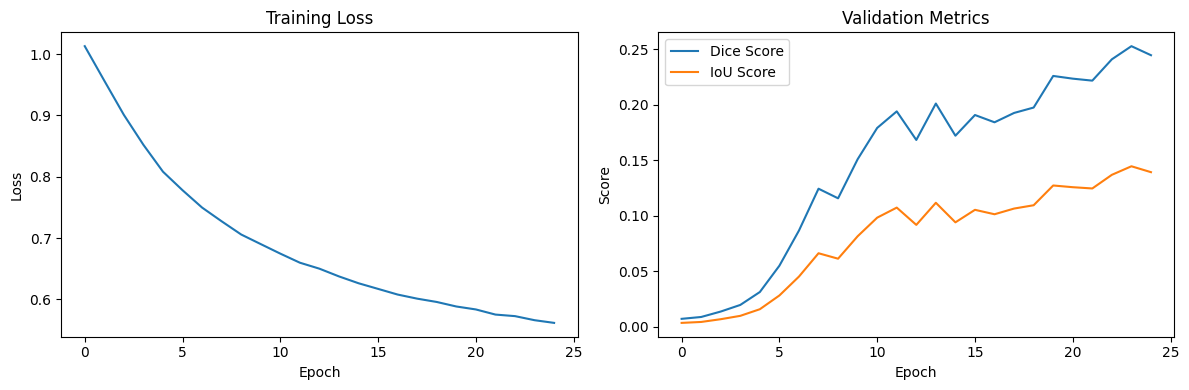

Training history plot saved!


In [ ]:
import os
import torch
import rasterio
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# --- 1. Enhanced Configuration & Hyperparameters ---
# Paths updated to match your Google Drive structure
IMAGE_DIR = '/content/drive/MyDrive/P2 - Amazon ITU - PESU/GEE_Exports_all'
MASK_DIR = '/content/drive/MyDrive/P2 - Amazon ITU - PESU/All_Masks_TIF'
MODEL_SAVE_PATH = '/content/drive/MyDrive/runway_detection_best.pth'

# Enhanced Model Settings - Better encoders for satellite imagery
ENCODER = 'efficientnet-b3'  # Smaller encoder to prevent memory issues
ENCODER_WEIGHTS = 'imagenet'
IN_CHANNELS = 3  # RGB channels only
CLASSES = 1
LEARNING_RATE = 1e-4  # Lower learning rate for stability
EPOCHS = 25
BATCH_SIZE = 4  # Reduced batch size for stability
IMG_SIZE = 256
ACCUMULATION_STEPS = 4  # Higher accumulation for effective batch size of 16

# Advanced training settings
WARMUP_EPOCHS = 5
LABEL_SMOOTHING = 0.1
EARLY_STOPPING_PATIENCE = 10

# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# --- 2. Enhanced Dataset Class with Better Error Handling ---
class EnhancedAirstripDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, in_channels=3, validate_files=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.in_channels = in_channels

        if validate_files:
            # Validate all files exist and are readable
            self.valid_indices = []
            print(f"Validating {len(image_paths)} image-mask pairs...")

            for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
                try:
                    # Quick validation - just check if files can be opened
                    with rasterio.open(img_path) as src:
                        if src.count == 0:
                            continue

                    with rasterio.open(mask_path) as src:
                        mask_sample = src.read(1)
                        # Accept masks even if they're mostly empty - we need some training data
                        if mask_sample is not None and mask_sample.size > 0:
                            self.valid_indices.append(i)

                except Exception as e:
                    print(f"Skipping invalid pair {i}: {e}")
                    continue

            print(f"Valid samples: {len(self.valid_indices)} out of {len(image_paths)}")
        else:
            # Don't validate, use all indices
            self.valid_indices = list(range(len(image_paths)))
            print(f"Using all {len(self.valid_indices)} samples without validation")

    def __len__(self):
        return len(self.valid_indices)

    def normalize_bands(self, image):
        """Enhanced normalization with clipping and validation"""
        # Ensure we have 3 channels
        if image.shape[2] > 3:
            image = image[:, :, :3]
        elif image.shape[2] < 3:
            # Pad with zeros if fewer than 3 channels
            padding = np.zeros((image.shape[0], image.shape[1], 3 - image.shape[2]), dtype=np.float32)
            image = np.concatenate([image, padding], axis=2)

        # Check for invalid values
        if not np.isfinite(image).all():
            print("Warning: Non-finite values in image, replacing with zeros")
            image = np.nan_to_num(image, nan=0.0, posinf=0.0, neginf=0.0)

        # Clip extreme values
        image = np.clip(image, 0, 65535)  # Assuming 16-bit imagery

        # Robust normalization
        for i in range(image.shape[2]):
            channel = image[:, :, i]
            if channel.max() > channel.min():
                # Use robust percentile normalization
                p1, p99 = np.percentile(channel[channel > 0], (1, 99))
                if p99 > p1:
                    image[:, :, i] = np.clip((channel - p1) / (p99 - p1), 0, 1)
                else:
                    image[:, :, i] = channel / (channel.max() + 1e-8)
            else:
                image[:, :, i] = 0

        return image.astype(np.float32)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        image_path = self.image_paths[actual_idx]
        mask_path = self.mask_paths[actual_idx]

        try:
            # Read image
            with rasterio.open(image_path) as src:
                # Read first 3 bands
                bands_to_read = min(3, src.count)
                image = src.read(list(range(1, bands_to_read + 1))).astype(np.float32)
                image = np.transpose(image, (1, 2, 0))

            # Read mask
            with rasterio.open(mask_path) as mask_src:
                mask = mask_src.read(1).astype(np.float32)
                # Ensure binary mask
                mask = np.where(mask > 0, 1.0, 0.0)

            # Check dimensions match
            if image.shape[:2] != mask.shape[:2]:
                # Resize mask to match image
                mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

            # Normalize the image
            image = self.normalize_bands(image)

            # Validate data integrity
            if not np.isfinite(image).all() or not np.isfinite(mask).all():
                raise ValueError("Non-finite values detected")

            # Apply transforms
            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            # Final validation
            if torch.isnan(image).any() or torch.isnan(mask).any():
                raise ValueError("NaN values after transformation")

            return image, mask.unsqueeze(0)

        except Exception as e:
            print(f"Error loading sample {idx} ({image_path}): {str(e)}")
            # Return a valid dummy sample
            dummy_image = torch.zeros((3, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
            dummy_mask = torch.zeros((1, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
            return dummy_image, dummy_mask

# --- 3. Simplified and Robust Augmentations ---
def get_transforms(phase='train'):
    """Simplified augmentations to avoid numerical instability"""

    if phase == 'train':
        return A.Compose([
            A.Resize(height=IMG_SIZE, width=IMG_SIZE),

            # Basic geometric augmentations
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Rotate(limit=10, p=0.3, border_mode=cv2.BORDER_CONSTANT, value=0),

            # Mild intensity augmentations
            A.RandomBrightnessContrast(
                brightness_limit=0.1,
                contrast_limit=0.1,
                p=0.5
            ),

            # Light noise
            A.GaussNoise(var_limit=(0, 0.01), p=0.3),

            # Standard normalization
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=1.0
            ),
            ToTensorV2(),
        ], is_check_shapes=False)
    else:  # Validation
        return A.Compose([
            A.Resize(height=IMG_SIZE, width=IMG_SIZE),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=1.0
            ),
            ToTensorV2(),
        ], is_check_shapes=False)

# --- 4. Robust Loss Function with NaN Protection ---
class RobustRunwayLoss(nn.Module):
    """Robust loss function with NaN protection"""

    def __init__(self, pos_weight=None):
        super(RobustRunwayLoss, self).__init__()
        # Use pos_weight to handle class imbalance
        self.pos_weight = pos_weight
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.smooth = 1e-6

    def dice_loss(self, inputs, targets):
        """Dice loss with numerical stability"""
        inputs = torch.sigmoid(inputs)

        # Flatten tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        union = inputs.sum() + targets.sum()

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

    def forward(self, inputs, targets):
        # Check for NaN inputs
        if torch.isnan(inputs).any() or torch.isnan(targets).any():
            print("Warning: NaN detected in loss inputs!")
            return torch.tensor(0.0, requires_grad=True, device=inputs.device)

        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice_loss(inputs, targets)

        total_loss = 0.5 * bce_loss + 0.5 * dice_loss

        # Check for NaN output
        if torch.isnan(total_loss):
            print("Warning: NaN loss detected!")
            return torch.tensor(0.0, requires_grad=True, device=inputs.device)

        return total_loss

# --- 5. Enhanced Training Functions with Gradient Monitoring ---
def train_one_epoch(loader, model, optimizer, loss_fn, device, accumulation_steps=1):
    """Enhanced training loop with gradient monitoring"""
    model.train()
    running_loss = 0.0
    valid_batches = 0
    loop = tqdm(loader, leave=True, desc="Training")

    optimizer.zero_grad()

    for batch_idx, (data, targets) in enumerate(loop):
        data, targets = data.to(device), targets.to(device)

        # Check for NaN inputs
        if torch.isnan(data).any() or torch.isnan(targets).any():
            print(f"Skipping batch {batch_idx} due to NaN inputs")
            continue

        try:
            predictions = model(data)

            # Check predictions
            if torch.isnan(predictions).any():
                print(f"NaN predictions in batch {batch_idx}")
                continue

            loss = loss_fn(predictions, targets)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Invalid loss in batch {batch_idx}: {loss}")
                continue

            loss = loss / accumulation_steps
            loss.backward()

            # Check gradients
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)

            if total_norm > 1000 or torch.isnan(torch.tensor(total_norm)):
                print(f"Large gradient norm: {total_norm}, clipping...")
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            if (batch_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps
            valid_batches += 1

        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            continue

        if valid_batches > 0:
            loop.set_postfix(loss=running_loss / valid_batches)

    return running_loss / max(valid_batches, 1)

def evaluate(loader, model, loss_fn, device):
    """Enhanced evaluation with better metric calculation"""
    model.eval()
    running_loss = 0.0
    total_intersection = 0
    total_union = 0
    total_target = 0
    total_pred = 0
    valid_batches = 0

    loop = tqdm(loader, leave=True, desc="Validation")

    with torch.no_grad():
        for data, targets in loop:
            data, targets = data.to(device), targets.to(device)

            # Skip invalid batches
            if torch.isnan(data).any() or torch.isnan(targets).any():
                continue

            try:
                predictions = model(data)

                if torch.isnan(predictions).any():
                    continue

                loss = loss_fn(predictions, targets)

                if torch.isnan(loss) or torch.isinf(loss):
                    continue

                running_loss += loss.item()
                valid_batches += 1

                # Convert to binary predictions
                preds_sigmoid = torch.sigmoid(predictions)
                preds_binary = (preds_sigmoid > 0.5).float()

                # Calculate metrics
                intersection = (preds_binary * targets).sum().item()
                pred_sum = preds_binary.sum().item()
                target_sum = targets.sum().item()
                union = pred_sum + target_sum - intersection

                total_intersection += intersection
                total_union += union
                total_target += target_sum
                total_pred += pred_sum

            except Exception as e:
                print(f"Error in validation batch: {e}")
                continue

    if valid_batches == 0:
        print("No valid validation batches!")
        return 0.0, 0.0, 0.0, 0.0

    avg_loss = running_loss / valid_batches

    # Calculate overall metrics
    dice = (2 * total_intersection) / (total_pred + total_target + 1e-8)
    iou = total_intersection / (total_union + 1e-8)
    precision = total_intersection / (total_pred + 1e-8)
    recall = total_intersection / (total_target + 1e-8)

    print(f"Val Loss: {avg_loss:.4f}, Dice: {dice:.4f}, IoU: {iou:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

    return dice, iou, precision, recall

# --- 6. Same image-mask pairing function ---
def find_image_mask_pairs(image_dir, mask_dir):
    """Enhanced pairing logic for image-mask matching"""
    print("Scanning folders and pairing images with masks...")

    # Get all image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    print(f"Found {len(image_files)} image files")

    paired_image_paths = []
    paired_mask_paths = []
    unmatched_images = []

    for img_fname in image_files:
        base_name = os.path.splitext(img_fname)[0]

        # Try different mask naming patterns
        possible_mask_names = [
            f"0_{base_name}.tif",
            f"1_{base_name}.tif",
            f"{base_name}_mask.tif",
            f"mask_{base_name}.tif"
        ]

        found_mask = None
        for mask_name in possible_mask_names:
            mask_path = os.path.join(mask_dir, mask_name)
            if os.path.exists(mask_path):
                found_mask = mask_path
                break

        if found_mask:
            # Verify mask has runway pixels
            try:
                with rasterio.open(found_mask) as src:
                    mask_data = src.read(1)
                    if np.any(mask_data > 0):  # Mask has positive pixels
                        paired_image_paths.append(os.path.join(image_dir, img_fname))
                        paired_mask_paths.append(found_mask)
                    else:
                        print(f"Skipping {img_fname} - empty mask")
            except Exception as e:
                print(f"Error reading mask for {img_fname}: {e}")
        else:
            unmatched_images.append(img_fname)

    print(f"Successfully paired: {len(paired_image_paths)} images")
    print(f"Unmatched images: {len(unmatched_images)}")

    if len(unmatched_images) > 0 and len(unmatched_images) <= 10:
        print("Unmatched files:", unmatched_images[:10])

    return paired_image_paths, paired_mask_paths

# --- 7. Main Execution with Better Error Handling ---
if __name__ == '__main__':
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")
    print(f"Encoder: {ENCODER}")
    print(f"Input channels: {IN_CHANNELS}")
    print(f"Image size: {IMG_SIZE}")

    # Find and pair images with masks
    paired_image_paths, paired_mask_paths = find_image_mask_pairs(IMAGE_DIR, MASK_DIR)

    if len(paired_image_paths) == 0:
        print("CRITICAL ERROR: No valid image-mask pairs found!")
        print("Please check your directory paths and file naming conventions.")
        exit(1)

    # Split data
    train_imgs, val_imgs, train_masks, val_masks = train_test_split(
        paired_image_paths, paired_mask_paths, test_size=0.2, random_state=SEED, stratify=None
    )

    print(f"Training samples: {len(train_imgs)}")
    print(f"Validation samples: {len(val_imgs)}")

    # Create datasets - first try without strict validation
    print("Creating datasets with relaxed validation...")
    train_dataset = EnhancedAirstripDataset(
        train_imgs, train_masks,
        transform=get_transforms('train'),
        in_channels=IN_CHANNELS,
        validate_files=False  # Skip strict validation first
    )

    val_dataset = EnhancedAirstripDataset(
        val_imgs, val_masks,
        transform=get_transforms('val'),
        in_channels=IN_CHANNELS,
        validate_files=False
    )

    # Check if we have valid datasets
    if len(train_dataset) == 0:
        print("ERROR: No valid training samples found!")
        print("This usually means:")
        print("1. All masks are empty (no runway pixels)")
        print("2. File corruption issues")
        print("3. Incorrect file paths or naming")

        # Let's debug by checking a few files directly
        print("\nDebugging first few image-mask pairs...")
        for i in range(min(5, len(train_imgs))):
            img_path = train_imgs[i]
            mask_path = train_masks[i]
            print(f"\nPair {i+1}:")
            print(f"Image: {img_path}")
            print(f"Mask: {mask_path}")

            try:
                with rasterio.open(mask_path) as src:
                    mask_data = src.read(1)
                    unique_vals = np.unique(mask_data)
                    pos_pixels = np.sum(mask_data > 0)
                    print(f"Mask unique values: {unique_vals}")
                    print(f"Positive pixels: {pos_pixels}")
                    print(f"Mask shape: {mask_data.shape}")
            except Exception as e:
                print(f"Error reading mask: {e}")

        exit(1)

    # Calculate class weights for imbalanced data
    print("Calculating class weights...")
    total_pixels = 0
    positive_pixels = 0

    # Use a simple approach - check raw mask files instead of dataset
    sample_masks = train_masks[:min(10, len(train_masks))]
    for mask_path in sample_masks:
        try:
            with rasterio.open(mask_path) as src:
                mask_data = src.read(1)
                total_pixels += mask_data.size
                positive_pixels += np.sum(mask_data > 0)
        except Exception as e:
            print(f"Error reading {mask_path}: {e}")
            continue

    if positive_pixels > 0:
        pos_weight = (total_pixels - positive_pixels) / positive_pixels
        pos_weight = max(1.0, min(pos_weight, 100))  # Ensure at least 1.0
        print(f"Positive class weight: {pos_weight:.2f}")
    else:
        pos_weight = 1.0
        print("Warning: No positive pixels found, using weight 1.0")

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=0, pin_memory=True, drop_last=True  # num_workers=0 for debugging
    )

    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, pin_memory=True
    )

    # Test data loading
    print("Testing data loading...")
    try:
        sample_batch = next(iter(train_loader))
        print(f"Sample batch shapes: {sample_batch[0].shape}, {sample_batch[1].shape}")
        print(f"Sample image range: {sample_batch[0].min():.3f} to {sample_batch[0].max():.3f}")
        print(f"Sample mask range: {sample_batch[1].min():.3f} to {sample_batch[1].max():.3f}")
        print(f"Positive pixels in sample: {sample_batch[1].sum().item()}")
    except Exception as e:
        print(f"Error loading sample batch: {e}")
        exit(1)

    # Initialize model
    model = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=ENCODER_WEIGHTS,
        in_channels=IN_CHANNELS,
        classes=CLASSES,
        activation=None
    ).to(device)

    # Initialize loss and optimizer
    loss_fn = RobustRunwayLoss(pos_weight=torch.tensor(pos_weight).to(device))

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=1e-5,
        eps=1e-8
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, verbose=True
    )

    # Training loop
    best_dice_score = 0.0
    patience_counter = 0
    train_losses = []
    val_metrics = []

    print("\nStarting training...")
    for epoch in range(EPOCHS):
        print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")

        # Training
        train_loss = train_one_epoch(
            train_loader, model, optimizer, loss_fn, device, ACCUMULATION_STEPS
        )
        train_losses.append(train_loss)
        print(f"Train Loss: {train_loss:.4f}")

        # Validation
        val_dice, val_iou, val_precision, val_recall = evaluate(
            val_loader, model, loss_fn, device
        )
        val_metrics.append({
            'dice': val_dice, 'iou': val_iou,
            'precision': val_precision, 'recall': val_recall
        })

        # Learning rate scheduling
        scheduler.step(val_dice)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current LR: {current_lr:.2e}")

        # Save best model
        if val_dice > best_dice_score:
            best_dice_score = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_dice': best_dice_score,
                'train_loss': train_loss,
                'val_metrics': val_metrics[-1]
            }, MODEL_SAVE_PATH)
            print(f"New best model saved! Dice: {best_dice_score:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    print("\nTraining completed!")
    print(f"Best Dice Score: {best_dice_score:.4f}")
    print(f"Model saved to: {MODEL_SAVE_PATH}")

    # Plot training history
    if len(train_losses) > 0 and len(val_metrics) > 0:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(1, 2, 2)
        dice_scores = [m['dice'] for m in val_metrics]
        iou_scores = [m['iou'] for m in val_metrics]
        plt.plot(dice_scores, label='Dice Score')
        plt.plot(iou_scores, label='IoU Score')
        plt.title('Validation Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()

        plt.tight_layout()
        plt.savefig('/content/drive/MyDrive/training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("Training history plot saved!")

Using cuda device
Encoder: efficientnet-b3
Input channels: 3
Image size: 256
Scanning folders and pairing images with masks...
Found 1262 image files
Skipping id_1017.tif - empty mask
Skipping id_1182.tif - empty mask
Skipping id_822.tif - empty mask
Skipping id_810.tif - empty mask
Skipping id_1172.tif - empty mask
Skipping id_807.tif - empty mask
Skipping id_800.tif - empty mask
Skipping id_808.tif - empty mask
Skipping id_1170.tif - empty mask
Skipping id_1164.tif - empty mask
Skipping id_991.tif - empty mask
Skipping id_1656.tif - empty mask
Skipping id_983.tif - empty mask
Skipping id_1607.tif - empty mask
Skipping id_1159.tif - empty mask
Skipping id_1151.tif - empty mask
Skipping id_1610.tif - empty mask
Skipping id_1588.tif - empty mask
Skipping id_1587.tif - empty mask
Skipping id_988.tif - empty mask
Skipping id_990.tif - empty mask
Skipping id_1541.tif - empty mask
Skipping id_1146.tif - empty mask
Skipping id_1539.tif - empty mask
Skipping id_1609.tif - empty mask
Skipping 

Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   4%|▎         | 3/83 [00:11<05:16,  3.95s/it, loss=1.03]

Training:   6%|▌         | 5/83 [00:20<05:34,  4.29s/it, loss=1.04]

Training:   7%|▋         | 6/83 [00:25<05:43,  4.47s/it, loss=1.04]

Training:  10%|▉         | 8/83 [00:34<05:39,  4.53s/it, loss=1.04]

Training:  19%|█▉        | 16/83 [01:13<05:46,  5.17s/it, loss=1.03]

Training:  22%|██▏       | 18/83 [01:27<06:16,  5.80s/it, loss=1.03]

Training:  24%|██▍       | 20/83 [01:36<05:27,  5.20s/it, loss=1.03]

Training:  25%|██▌       | 21/83 [01:41<05:18,  5.13s/it, loss=1.03]

Training:  27%|██▋       | 22/83 [01:46<05:14,  5.15s/it, loss=1.03]

Training:  28%|██▊       | 23/83 [01:50<04:47,  4.80s/it, loss=1.03]

Training:  29%|██▉       | 24/83 [01:57<05:26,  5.53s/it, loss=1.03]

Training:  30%|███       | 25/83 [02:02<05:00,  5.19s/it, loss=1.03]

Training:  31%|███▏      | 26/83 [02:05<04:31,  4.76s/it, loss=1.03]

Training:  34%|███▎      | 28/83 [02:14<04:03,  4.43s/it, loss=1.03]

Training:  37%|███▋      | 31/83 [02:27<03:46,  4.36s/it, loss=1.03]

Training:  39%|███▊      | 32/83 [02:35<04:38,  5.47s/it, loss=1.03]

Training:  40%|███▉      | 33/83 [02:40<04:27,  5.34s/it, loss=1.03]

Training:  42%|████▏     | 35/83 [02:50<04:06,  5.13s/it, loss=1.03]

Training:  45%|████▍     | 37/83 [02:59<03:46,  4.91s/it, loss=1.03]

Training:  46%|████▌     | 38/83 [03:04<03:35,  4.80s/it, loss=1.02]

Training:  48%|████▊     | 40/83 [03:22<05:15,  7.35s/it, loss=1.02]

Training:  49%|████▉     | 41/83 [03:31<05:37,  8.03s/it, loss=1.02]

Training:  51%|█████     | 42/83 [03:36<04:45,  6.95s/it, loss=1.02]

Training:  52%|█████▏    | 43/83 [03:39<03:59,  5.99s/it, loss=1.02]

Training:  55%|█████▌    | 46/83 [03:53<03:08,  5.10s/it, loss=1.02]

Training:  57%|█████▋    | 47/83 [04:00<03:21,  5.60s/it, loss=1.02]

Training:  60%|██████    | 50/83 [04:14<02:47,  5.07s/it, loss=1.02]

Training:  61%|██████▏   | 51/83 [04:18<02:33,  4.79s/it, loss=1.02]

Training:  65%|██████▌   | 54/83 [04:44<03:09,  6.53s/it, loss=1.02]

Training:  66%|██████▋   | 55/83 [04:48<02:44,  5.88s/it, loss=1.02]

Training:  71%|███████   | 59/83 [05:07<01:58,  4.95s/it, loss=1.02]

Training:  72%|███████▏  | 60/83 [05:11<01:51,  4.84s/it, loss=1.02]

Training:  75%|███████▍  | 62/83 [05:21<01:39,  4.75s/it, loss=1.01]

Training:  78%|███████▊  | 65/83 [05:36<01:28,  4.90s/it, loss=1.01]

Training:  81%|████████  | 67/83 [05:45<01:15,  4.71s/it, loss=1.01]

Training:  87%|████████▋ | 72/83 [06:11<00:56,  5.11s/it, loss=1.01]

Training:  88%|████████▊ | 73/83 [06:16<00:49,  4.92s/it, loss=1.01]

Training:  89%|████████▉ | 74/83 [06:21<00:43,  4.81s/it, loss=1.01]

Training:  90%|█████████ | 75/83 [06:26<00:39,  4.90s/it, loss=1.01]

Training:  92%|█████████▏| 76/83 [06:30<00:33,  4.80s/it, loss=1.01]

Training:  94%|█████████▍| 78/83 [06:40<00:23,  4.78s/it, loss=1.01]

Training:  95%|█████████▌| 79/83 [06:45<00:19,  4.89s/it, loss=1.01]

Training:  96%|█████████▋| 80/83 [06:49<00:14,  4.79s/it, loss=1.01]

Training:  98%|█████████▊| 81/83 [06:55<00:09,  4.91s/it, loss=1.01]

Training:  99%|█████████▉| 82/83 [06:59<00:04,  4.91s/it, loss=1.01]

Training: 100%|██████████| 83/83 [07:04<00:00,  5.12s/it, loss=1.01]


Train Loss: 1.0064


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:09<01:32,  4.85s/it]

Validation:  14%|█▍        | 3/21 [00:15<01:29,  4.99s/it]

Validation:  24%|██▍       | 5/21 [00:23<01:13,  4.61s/it]

Validation:  29%|██▊       | 6/21 [00:28<01:06,  4.46s/it]

Validation:  33%|███▎      | 7/21 [00:32<01:00,  4.30s/it]

Validation:  38%|███▊      | 8/21 [00:36<00:55,  4.25s/it]

Validation:  57%|█████▋    | 12/21 [00:55<00:42,  4.70s/it]

Validation:  62%|██████▏   | 13/21 [00:59<00:35,  4.47s/it]

Validation:  67%|██████▋   | 14/21 [01:03<00:31,  4.44s/it]

Validation:  71%|███████▏  | 15/21 [01:09<00:29,  4.86s/it]

Validation:  76%|███████▌  | 16/21 [01:13<00:23,  4.69s/it]

Validation:  86%|████████▌ | 18/21 [01:22<00:13,  4.54s/it]

Validation: 100%|██████████| 21/21 [01:34<00:00,  4.52s/it]


Val Loss: 0.9110, Dice: 0.0076, IoU: 0.0038
Precision: 0.0038, Recall: 0.8155
Current LR: 1.00e-04
New best model saved! Dice: 0.0076

=== Epoch 2/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   4%|▎         | 3/83 [00:03<01:43,  1.29s/it, loss=0.978]

Training:   7%|▋         | 6/83 [00:08<01:54,  1.49s/it, loss=0.979]

Training:  10%|▉         | 8/83 [00:11<01:45,  1.40s/it, loss=0.979]

Training:  12%|█▏        | 10/83 [00:17<02:31,  2.08s/it, loss=0.977]

Training:  13%|█▎        | 11/83 [00:18<02:18,  1.93s/it, loss=0.975]

Training:  16%|█▌        | 13/83 [00:22<02:06,  1.80s/it, loss=0.972]

Training:  18%|█▊        | 15/83 [00:24<01:46,  1.57s/it, loss=0.975]

Training:  19%|█▉        | 16/83 [00:26<01:40,  1.50s/it, loss=0.975]

Training:  20%|██        | 17/83 [00:27<01:35,  1.45s/it, loss=0.974]

Training:  22%|██▏       | 18/83 [00:28<01:29,  1.37s/it, loss=0.973]

Training:  23%|██▎       | 19/83 [00:30<01:26,  1.35s/it, loss=0.973]

Training:  25%|██▌       | 21/83 [00:33<01:28,  1.43s/it, loss=0.973]

Training:  29%|██▉       | 24/83 [00:37<01:22,  1.41s/it, loss=0.972]

Training:  30%|███       | 25/83 [00:38<01:19,  1.38s/it, loss=0.972]

Training:  31%|███▏      | 26/83 [00:39<01:16,  1.35s/it, loss=0.971]

Training:  35%|███▍      | 29/83 [00:43<01:09,  1.28s/it, loss=0.968]

Training:  36%|███▌      | 30/83 [00:45<01:09,  1.31s/it, loss=0.968]

Training:  39%|███▊      | 32/83 [00:48<01:16,  1.49s/it, loss=0.967]

Training:  40%|███▉      | 33/83 [00:49<01:12,  1.44s/it, loss=0.967]

Training:  43%|████▎     | 36/83 [00:53<01:03,  1.35s/it, loss=0.966]

Training:  46%|████▌     | 38/83 [00:56<01:00,  1.33s/it, loss=0.964]

Training:  49%|████▉     | 41/83 [01:01<01:05,  1.56s/it, loss=0.965]

Training:  51%|█████     | 42/83 [01:02<01:01,  1.49s/it, loss=0.964]

Training:  52%|█████▏    | 43/83 [01:03<00:57,  1.44s/it, loss=0.964]

Training:  53%|█████▎    | 44/83 [01:05<00:55,  1.43s/it, loss=0.963]

Training:  54%|█████▍    | 45/83 [01:06<00:53,  1.41s/it, loss=0.963]

Training:  55%|█████▌    | 46/83 [01:08<00:51,  1.40s/it, loss=0.963]

Training:  58%|█████▊    | 48/83 [01:10<00:47,  1.37s/it, loss=0.962]

Training:  59%|█████▉    | 49/83 [01:12<00:49,  1.46s/it, loss=0.962]

Training:  66%|██████▋   | 55/83 [01:22<00:48,  1.73s/it, loss=0.96]

Training:  67%|██████▋   | 56/83 [01:23<00:43,  1.63s/it, loss=0.96]

Training:  71%|███████   | 59/83 [01:28<00:38,  1.59s/it, loss=0.958]

Training:  77%|███████▋  | 64/83 [01:35<00:26,  1.37s/it, loss=0.957]

Training:  81%|████████  | 67/83 [01:39<00:23,  1.50s/it, loss=0.955]

Training:  82%|████████▏ | 68/83 [01:41<00:22,  1.51s/it, loss=0.955]

Training:  83%|████████▎ | 69/83 [01:42<00:20,  1.46s/it, loss=0.955]

Training:  84%|████████▍ | 70/83 [01:44<00:18,  1.44s/it, loss=0.955]

Training:  86%|████████▌ | 71/83 [01:45<00:17,  1.42s/it, loss=0.954]

Training:  87%|████████▋ | 72/83 [01:46<00:15,  1.40s/it, loss=0.953]

Training:  89%|████████▉ | 74/83 [01:49<00:12,  1.35s/it, loss=0.952]

Training:  95%|█████████▌| 79/83 [01:57<00:05,  1.44s/it, loss=0.951]

Training:  99%|█████████▉| 82/83 [02:01<00:01,  1.37s/it, loss=0.95]

Training: 100%|██████████| 83/83 [02:02<00:00,  1.47s/it, loss=0.949]


Train Loss: 0.9491


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:25,  1.33s/it]

Validation:  14%|█▍        | 3/21 [00:04<00:26,  1.46s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:22,  1.39s/it]

Validation:  29%|██▊       | 6/21 [00:08<00:19,  1.33s/it]

Validation:  33%|███▎      | 7/21 [00:09<00:18,  1.30s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:16,  1.28s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:11,  1.29s/it]

Validation:  62%|██████▏   | 13/21 [00:17<00:11,  1.38s/it]

Validation:  67%|██████▋   | 14/21 [00:18<00:09,  1.41s/it]

Validation:  71%|███████▏  | 15/21 [00:20<00:08,  1.36s/it]

Validation:  76%|███████▌  | 16/21 [00:21<00:06,  1.30s/it]

Validation:  86%|████████▌ | 18/21 [00:23<00:03,  1.25s/it]

Validation: 100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


Val Loss: 0.8865, Dice: 0.0098, IoU: 0.0049
Precision: 0.0049, Recall: 0.9543
Current LR: 1.00e-04
New best model saved! Dice: 0.0098

=== Epoch 3/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   2%|▏         | 2/83 [00:03<02:08,  1.59s/it, loss=0.933]

Training:   5%|▍         | 4/83 [00:05<01:55,  1.46s/it, loss=0.924]

Training:   8%|▊         | 7/83 [00:09<01:40,  1.33s/it, loss=0.921]

Training:  10%|▉         | 8/83 [00:11<01:39,  1.33s/it, loss=0.921]

Training:  13%|█▎        | 11/83 [00:19<02:21,  1.96s/it, loss=0.919]

Training:  17%|█▋        | 14/83 [00:23<01:49,  1.58s/it, loss=0.919]

Training:  18%|█▊        | 15/83 [00:24<01:40,  1.47s/it, loss=0.917]

Training:  19%|█▉        | 16/83 [00:26<01:37,  1.46s/it, loss=0.918]

Training:  20%|██        | 17/83 [00:27<01:33,  1.41s/it, loss=0.919]

Training:  27%|██▋       | 22/83 [00:34<01:24,  1.38s/it, loss=0.914]

Training:  28%|██▊       | 23/83 [00:35<01:20,  1.34s/it, loss=0.914]

Training:  30%|███       | 25/83 [00:38<01:15,  1.30s/it, loss=0.915]

Training:  33%|███▎      | 27/83 [00:40<01:13,  1.31s/it, loss=0.914]

Training:  35%|███▍      | 29/83 [00:44<01:20,  1.49s/it, loss=0.912]

Training:  36%|███▌      | 30/83 [00:45<01:14,  1.41s/it, loss=0.912]

Training:  37%|███▋      | 31/83 [00:46<01:11,  1.37s/it, loss=0.912]

Training:  39%|███▊      | 32/83 [00:48<01:09,  1.37s/it, loss=0.912]

Training:  40%|███▉      | 33/83 [00:50<01:31,  1.83s/it, loss=0.911]

Training:  41%|████      | 34/83 [00:52<01:22,  1.68s/it, loss=0.911]

Training:  45%|████▍     | 37/83 [00:56<01:13,  1.59s/it, loss=0.91]

Training:  47%|████▋     | 39/83 [00:59<01:03,  1.45s/it, loss=0.909]

Training:  49%|████▉     | 41/83 [01:02<00:57,  1.37s/it, loss=0.908]

Training:  52%|█████▏    | 43/83 [01:04<00:54,  1.35s/it, loss=0.908]

Training:  57%|█████▋    | 47/83 [01:10<00:54,  1.51s/it, loss=0.907]

Training:  60%|██████    | 50/83 [01:14<00:45,  1.38s/it, loss=0.906]

Training:  61%|██████▏   | 51/83 [01:15<00:42,  1.34s/it, loss=0.906]

Training:  64%|██████▍   | 53/83 [01:18<00:40,  1.34s/it, loss=0.905]

Training:  66%|██████▋   | 55/83 [01:21<00:38,  1.37s/it, loss=0.905]

Training:  67%|██████▋   | 56/83 [01:23<00:39,  1.46s/it, loss=0.905]

Training:  70%|██████▉   | 58/83 [01:25<00:35,  1.43s/it, loss=0.904]

Training:  71%|███████   | 59/83 [01:27<00:33,  1.39s/it, loss=0.903]

Training:  72%|███████▏  | 60/83 [01:28<00:30,  1.34s/it, loss=0.903]

Training:  73%|███████▎  | 61/83 [01:29<00:28,  1.31s/it, loss=0.903]

Training:  75%|███████▍  | 62/83 [01:30<00:26,  1.28s/it, loss=0.902]

Training:  80%|███████▉  | 66/83 [01:36<00:24,  1.44s/it, loss=0.9]

Training:  81%|████████  | 67/83 [01:38<00:23,  1.46s/it, loss=0.9]

Training:  86%|████████▌ | 71/83 [01:43<00:15,  1.32s/it, loss=0.899]

Training:  87%|████████▋ | 72/83 [01:44<00:14,  1.32s/it, loss=0.898]

Training:  88%|████████▊ | 73/83 [01:45<00:13,  1.34s/it, loss=0.898]

Training:  89%|████████▉ | 74/83 [01:47<00:12,  1.34s/it, loss=0.897]

Training:  90%|█████████ | 75/83 [01:48<00:11,  1.42s/it, loss=0.897]

Training:  93%|█████████▎| 77/83 [01:51<00:08,  1.43s/it, loss=0.896]

Training:  96%|█████████▋| 80/83 [01:55<00:04,  1.37s/it, loss=0.895]

Training:  98%|█████████▊| 81/83 [01:57<00:02,  1.33s/it, loss=0.895]

Training: 100%|██████████| 83/83 [01:59<00:00,  1.44s/it, loss=0.894]


Train Loss: 0.8944


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:27,  1.45s/it]

Validation:  14%|█▍        | 3/21 [00:04<00:27,  1.52s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:21,  1.36s/it]

Validation:  29%|██▊       | 6/21 [00:08<00:19,  1.29s/it]

Validation:  33%|███▎      | 7/21 [00:09<00:17,  1.28s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:16,  1.26s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:12,  1.35s/it]

Validation:  62%|██████▏   | 13/21 [00:17<00:11,  1.42s/it]

Validation:  67%|██████▋   | 14/21 [00:18<00:09,  1.37s/it]

Validation:  71%|███████▏  | 15/21 [00:19<00:07,  1.33s/it]

Validation:  76%|███████▌  | 16/21 [00:21<00:06,  1.30s/it]

Validation:  86%|████████▌ | 18/21 [00:23<00:03,  1.23s/it]

Validation: 100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


Val Loss: 0.8418, Dice: 0.0150, IoU: 0.0076
Precision: 0.0076, Recall: 0.9356
Current LR: 1.00e-04
New best model saved! Dice: 0.0150

=== Epoch 4/25 ===


Training:   4%|▎         | 3/83 [00:04<01:57,  1.46s/it, loss=0.863]

Training:   7%|▋         | 6/83 [00:08<01:38,  1.28s/it, loss=0.865]

Training:  23%|██▎       | 19/83 [00:31<01:37,  1.52s/it, loss=0.861]

Training:  24%|██▍       | 20/83 [00:32<01:31,  1.45s/it, loss=0.86]

Training:  25%|██▌       | 21/83 [00:34<01:27,  1.41s/it, loss=0.86]

Training:  27%|██▋       | 22/83 [00:35<01:24,  1.39s/it, loss=0.86]

Training:  28%|██▊       | 23/83 [00:36<01:20,  1.34s/it, loss=0.86]

Training:  31%|███▏      | 26/83 [00:40<01:17,  1.36s/it, loss=0.858]

Training:  34%|███▎      | 28/83 [00:43<01:19,  1.45s/it, loss=0.857]

Training:  35%|███▍      | 29/83 [00:45<01:14,  1.38s/it, loss=0.857]

Training:  37%|███▋      | 31/83 [00:47<01:12,  1.38s/it, loss=0.856]

Training:  39%|███▊      | 32/83 [00:49<01:09,  1.36s/it, loss=0.856]

Training:  40%|███▉      | 33/83 [00:50<01:06,  1.34s/it, loss=0.857]

Training:  41%|████      | 34/83 [00:51<01:05,  1.33s/it, loss=0.857]

Training:  42%|████▏     | 35/83 [00:53<01:03,  1.33s/it, loss=0.857]

Training:  43%|████▎     | 36/83 [00:54<01:09,  1.47s/it, loss=0.857]

Training:  46%|████▌     | 38/83 [00:57<01:06,  1.47s/it, loss=0.857]

Training:  48%|████▊     | 40/83 [01:00<00:58,  1.36s/it, loss=0.856]

Training:  53%|█████▎    | 44/83 [01:05<00:50,  1.30s/it, loss=0.854]

Training:  55%|█████▌    | 46/83 [01:08<00:54,  1.48s/it, loss=0.853]

Training:  57%|█████▋    | 47/83 [01:10<00:53,  1.48s/it, loss=0.853]

Training:  63%|██████▎   | 52/83 [01:16<00:40,  1.31s/it, loss=0.852]

Training:  64%|██████▍   | 53/83 [01:17<00:38,  1.30s/it, loss=0.852]

Training:  65%|██████▌   | 54/83 [01:19<00:38,  1.31s/it, loss=0.852]

Training:  66%|██████▋   | 55/83 [01:20<00:40,  1.43s/it, loss=0.852]

Training:  67%|██████▋   | 56/83 [01:22<00:40,  1.52s/it, loss=0.851]

Training:  69%|██████▊   | 57/83 [01:23<00:37,  1.45s/it, loss=0.851]

Training:  70%|██████▉   | 58/83 [01:25<00:35,  1.43s/it, loss=0.852]

Training:  72%|███████▏  | 60/83 [01:27<00:30,  1.34s/it, loss=0.851]

Training:  76%|███████▌  | 63/83 [01:31<00:25,  1.26s/it, loss=0.85]

Training:  77%|███████▋  | 64/83 [01:32<00:24,  1.29s/it, loss=0.85]

Training:  78%|███████▊  | 65/83 [01:34<00:25,  1.41s/it, loss=0.849]

Training:  80%|███████▉  | 66/83 [01:36<00:25,  1.51s/it, loss=0.849]

Training:  82%|████████▏ | 68/83 [01:38<00:20,  1.39s/it, loss=0.849]

Training:  83%|████████▎ | 69/83 [01:40<00:18,  1.34s/it, loss=0.849]

Training:  86%|████████▌ | 71/83 [01:42<00:15,  1.28s/it, loss=0.848]

Training:  89%|████████▉ | 74/83 [01:46<00:11,  1.32s/it, loss=0.848]

Training:  90%|█████████ | 75/83 [01:48<00:11,  1.44s/it, loss=0.847]

Training:  93%|█████████▎| 77/83 [01:51<00:08,  1.42s/it, loss=0.847]

Training:  94%|█████████▍| 78/83 [01:52<00:06,  1.39s/it, loss=0.847]

Training:  95%|█████████▌| 79/83 [01:53<00:05,  1.33s/it, loss=0.847]

Training:  98%|█████████▊| 81/83 [01:56<00:02,  1.31s/it, loss=0.846]

Training: 100%|██████████| 83/83 [01:58<00:00,  1.43s/it, loss=0.846]


Train Loss: 0.8455


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:28,  1.50s/it]

Validation:  14%|█▍        | 3/21 [00:04<00:26,  1.48s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:21,  1.33s/it]

Validation:  29%|██▊       | 6/21 [00:08<00:19,  1.28s/it]

Validation:  33%|███▎      | 7/21 [00:09<00:17,  1.27s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:16,  1.26s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:12,  1.37s/it]

Validation:  62%|██████▏   | 13/21 [00:17<00:11,  1.40s/it]

Validation:  67%|██████▋   | 14/21 [00:18<00:09,  1.35s/it]

Validation:  71%|███████▏  | 15/21 [00:19<00:07,  1.33s/it]

Validation:  76%|███████▌  | 16/21 [00:21<00:06,  1.29s/it]

Validation:  86%|████████▌ | 18/21 [00:23<00:03,  1.23s/it]

Validation: 100%|██████████| 21/21 [00:28<00:00,  1.37s/it]


Val Loss: 0.8074, Dice: 0.0229, IoU: 0.0116
Precision: 0.0116, Recall: 0.9132
Current LR: 1.00e-04
New best model saved! Dice: 0.0229

=== Epoch 5/25 ===


Training:   6%|▌         | 5/83 [00:06<01:39,  1.28s/it, loss=0.821]

Training:   8%|▊         | 7/83 [00:09<01:36,  1.27s/it, loss=0.821]

Training:  10%|▉         | 8/83 [00:10<01:36,  1.29s/it, loss=0.822]

Training:  11%|█         | 9/83 [00:16<03:17,  2.66s/it, loss=0.821]

Training:  14%|█▍        | 12/83 [00:20<02:06,  1.79s/it, loss=0.819]

Training:  16%|█▌        | 13/83 [00:21<01:56,  1.66s/it, loss=0.819]

Training:  17%|█▋        | 14/83 [00:22<01:46,  1.54s/it, loss=0.821]

Training:  19%|█▉        | 16/83 [00:25<01:41,  1.51s/it, loss=0.82]

Training:  20%|██        | 17/83 [00:27<01:43,  1.56s/it, loss=0.819]

Training:  22%|██▏       | 18/83 [00:28<01:36,  1.49s/it, loss=0.82]

Training:  23%|██▎       | 19/83 [00:30<01:31,  1.43s/it, loss=0.82]

Training:  24%|██▍       | 20/83 [00:31<01:26,  1.37s/it, loss=0.819]

Training:  28%|██▊       | 23/83 [00:34<01:14,  1.24s/it, loss=0.82]

Training:  28%|██▊       | 23/83 [00:35<01:14,  1.24s/it, loss=0.82]

Training:  29%|██▉       | 24/83 [00:36<01:13,  1.25s/it, loss=0.82]

Training:  30%|███       | 25/83 [00:37<01:13,  1.26s/it, loss=0.819]

Training:  31%|███▏      | 26/83 [00:38<01:18,  1.38s/it, loss=0.819]

Training:  34%|███▎      | 28/83 [00:41<01:16,  1.40s/it, loss=0.818]

Training:  35%|███▍      | 29/83 [00:43<01:12,  1.35s/it, loss=0.819]

Training:  36%|███▌      | 30/83 [00:44<01:08,  1.30s/it, loss=0.82]

Training:  37%|███▋      | 31/83 [00:45<01:07,  1.29s/it, loss=0.82]

Training:  45%|████▍     | 37/83 [00:53<01:08,  1.48s/it, loss=0.819]

Training:  46%|████▌     | 38/83 [00:55<01:03,  1.42s/it, loss=0.819]

Training:  48%|████▊     | 40/83 [00:57<00:58,  1.35s/it, loss=0.819]

Training:  49%|████▉     | 41/83 [00:59<00:55,  1.31s/it, loss=0.818]

Training:  53%|█████▎    | 44/83 [01:02<00:47,  1.23s/it, loss=0.817]

Training:  59%|█████▉    | 49/83 [01:09<00:45,  1.35s/it, loss=0.815]

Training:  60%|██████    | 50/83 [01:11<00:43,  1.33s/it, loss=0.815]

Training:  64%|██████▍   | 53/83 [01:14<00:39,  1.30s/it, loss=0.814]

Training:  66%|██████▋   | 55/83 [01:17<00:35,  1.27s/it, loss=0.814]

Training:  71%|███████   | 59/83 [01:23<00:33,  1.38s/it, loss=0.812]

Training:  72%|███████▏  | 60/83 [01:24<00:30,  1.33s/it, loss=0.812]

Training:  75%|███████▍  | 62/83 [01:27<00:27,  1.30s/it, loss=0.811]

Training:  77%|███████▋  | 64/83 [01:29<00:24,  1.28s/it, loss=0.811]

Training:  80%|███████▉  | 66/83 [01:32<00:24,  1.43s/it, loss=0.81]

Training:  82%|████████▏ | 68/83 [01:35<00:21,  1.42s/it, loss=0.809]

Training:  83%|████████▎ | 69/83 [01:36<00:19,  1.38s/it, loss=0.809]

Training:  86%|████████▌ | 71/83 [01:39<00:15,  1.32s/it, loss=0.809]

Training:  88%|████████▊ | 73/83 [01:42<00:12,  1.30s/it, loss=0.809]

Training:  89%|████████▉ | 74/83 [01:43<00:11,  1.29s/it, loss=0.809]

Training:  92%|█████████▏| 76/83 [01:46<00:10,  1.46s/it, loss=0.809]

Training:  94%|█████████▍| 78/83 [01:49<00:06,  1.39s/it, loss=0.808]

Training:  95%|█████████▌| 79/83 [01:50<00:05,  1.35s/it, loss=0.808]

Training:  96%|█████████▋| 80/83 [01:51<00:03,  1.33s/it, loss=0.808]

Training:  99%|█████████▉| 82/83 [01:54<00:01,  1.34s/it, loss=0.808]

Training: 100%|██████████| 83/83 [01:57<00:00,  1.41s/it, loss=0.807]


Train Loss: 0.8072


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:03<00:30,  1.59s/it]

Validation:  14%|█▍        | 3/21 [00:04<00:26,  1.45s/it]

Validation:  24%|██▍       | 5/21 [00:07<00:21,  1.33s/it]

Validation:  29%|██▊       | 6/21 [00:08<00:19,  1.29s/it]

Validation:  33%|███▎      | 7/21 [00:09<00:18,  1.29s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:16,  1.28s/it]

Validation:  57%|█████▋    | 12/21 [00:16<00:13,  1.45s/it]

Validation:  62%|██████▏   | 13/21 [00:17<00:11,  1.38s/it]

Validation:  67%|██████▋   | 14/21 [00:19<00:09,  1.35s/it]

Validation:  71%|███████▏  | 15/21 [00:20<00:07,  1.33s/it]

Validation:  76%|███████▌  | 16/21 [00:21<00:06,  1.31s/it]

Validation:  86%|████████▌ | 18/21 [00:23<00:03,  1.24s/it]

Validation: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


Val Loss: 0.7733, Dice: 0.0408, IoU: 0.0208
Precision: 0.0209, Recall: 0.8630
Current LR: 1.00e-04
New best model saved! Dice: 0.0408

=== Epoch 6/25 ===


Training:   1%|          | 1/83 [00:01<02:12,  1.61s/it, loss=0.794]

Training:   2%|▏         | 2/83 [00:02<01:51,  1.37s/it, loss=0.79]

Training:   8%|▊         | 7/83 [00:09<01:34,  1.24s/it, loss=0.789]

Training:  10%|▉         | 8/83 [00:10<01:32,  1.24s/it, loss=0.789]

Training:  12%|█▏        | 10/83 [00:16<03:03,  2.51s/it, loss=0.789]

Training:  20%|██        | 17/83 [00:26<01:40,  1.52s/it, loss=0.788]

Training:  22%|██▏       | 18/83 [00:28<01:40,  1.55s/it, loss=0.788]

Training:  25%|██▌       | 21/83 [00:31<01:24,  1.36s/it, loss=0.789]

Training:  27%|██▋       | 22/83 [00:33<01:22,  1.35s/it, loss=0.788]

Training:  29%|██▉       | 24/83 [00:35<01:16,  1.29s/it, loss=0.788]

Training:  33%|███▎      | 27/83 [00:39<01:17,  1.39s/it, loss=0.789]

Training:  34%|███▎      | 28/83 [00:41<01:20,  1.46s/it, loss=0.789]

Training:  35%|███▍      | 29/83 [00:42<01:15,  1.40s/it, loss=0.789]

Training:  36%|███▌      | 30/83 [00:43<01:12,  1.36s/it, loss=0.789]

Training:  39%|███▊      | 32/83 [00:46<01:07,  1.33s/it, loss=0.788]

Training:  40%|███▉      | 33/83 [00:47<01:05,  1.31s/it, loss=0.788]

Training:  43%|████▎     | 36/83 [00:51<01:00,  1.29s/it, loss=0.787]

Training:  46%|████▌     | 38/83 [00:54<01:05,  1.46s/it, loss=0.786]

Training:  47%|████▋     | 39/83 [00:56<01:02,  1.42s/it, loss=0.786]

Training:  48%|████▊     | 40/83 [00:57<00:59,  1.38s/it, loss=0.786]

Training:  49%|████▉     | 41/83 [00:58<00:55,  1.33s/it, loss=0.785]

Training:  51%|█████     | 42/83 [00:59<00:53,  1.30s/it, loss=0.784]

Training:  52%|█████▏    | 43/83 [01:01<00:50,  1.27s/it, loss=0.785]

Training:  54%|█████▍    | 45/83 [01:03<00:47,  1.25s/it, loss=0.784]

Training:  55%|█████▌    | 46/83 [01:04<00:46,  1.27s/it, loss=0.784]

Training:  58%|█████▊    | 48/83 [01:08<00:50,  1.45s/it, loss=0.783]

Training:  60%|██████    | 50/83 [01:10<00:43,  1.33s/it, loss=0.783]

Training:  61%|██████▏   | 51/83 [01:11<00:41,  1.30s/it, loss=0.783]

Training:  64%|██████▍   | 53/83 [01:14<00:37,  1.25s/it, loss=0.784]

Training:  65%|██████▌   | 54/83 [01:15<00:36,  1.26s/it, loss=0.784]

Training:  66%|██████▋   | 55/83 [01:16<00:34,  1.24s/it, loss=0.783]

Training:  71%|███████   | 59/83 [01:22<00:33,  1.42s/it, loss=0.783]

Training:  72%|███████▏  | 60/83 [01:23<00:31,  1.37s/it, loss=0.782]

Training:  75%|███████▍  | 62/83 [01:26<00:28,  1.34s/it, loss=0.782]

Training:  76%|███████▌  | 63/83 [01:27<00:26,  1.32s/it, loss=0.781]

Training:  78%|███████▊  | 65/83 [01:30<00:22,  1.27s/it, loss=0.781]

Training:  80%|███████▉  | 66/83 [01:33<00:30,  1.80s/it, loss=0.781]

Training:  82%|████████▏ | 68/83 [01:36<00:23,  1.58s/it, loss=0.78]

Training:  83%|████████▎ | 69/83 [01:37<00:20,  1.46s/it, loss=0.781]

Training:  84%|████████▍ | 70/83 [01:38<00:17,  1.38s/it, loss=0.78]

Training:  86%|████████▌ | 71/83 [01:39<00:16,  1.34s/it, loss=0.78]

Training:  87%|████████▋ | 72/83 [01:40<00:14,  1.31s/it, loss=0.78]

Training:  89%|████████▉ | 74/83 [01:43<00:11,  1.28s/it, loss=0.78]

Training:  94%|█████████▍| 78/83 [01:49<00:06,  1.39s/it, loss=0.779]

Training:  95%|█████████▌| 79/83 [01:50<00:05,  1.35s/it, loss=0.778]

Training:  98%|█████████▊| 81/83 [01:53<00:02,  1.33s/it, loss=0.778]

Training:  99%|█████████▉| 82/83 [01:54<00:01,  1.31s/it, loss=0.778]

Training: 100%|██████████| 83/83 [01:55<00:00,  1.39s/it, loss=0.777]


Train Loss: 0.7772


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:25,  1.35s/it]

Validation:  14%|█▍        | 3/21 [00:04<00:26,  1.48s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:21,  1.37s/it]

Validation:  29%|██▊       | 6/21 [00:08<00:19,  1.30s/it]

Validation:  33%|███▎      | 7/21 [00:09<00:17,  1.27s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:16,  1.24s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:11,  1.22s/it]

Validation:  62%|██████▏   | 13/21 [00:16<00:10,  1.32s/it]

Validation:  67%|██████▋   | 14/21 [00:18<00:09,  1.38s/it]

Validation:  71%|███████▏  | 15/21 [00:19<00:08,  1.34s/it]

Validation:  76%|███████▌  | 16/21 [00:20<00:06,  1.30s/it]

Validation:  86%|████████▌ | 18/21 [00:23<00:03,  1.27s/it]

Validation: 100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


Val Loss: 0.7444, Dice: 0.0761, IoU: 0.0396
Precision: 0.0398, Recall: 0.8544
Current LR: 1.00e-04
New best model saved! Dice: 0.0761

=== Epoch 7/25 ===


Training:   4%|▎         | 3/83 [00:04<02:03,  1.54s/it, loss=0.767]

Training:   6%|▌         | 5/83 [00:07<01:45,  1.35s/it, loss=0.761]

Training:   7%|▋         | 6/83 [00:08<01:39,  1.30s/it, loss=0.765]

Training:  10%|▉         | 8/83 [00:10<01:35,  1.27s/it, loss=0.765]

Training:  11%|█         | 9/83 [00:11<01:33,  1.26s/it, loss=0.764]

Training:  16%|█▌        | 13/83 [00:21<02:00,  1.72s/it, loss=0.763]

Training:  17%|█▋        | 14/83 [00:22<01:50,  1.59s/it, loss=0.763]

Training:  18%|█▊        | 15/83 [00:23<01:41,  1.50s/it, loss=0.762]

Training:  19%|█▉        | 16/83 [00:25<01:36,  1.44s/it, loss=0.762]

Training:  20%|██        | 17/83 [00:26<01:31,  1.38s/it, loss=0.762]

Training:  22%|██▏       | 18/83 [00:27<01:26,  1.32s/it, loss=0.762]

Training:  30%|███       | 25/83 [00:37<01:15,  1.30s/it, loss=0.758]

Training:  31%|███▏      | 26/83 [00:38<01:12,  1.27s/it, loss=0.758]

Training:  34%|███▎      | 28/83 [00:40<01:09,  1.26s/it, loss=0.76]

Training:  36%|███▌      | 30/83 [00:44<01:16,  1.45s/it, loss=0.761]

Training:  37%|███▋      | 31/83 [00:45<01:11,  1.37s/it, loss=0.76]

Training:  40%|███▉      | 33/83 [00:47<01:05,  1.31s/it, loss=0.76]

Training:  42%|████▏     | 35/83 [00:50<01:01,  1.28s/it, loss=0.76]

Training:  43%|████▎     | 36/83 [00:51<00:59,  1.27s/it, loss=0.76]

Training:  45%|████▍     | 37/83 [00:52<00:58,  1.28s/it, loss=0.759]

Training:  47%|████▋     | 39/83 [00:55<01:00,  1.37s/it, loss=0.759]

Training:  48%|████▊     | 40/83 [00:57<01:03,  1.48s/it, loss=0.758]

Training:  51%|█████     | 42/83 [00:59<00:56,  1.38s/it, loss=0.758]

Training:  52%|█████▏    | 43/83 [01:01<00:52,  1.31s/it, loss=0.757]

Training:  57%|█████▋    | 47/83 [01:05<00:44,  1.23s/it, loss=0.756]

Training:  58%|█████▊    | 48/83 [01:07<00:43,  1.25s/it, loss=0.757]

Training:  59%|█████▉    | 49/83 [01:10<01:06,  1.97s/it, loss=0.757]

Training:  61%|██████▏   | 51/83 [01:13<00:50,  1.59s/it, loss=0.757]

Training:  63%|██████▎   | 52/83 [01:14<00:46,  1.50s/it, loss=0.756]

Training:  64%|██████▍   | 53/83 [01:15<00:42,  1.43s/it, loss=0.756]

Training:  70%|██████▉   | 58/83 [01:22<00:34,  1.39s/it, loss=0.755]

Training:  71%|███████   | 59/83 [01:23<00:34,  1.44s/it, loss=0.755]

Training:  72%|███████▏  | 60/83 [01:25<00:31,  1.38s/it, loss=0.755]

Training:  73%|███████▎  | 61/83 [01:26<00:29,  1.35s/it, loss=0.755]

Training:  75%|███████▍  | 62/83 [01:27<00:27,  1.32s/it, loss=0.754]

Training:  78%|███████▊  | 65/83 [01:31<00:23,  1.30s/it, loss=0.754]

Training:  80%|███████▉  | 66/83 [01:32<00:22,  1.30s/it, loss=0.754]

Training:  81%|████████  | 67/83 [01:34<00:21,  1.32s/it, loss=0.754]

Training:  82%|████████▏ | 68/83 [01:35<00:21,  1.41s/it, loss=0.753]

Training:  83%|████████▎ | 69/83 [01:37<00:21,  1.50s/it, loss=0.753]

Training:  84%|████████▍ | 70/83 [01:38<00:18,  1.41s/it, loss=0.753]

Training:  87%|████████▋ | 72/83 [01:41<00:14,  1.32s/it, loss=0.753]

Training:  88%|████████▊ | 73/83 [01:42<00:12,  1.27s/it, loss=0.753]

Training:  90%|█████████ | 75/83 [01:44<00:10,  1.26s/it, loss=0.752]

Training:  94%|█████████▍| 78/83 [01:49<00:07,  1.42s/it, loss=0.752]

Training:  96%|█████████▋| 80/83 [01:52<00:04,  1.39s/it, loss=0.752]

Training:  98%|█████████▊| 81/83 [01:53<00:02,  1.32s/it, loss=0.752]

Training:  99%|█████████▉| 82/83 [01:54<00:01,  1.30s/it, loss=0.753]

Training: 100%|██████████| 83/83 [01:55<00:00,  1.39s/it, loss=0.753]


Train Loss: 0.7527


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:23,  1.25s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:22,  1.24s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:22,  1.38s/it]

Validation:  29%|██▊       | 6/21 [00:08<00:21,  1.43s/it]

Validation:  33%|███▎      | 7/21 [00:09<00:19,  1.38s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:17,  1.36s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:11,  1.28s/it]

Validation:  62%|██████▏   | 13/21 [00:17<00:10,  1.27s/it]

Validation:  67%|██████▋   | 14/21 [00:18<00:08,  1.26s/it]

Validation:  71%|███████▏  | 15/21 [00:19<00:08,  1.38s/it]

Validation:  76%|███████▌  | 16/21 [00:21<00:07,  1.46s/it]

Validation:  86%|████████▌ | 18/21 [00:23<00:03,  1.31s/it]

Validation: 100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


Val Loss: 0.7192, Dice: 0.1092, IoU: 0.0577
Precision: 0.0583, Recall: 0.8612
Current LR: 1.00e-04
New best model saved! Dice: 0.1092

=== Epoch 8/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   1%|          | 1/83 [00:01<01:40,  1.22s/it, loss=0.732]

Training:   5%|▍         | 4/83 [00:05<01:50,  1.39s/it, loss=0.738]

Training:   7%|▋         | 6/83 [00:08<01:48,  1.41s/it, loss=0.737]

Training:   8%|▊         | 7/83 [00:09<01:43,  1.36s/it, loss=0.739]

Training:  10%|▉         | 8/83 [00:10<01:37,  1.29s/it, loss=0.743]

Training:  12%|█▏        | 10/83 [00:16<02:24,  1.98s/it, loss=0.741]

Training:  18%|█▊        | 15/83 [00:23<01:41,  1.49s/it, loss=0.74]

Training:  19%|█▉        | 16/83 [00:24<01:33,  1.40s/it, loss=0.739]

Training:  22%|██▏       | 18/83 [00:27<01:24,  1.30s/it, loss=0.739]

Training:  24%|██▍       | 20/83 [00:29<01:20,  1.27s/it, loss=0.737]

Training:  25%|██▌       | 21/83 [00:31<01:19,  1.28s/it, loss=0.736]

Training:  28%|██▊       | 23/83 [00:34<01:25,  1.42s/it, loss=0.739]

Training:  29%|██▉       | 24/83 [00:35<01:18,  1.34s/it, loss=0.739]

Training:  31%|███▏      | 26/83 [00:37<01:12,  1.27s/it, loss=0.739]

Training:  34%|███▎      | 28/83 [00:40<01:09,  1.26s/it, loss=0.738]

Training:  37%|███▋      | 31/83 [00:44<01:07,  1.30s/it, loss=0.738]

Training:  39%|███▊      | 32/83 [00:45<01:11,  1.39s/it, loss=0.737]

Training:  41%|████      | 34/83 [00:50<01:21,  1.67s/it, loss=0.737]

Training:  42%|████▏     | 35/83 [00:51<01:14,  1.56s/it, loss=0.737]

Training:  45%|████▍     | 37/83 [00:53<01:03,  1.38s/it, loss=0.737]

Training:  47%|████▋     | 39/83 [00:56<00:58,  1.32s/it, loss=0.736]

Training:  49%|████▉     | 41/83 [00:59<00:59,  1.41s/it, loss=0.735]

Training:  53%|█████▎    | 44/83 [01:03<00:52,  1.34s/it, loss=0.735]

Training:  54%|█████▍    | 45/83 [01:04<00:50,  1.32s/it, loss=0.735]

Training:  55%|█████▌    | 46/83 [01:05<00:46,  1.27s/it, loss=0.734]

Training:  57%|█████▋    | 47/83 [01:07<00:46,  1.28s/it, loss=0.734]

Training:  58%|█████▊    | 48/83 [01:08<00:44,  1.26s/it, loss=0.734]

Training:  59%|█████▉    | 49/83 [01:09<00:42,  1.24s/it, loss=0.733]

Training:  61%|██████▏   | 51/83 [01:12<00:45,  1.42s/it, loss=0.734]

Training:  63%|██████▎   | 52/83 [01:14<00:45,  1.47s/it, loss=0.734]

Training:  64%|██████▍   | 53/83 [01:15<00:42,  1.42s/it, loss=0.733]

Training:  65%|██████▌   | 54/83 [01:16<00:39,  1.38s/it, loss=0.734]

Training:  66%|██████▋   | 55/83 [01:17<00:37,  1.35s/it, loss=0.733]

Training:  70%|██████▉   | 58/83 [01:21<00:31,  1.26s/it, loss=0.733]

Training:  78%|███████▊  | 65/83 [01:31<00:23,  1.29s/it, loss=0.733]

Training:  84%|████████▍ | 70/83 [01:37<00:16,  1.29s/it, loss=0.732]

Training:  87%|████████▋ | 72/83 [01:40<00:15,  1.43s/it, loss=0.732]

Training:  88%|████████▊ | 73/83 [01:41<00:13,  1.36s/it, loss=0.732]

Training:  89%|████████▉ | 74/83 [01:43<00:11,  1.32s/it, loss=0.731]

Training:  90%|█████████ | 75/83 [01:44<00:10,  1.32s/it, loss=0.731]

Training:  92%|█████████▏| 76/83 [01:45<00:09,  1.29s/it, loss=0.731]

Training:  94%|█████████▍| 78/83 [01:47<00:06,  1.22s/it, loss=0.731]

Training:  96%|█████████▋| 80/83 [01:50<00:03,  1.26s/it, loss=0.731]

Training:  98%|█████████▊| 81/83 [01:52<00:02,  1.39s/it, loss=0.73]

Training:  99%|█████████▉| 82/83 [01:53<00:01,  1.44s/it, loss=0.73]

Training: 100%|██████████| 83/83 [01:55<00:00,  1.39s/it, loss=0.73]


Train Loss: 0.7301


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:23,  1.25s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:23,  1.29s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:20,  1.30s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:18,  1.26s/it]

Validation:  33%|███▎      | 7/21 [00:09<00:18,  1.31s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:18,  1.41s/it]

Validation:  57%|█████▋    | 12/21 [00:16<00:11,  1.33s/it]

Validation:  62%|██████▏   | 13/21 [00:17<00:10,  1.32s/it]

Validation:  67%|██████▋   | 14/21 [00:18<00:09,  1.29s/it]

Validation:  71%|███████▏  | 15/21 [00:19<00:07,  1.29s/it]

Validation:  76%|███████▌  | 16/21 [00:21<00:06,  1.27s/it]

Validation:  86%|████████▌ | 18/21 [00:24<00:04,  1.38s/it]

Validation: 100%|██████████| 21/21 [00:27<00:00,  1.32s/it]


Val Loss: 0.7048, Dice: 0.1104, IoU: 0.0584
Precision: 0.0589, Recall: 0.8758
Current LR: 1.00e-04
New best model saved! Dice: 0.1104

=== Epoch 9/25 ===


Training:   1%|          | 1/83 [00:01<01:44,  1.28s/it, loss=0.717]

Training:   2%|▏         | 2/83 [00:02<01:39,  1.22s/it, loss=0.715]

Training:   4%|▎         | 3/83 [00:03<01:37,  1.21s/it, loss=0.717]

Training:   6%|▌         | 5/83 [00:06<01:39,  1.28s/it, loss=0.728]

Training:  11%|█         | 9/83 [00:15<02:52,  2.34s/it, loss=0.725]

Training:  14%|█▍        | 12/83 [00:19<01:56,  1.64s/it, loss=0.723]

Training:  19%|█▉        | 16/83 [00:26<02:09,  1.93s/it, loss=0.724]

Training:  22%|██▏       | 18/83 [00:29<01:44,  1.60s/it, loss=0.725]

Training:  23%|██▎       | 19/83 [00:30<01:36,  1.51s/it, loss=0.726]

Training:  25%|██▌       | 21/83 [00:32<01:24,  1.36s/it, loss=0.725]

Training:  27%|██▋       | 22/83 [00:34<01:28,  1.45s/it, loss=0.724]

Training:  28%|██▊       | 23/83 [00:36<01:33,  1.55s/it, loss=0.723]

Training:  29%|██▉       | 24/83 [00:37<01:26,  1.47s/it, loss=0.723]

Training:  30%|███       | 25/83 [00:38<01:21,  1.41s/it, loss=0.722]

Training:  34%|███▎      | 28/83 [00:42<01:12,  1.32s/it, loss=0.721]

Training:  36%|███▌      | 30/83 [00:45<01:09,  1.32s/it, loss=0.72]

Training:  39%|███▊      | 32/83 [00:48<01:10,  1.39s/it, loss=0.719]

Training:  40%|███▉      | 33/83 [00:49<01:13,  1.46s/it, loss=0.718]

Training:  42%|████▏     | 35/83 [00:52<01:03,  1.33s/it, loss=0.718]

Training:  43%|████▎     | 36/83 [00:53<01:01,  1.30s/it, loss=0.717]

Training:  46%|████▌     | 38/83 [00:55<00:56,  1.26s/it, loss=0.717]

Training:  47%|████▋     | 39/83 [00:57<00:55,  1.26s/it, loss=0.717]

Training:  53%|█████▎    | 44/83 [01:04<00:54,  1.41s/it, loss=0.715]

Training:  55%|█████▌    | 46/83 [01:06<00:48,  1.30s/it, loss=0.715]

Training:  57%|█████▋    | 47/83 [01:07<00:46,  1.29s/it, loss=0.715]

Training:  59%|█████▉    | 49/83 [01:10<00:43,  1.29s/it, loss=0.716]

Training:  60%|██████    | 50/83 [01:11<00:41,  1.27s/it, loss=0.716]

Training:  63%|██████▎   | 52/83 [01:14<00:43,  1.40s/it, loss=0.716]

Training:  64%|██████▍   | 53/83 [01:16<00:44,  1.50s/it, loss=0.716]

Training:  65%|██████▌   | 54/83 [01:17<00:41,  1.44s/it, loss=0.717]

Training:  66%|██████▋   | 55/83 [01:18<00:38,  1.39s/it, loss=0.716]

Training:  67%|██████▋   | 56/83 [01:20<00:35,  1.33s/it, loss=0.716]

Training:  71%|███████   | 59/83 [01:23<00:29,  1.25s/it, loss=0.715]

Training:  72%|███████▏  | 60/83 [01:25<00:28,  1.24s/it, loss=0.715]

Training:  73%|███████▎  | 61/83 [01:26<00:28,  1.29s/it, loss=0.715]

Training:  76%|███████▌  | 63/83 [01:29<00:28,  1.44s/it, loss=0.715]

Training:  77%|███████▋  | 64/83 [01:30<00:26,  1.37s/it, loss=0.715]

Training:  78%|███████▊  | 65/83 [01:32<00:24,  1.36s/it, loss=0.714]

Training:  82%|████████▏ | 68/83 [01:36<00:19,  1.32s/it, loss=0.714]

Training:  90%|█████████ | 75/83 [01:45<00:10,  1.37s/it, loss=0.714]

Training:  92%|█████████▏| 76/83 [01:46<00:09,  1.34s/it, loss=0.714]

Training:  93%|█████████▎| 77/83 [01:48<00:07,  1.32s/it, loss=0.714]

Training:  95%|█████████▌| 79/83 [01:50<00:05,  1.33s/it, loss=0.714]

Training:  98%|█████████▊| 81/83 [01:53<00:02,  1.28s/it, loss=0.714]

Training: 100%|██████████| 83/83 [01:56<00:00,  1.41s/it, loss=0.714]


Train Loss: 0.7137


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:23,  1.24s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:22,  1.25s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:19,  1.25s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:18,  1.23s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:17,  1.27s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:16,  1.29s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:12,  1.36s/it]

Validation:  62%|██████▏   | 13/21 [00:17<00:10,  1.32s/it]

Validation:  67%|██████▋   | 14/21 [00:18<00:09,  1.31s/it]

Validation:  71%|███████▏  | 15/21 [00:19<00:07,  1.31s/it]

Validation:  76%|███████▌  | 16/21 [00:20<00:06,  1.29s/it]

Validation:  86%|████████▌ | 18/21 [00:23<00:03,  1.27s/it]

Validation: 100%|██████████| 21/21 [00:27<00:00,  1.31s/it]


Val Loss: 0.6897, Dice: 0.1341, IoU: 0.0719
Precision: 0.0726, Recall: 0.8685
Current LR: 1.00e-04
New best model saved! Dice: 0.1341

=== Epoch 10/25 ===


Training:   4%|▎         | 3/83 [00:05<02:12,  1.66s/it, loss=0.703]

Training:   6%|▌         | 5/83 [00:08<01:49,  1.40s/it, loss=0.703]

Training:   7%|▋         | 6/83 [00:09<01:55,  1.50s/it, loss=0.706]

Training:   8%|▊         | 7/83 [00:14<03:23,  2.68s/it, loss=0.703]

Training:  12%|█▏        | 10/83 [00:18<02:06,  1.73s/it, loss=0.703]

Training:  14%|█▍        | 12/83 [00:21<01:49,  1.54s/it, loss=0.702]

Training:  17%|█▋        | 14/83 [00:24<01:50,  1.61s/it, loss=0.704]

Training:  20%|██        | 17/83 [00:28<01:31,  1.39s/it, loss=0.703]

Training:  22%|██▏       | 18/83 [00:29<01:26,  1.33s/it, loss=0.702]

Training:  23%|██▎       | 19/83 [00:30<01:22,  1.29s/it, loss=0.702]

Training:  24%|██▍       | 20/83 [00:32<01:19,  1.26s/it, loss=0.701]

Training:  25%|██▌       | 21/83 [00:33<01:17,  1.25s/it, loss=0.7]

Training:  28%|██▊       | 23/83 [00:35<01:17,  1.29s/it, loss=0.7]

Training:  30%|███       | 25/83 [00:39<01:22,  1.43s/it, loss=0.7]

Training:  31%|███▏      | 26/83 [00:40<01:18,  1.37s/it, loss=0.7]

Training:  33%|███▎      | 27/83 [00:41<01:14,  1.32s/it, loss=0.699]

Training:  34%|███▎      | 28/83 [00:42<01:13,  1.33s/it, loss=0.699]

Training:  35%|███▍      | 29/83 [00:44<01:09,  1.29s/it, loss=0.699]

Training:  37%|███▋      | 31/83 [00:46<01:06,  1.27s/it, loss=0.699]

Training:  41%|████      | 34/83 [00:51<01:11,  1.45s/it, loss=0.699]

Training:  42%|████▏     | 35/83 [00:52<01:09,  1.45s/it, loss=0.699]

Training:  43%|████▎     | 36/83 [00:53<01:04,  1.38s/it, loss=0.699]

Training:  45%|████▍     | 37/83 [00:55<01:02,  1.37s/it, loss=0.699]

Training:  46%|████▌     | 38/83 [00:56<01:00,  1.34s/it, loss=0.699]

Training:  48%|████▊     | 40/83 [00:58<00:56,  1.32s/it, loss=0.699]

Training:  51%|█████     | 42/83 [01:01<00:53,  1.31s/it, loss=0.699]

Training:  52%|█████▏    | 43/83 [01:03<00:57,  1.43s/it, loss=0.7]

Training:  54%|█████▍    | 45/83 [01:06<00:53,  1.42s/it, loss=0.699]

Training:  59%|█████▉    | 49/83 [01:11<00:43,  1.29s/it, loss=0.698]

Training:  65%|██████▌   | 54/83 [01:18<00:43,  1.50s/it, loss=0.698]

Training:  66%|██████▋   | 55/83 [01:19<00:39,  1.43s/it, loss=0.698]

Training:  67%|██████▋   | 56/83 [01:20<00:37,  1.40s/it, loss=0.698]

Training:  69%|██████▊   | 57/83 [01:22<00:35,  1.36s/it, loss=0.698]

Training:  73%|███████▎  | 61/83 [01:27<00:27,  1.27s/it, loss=0.697]

Training:  76%|███████▌  | 63/83 [01:30<00:27,  1.40s/it, loss=0.697]

Training:  77%|███████▋  | 64/83 [01:31<00:28,  1.48s/it, loss=0.697]

Training:  84%|████████▍ | 70/83 [01:39<00:16,  1.29s/it, loss=0.696]

Training:  86%|████████▌ | 71/83 [01:40<00:15,  1.28s/it, loss=0.696]

Training:  88%|████████▊ | 73/83 [01:43<00:13,  1.38s/it, loss=0.696]

Training:  89%|████████▉ | 74/83 [01:45<00:12,  1.44s/it, loss=0.696]

Training:  90%|█████████ | 75/83 [01:46<00:11,  1.40s/it, loss=0.696]

Training:  93%|█████████▎| 77/83 [01:48<00:07,  1.32s/it, loss=0.696]

Training:  94%|█████████▍| 78/83 [01:50<00:06,  1.30s/it, loss=0.695]

Training:  96%|█████████▋| 80/83 [01:52<00:03,  1.28s/it, loss=0.695]

Training:  99%|█████████▉| 82/83 [01:55<00:01,  1.37s/it, loss=0.695]

Training: 100%|██████████| 83/83 [01:57<00:00,  1.41s/it, loss=0.695]


Train Loss: 0.6949


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:24,  1.32s/it]

Validation:  14%|█▍        | 3/21 [00:05<00:32,  1.82s/it]

Validation:  24%|██▍       | 5/21 [00:07<00:23,  1.48s/it]

Validation:  29%|██▊       | 6/21 [00:08<00:20,  1.39s/it]

Validation:  33%|███▎      | 7/21 [00:10<00:18,  1.35s/it]

Validation:  38%|███▊      | 8/21 [00:11<00:18,  1.41s/it]

Validation:  57%|█████▋    | 12/21 [00:17<00:12,  1.36s/it]

Validation:  62%|██████▏   | 13/21 [00:18<00:10,  1.32s/it]

Validation:  67%|██████▋   | 14/21 [00:19<00:09,  1.31s/it]

Validation:  71%|███████▏  | 15/21 [00:21<00:07,  1.31s/it]

Validation:  76%|███████▌  | 16/21 [00:22<00:06,  1.29s/it]

Validation:  86%|████████▌ | 18/21 [00:25<00:04,  1.38s/it]

Validation: 100%|██████████| 21/21 [00:29<00:00,  1.39s/it]


Val Loss: 0.6788, Dice: 0.1723, IoU: 0.0943
Precision: 0.0961, Recall: 0.8297
Current LR: 1.00e-04
New best model saved! Dice: 0.1723

=== Epoch 11/25 ===


Training:   1%|          | 1/83 [00:01<01:52,  1.38s/it, loss=0.695]

Training:   2%|▏         | 2/83 [00:02<01:48,  1.34s/it, loss=0.694]

Training:   5%|▍         | 4/83 [00:05<01:40,  1.27s/it, loss=0.694]

Training:   6%|▌         | 5/83 [00:06<01:38,  1.26s/it, loss=0.701]

Training:   7%|▋         | 6/83 [00:07<01:37,  1.27s/it, loss=0.698]

Training:   8%|▊         | 7/83 [00:09<01:46,  1.40s/it, loss=0.696]

Training:  11%|█         | 9/83 [00:15<02:39,  2.16s/it, loss=0.694]

Training:  12%|█▏        | 10/83 [00:16<02:15,  1.85s/it, loss=0.695]

Training:  16%|█▌        | 13/83 [00:20<01:44,  1.49s/it, loss=0.695]

Training:  19%|█▉        | 16/83 [00:25<01:41,  1.51s/it, loss=0.695]

Training:  22%|██▏       | 18/83 [00:27<01:27,  1.35s/it, loss=0.696]

Training:  24%|██▍       | 20/83 [00:30<01:21,  1.30s/it, loss=0.694]

Training:  27%|██▋       | 22/83 [00:32<01:15,  1.24s/it, loss=0.693]

Training:  29%|██▉       | 24/83 [00:35<01:16,  1.30s/it, loss=0.694]

Training:  30%|███       | 25/83 [00:36<01:20,  1.38s/it, loss=0.693]

Training:  33%|███▎      | 27/83 [00:39<01:15,  1.35s/it, loss=0.691]

Training:  35%|███▍      | 29/83 [00:41<01:07,  1.24s/it, loss=0.69]

Training:  36%|███▌      | 30/83 [00:42<01:04,  1.21s/it, loss=0.69]

Training:  41%|████      | 34/83 [00:47<00:59,  1.21s/it, loss=0.689]

Training:  43%|████▎     | 36/83 [00:51<01:06,  1.41s/it, loss=0.689]

Training:  45%|████▍     | 37/83 [00:52<01:03,  1.37s/it, loss=0.689]

Training:  47%|████▋     | 39/83 [00:54<00:57,  1.31s/it, loss=0.688]

Training:  49%|████▉     | 41/83 [00:57<00:55,  1.31s/it, loss=0.688]

Training:  51%|█████     | 42/83 [00:58<00:52,  1.29s/it, loss=0.689]

Training:  52%|█████▏    | 43/83 [00:59<00:51,  1.29s/it, loss=0.688]

Training:  54%|█████▍    | 45/83 [01:02<00:53,  1.40s/it, loss=0.687]

Training:  58%|█████▊    | 48/83 [01:06<00:46,  1.34s/it, loss=0.686]

Training:  61%|██████▏   | 51/83 [01:10<00:39,  1.25s/it, loss=0.686]

Training:  63%|██████▎   | 52/83 [01:11<00:39,  1.27s/it, loss=0.686]

Training:  64%|██████▍   | 53/83 [01:13<00:38,  1.27s/it, loss=0.686]

Training:  66%|██████▋   | 55/83 [01:16<00:39,  1.40s/it, loss=0.686]

Training:  67%|██████▋   | 56/83 [01:17<00:40,  1.52s/it, loss=0.685]

Training:  73%|███████▎  | 61/83 [01:24<00:28,  1.31s/it, loss=0.684]

Training:  77%|███████▋  | 64/83 [01:28<00:24,  1.28s/it, loss=0.684]

Training:  78%|███████▊  | 65/83 [01:29<00:25,  1.42s/it, loss=0.684]

Training:  81%|████████  | 67/83 [01:32<00:23,  1.44s/it, loss=0.683]

Training:  83%|████████▎ | 69/83 [01:36<00:24,  1.79s/it, loss=0.683]

Training:  84%|████████▍ | 70/83 [01:38<00:21,  1.65s/it, loss=0.682]

Training:  87%|████████▋ | 72/83 [01:40<00:15,  1.43s/it, loss=0.682]

Training:  89%|████████▉ | 74/83 [01:43<00:13,  1.50s/it, loss=0.683]

Training:  90%|█████████ | 75/83 [01:45<00:11,  1.48s/it, loss=0.683]

Training:  92%|█████████▏| 76/83 [01:46<00:09,  1.43s/it, loss=0.683]

Training:  94%|█████████▍| 78/83 [01:48<00:06,  1.34s/it, loss=0.683]

Training:  95%|█████████▌| 79/83 [01:50<00:05,  1.33s/it, loss=0.682]

Training:  99%|█████████▉| 82/83 [01:53<00:01,  1.28s/it, loss=0.683]

Training: 100%|██████████| 83/83 [01:55<00:00,  1.39s/it, loss=0.682]


Train Loss: 0.6825


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:03<00:28,  1.51s/it]

Validation:  14%|█▍        | 3/21 [00:04<00:25,  1.40s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:21,  1.32s/it]

Validation:  29%|██▊       | 6/21 [00:08<00:19,  1.28s/it]

Validation:  33%|███▎      | 7/21 [00:09<00:17,  1.28s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:16,  1.28s/it]

Validation:  57%|█████▋    | 12/21 [00:16<00:12,  1.43s/it]

Validation:  62%|██████▏   | 13/21 [00:17<00:11,  1.39s/it]

Validation:  67%|██████▋   | 14/21 [00:19<00:09,  1.36s/it]

Validation:  71%|███████▏  | 15/21 [00:20<00:08,  1.34s/it]

Validation:  76%|███████▌  | 16/21 [00:21<00:06,  1.31s/it]

Validation:  86%|████████▌ | 18/21 [00:24<00:03,  1.25s/it]

Validation: 100%|██████████| 21/21 [00:28<00:00,  1.33s/it]


Val Loss: 0.6681, Dice: 0.1664, IoU: 0.0908
Precision: 0.0921, Recall: 0.8628
Current LR: 1.00e-04

=== Epoch 12/25 ===


Training:   2%|▏         | 2/83 [00:02<01:45,  1.30s/it, loss=0.664]

Training:   4%|▎         | 3/83 [00:03<01:42,  1.28s/it, loss=0.666]

Training:   5%|▍         | 4/83 [00:05<01:40,  1.27s/it, loss=0.67]

Training:   6%|▌         | 5/83 [00:06<01:36,  1.24s/it, loss=0.67]

Training:   7%|▋         | 6/83 [00:07<01:34,  1.22s/it, loss=0.667]

Training:  12%|█▏        | 10/83 [00:12<01:39,  1.36s/it, loss=0.667]

Training:  17%|█▋        | 14/83 [00:18<01:28,  1.29s/it, loss=0.672]

Training:  20%|██        | 17/83 [00:21<01:24,  1.28s/it, loss=0.671]

Training:  22%|██▏       | 18/83 [00:23<01:25,  1.32s/it, loss=0.671]

Training:  25%|██▌       | 21/83 [00:27<01:27,  1.42s/it, loss=0.67]

Training:  28%|██▊       | 23/83 [00:30<01:19,  1.32s/it, loss=0.671]

Training:  31%|███▏      | 26/83 [00:33<01:10,  1.24s/it, loss=0.669]

Training:  34%|███▎      | 28/83 [00:36<01:07,  1.22s/it, loss=0.669]

Training:  37%|███▋      | 31/83 [00:40<01:14,  1.43s/it, loss=0.671]

Training:  40%|███▉      | 33/83 [00:43<01:07,  1.36s/it, loss=0.671]

Training:  45%|████▍     | 37/83 [00:48<00:57,  1.24s/it, loss=0.671]

Training:  46%|████▌     | 38/83 [00:49<00:55,  1.24s/it, loss=0.671]

Training:  49%|████▉     | 41/83 [00:53<00:59,  1.42s/it, loss=0.671]

Training:  51%|█████     | 42/83 [00:55<00:56,  1.38s/it, loss=0.671]

Training:  52%|█████▏    | 43/83 [00:56<00:52,  1.32s/it, loss=0.671]

Training:  53%|█████▎    | 44/83 [00:57<00:50,  1.29s/it, loss=0.672]

Training:  54%|█████▍    | 45/83 [00:58<00:49,  1.30s/it, loss=0.672]

Training:  58%|█████▊    | 48/83 [01:02<00:42,  1.22s/it, loss=0.672]

Training:  60%|██████    | 50/83 [01:05<00:44,  1.34s/it, loss=0.671]

Training:  61%|██████▏   | 51/83 [01:06<00:44,  1.39s/it, loss=0.671]

Training:  63%|██████▎   | 52/83 [01:08<00:43,  1.40s/it, loss=0.671]

Training:  64%|██████▍   | 53/83 [01:09<00:40,  1.36s/it, loss=0.671]

Training:  65%|██████▌   | 54/83 [01:10<00:38,  1.31s/it, loss=0.671]

Training:  66%|██████▋   | 55/83 [01:11<00:35,  1.27s/it, loss=0.671]

Training:  67%|██████▋   | 56/83 [01:14<00:42,  1.57s/it, loss=0.671]

Training:  70%|██████▉   | 58/83 [01:16<00:34,  1.39s/it, loss=0.671]

Training:  71%|███████   | 59/83 [01:18<00:34,  1.44s/it, loss=0.67]

Training:  73%|███████▎  | 61/83 [01:21<00:33,  1.51s/it, loss=0.671]

Training:  80%|███████▉  | 66/83 [01:27<00:22,  1.34s/it, loss=0.671]

Training:  81%|████████  | 67/83 [01:28<00:20,  1.30s/it, loss=0.671]

Training:  84%|████████▍ | 70/83 [01:32<00:18,  1.41s/it, loss=0.671]

Training:  86%|████████▌ | 71/83 [01:34<00:17,  1.45s/it, loss=0.671]

Training:  88%|████████▊ | 73/83 [01:37<00:13,  1.36s/it, loss=0.671]

Training:  92%|█████████▏| 76/83 [01:40<00:08,  1.28s/it, loss=0.671]

Training:  93%|█████████▎| 77/83 [01:41<00:07,  1.25s/it, loss=0.671]

Training:  94%|█████████▍| 78/83 [01:43<00:06,  1.24s/it, loss=0.671]

Training:  98%|█████████▊| 81/83 [01:47<00:02,  1.42s/it, loss=0.67]

Training: 100%|██████████| 83/83 [01:50<00:00,  1.33s/it, loss=0.671]


Train Loss: 0.6706


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:23,  1.23s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:22,  1.24s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:20,  1.25s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:19,  1.28s/it]

Validation:  33%|███▎      | 7/21 [00:09<00:19,  1.41s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:18,  1.46s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:11,  1.30s/it]

Validation:  62%|██████▏   | 13/21 [00:17<00:10,  1.29s/it]

Validation:  67%|██████▋   | 14/21 [00:18<00:08,  1.28s/it]

Validation:  71%|███████▏  | 15/21 [00:19<00:07,  1.28s/it]

Validation:  76%|███████▌  | 16/21 [00:21<00:06,  1.32s/it]

Validation:  86%|████████▌ | 18/21 [00:24<00:04,  1.40s/it]

Validation: 100%|██████████| 21/21 [00:27<00:00,  1.30s/it]


Val Loss: 0.6514, Dice: 0.1575, IoU: 0.0855
Precision: 0.0865, Recall: 0.8755
Current LR: 1.00e-04

=== Epoch 13/25 ===


Training:   1%|          | 1/83 [00:01<01:38,  1.20s/it, loss=0.657]

Training:   4%|▎         | 3/83 [00:03<01:35,  1.20s/it, loss=0.657]

Training:   7%|▋         | 6/83 [00:07<01:35,  1.24s/it, loss=0.654]

Training:   8%|▊         | 7/83 [00:08<01:42,  1.35s/it, loss=0.659]

Training:  11%|█         | 9/83 [00:11<01:38,  1.33s/it, loss=0.658]

Training:  13%|█▎        | 11/83 [00:13<01:29,  1.25s/it, loss=0.659]

Training:  17%|█▋        | 14/83 [00:17<01:25,  1.24s/it, loss=0.661]

Training:  18%|█▊        | 15/83 [00:18<01:25,  1.26s/it, loss=0.661]

Training:  20%|██        | 17/83 [00:21<01:30,  1.38s/it, loss=0.662]

Training:  22%|██▏       | 18/83 [00:23<01:32,  1.42s/it, loss=0.661]

Training:  24%|██▍       | 20/83 [00:25<01:21,  1.29s/it, loss=0.662]

Training:  25%|██▌       | 21/83 [00:26<01:18,  1.27s/it, loss=0.662]

Training:  28%|██▊       | 23/83 [00:29<01:16,  1.28s/it, loss=0.661]

Training:  29%|██▉       | 24/83 [00:30<01:15,  1.27s/it, loss=0.661]

Training:  33%|███▎      | 27/83 [00:34<01:15,  1.34s/it, loss=0.662]

Training:  40%|███▉      | 33/83 [00:42<01:04,  1.28s/it, loss=0.659]

Training:  41%|████      | 34/83 [00:43<01:01,  1.26s/it, loss=0.659]

Training:  46%|████▌     | 38/83 [00:49<01:05,  1.45s/it, loss=0.659]

Training:  47%|████▋     | 39/83 [00:50<01:00,  1.37s/it, loss=0.66]

Training:  49%|████▉     | 41/83 [00:53<00:53,  1.26s/it, loss=0.66]

Training:  53%|█████▎    | 44/83 [00:58<01:03,  1.64s/it, loss=0.661]

Training:  55%|█████▌    | 46/83 [01:00<00:54,  1.48s/it, loss=0.661]

Training:  58%|█████▊    | 48/83 [01:03<00:51,  1.48s/it, loss=0.661]

Training:  59%|█████▉    | 49/83 [01:04<00:47,  1.40s/it, loss=0.661]

Training:  60%|██████    | 50/83 [01:06<00:44,  1.36s/it, loss=0.662]

Training:  61%|██████▏   | 51/83 [01:07<00:41,  1.31s/it, loss=0.662]

Training:  64%|██████▍   | 53/83 [01:09<00:38,  1.27s/it, loss=0.661]

Training:  65%|██████▌   | 54/83 [01:11<00:36,  1.26s/it, loss=0.661]

Training:  69%|██████▊   | 57/83 [01:15<00:35,  1.38s/it, loss=0.661]

Training:  72%|███████▏  | 60/83 [01:19<00:30,  1.31s/it, loss=0.66]

Training:  73%|███████▎  | 61/83 [01:20<00:28,  1.29s/it, loss=0.66]

Training:  77%|███████▋  | 64/83 [01:24<00:23,  1.22s/it, loss=0.661]

Training:  81%|████████  | 67/83 [01:27<00:21,  1.32s/it, loss=0.661]

Training:  83%|████████▎ | 69/83 [01:30<00:19,  1.36s/it, loss=0.66]

Training:  84%|████████▍ | 70/83 [01:32<00:17,  1.32s/it, loss=0.66]

Training:  89%|████████▉ | 74/83 [01:37<00:11,  1.27s/it, loss=0.66]

Training:  92%|█████████▏| 76/83 [01:39<00:08,  1.24s/it, loss=0.659]

Training:  93%|█████████▎| 77/83 [01:41<00:07,  1.33s/it, loss=0.659]

Training:  94%|█████████▍| 78/83 [01:42<00:07,  1.42s/it, loss=0.659]

Training:  95%|█████████▌| 79/83 [01:44<00:05,  1.40s/it, loss=0.659]

Training:  96%|█████████▋| 80/83 [01:45<00:04,  1.37s/it, loss=0.659]

Training:  98%|█████████▊| 81/83 [01:46<00:02,  1.34s/it, loss=0.659]

Training:  99%|█████████▉| 82/83 [01:47<00:01,  1.33s/it, loss=0.659]

Training: 100%|██████████| 83/83 [01:49<00:00,  1.32s/it, loss=0.659]


Train Loss: 0.6585


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:24,  1.26s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:22,  1.26s/it]

Validation:  24%|██▍       | 5/21 [00:07<00:24,  1.50s/it]

Validation:  29%|██▊       | 6/21 [00:08<00:20,  1.40s/it]

Validation:  33%|███▎      | 7/21 [00:09<00:18,  1.35s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:17,  1.33s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:11,  1.28s/it]

Validation:  62%|██████▏   | 13/21 [00:17<00:10,  1.28s/it]

Validation:  67%|██████▋   | 14/21 [00:18<00:09,  1.35s/it]

Validation:  71%|███████▏  | 15/21 [00:20<00:08,  1.41s/it]

Validation:  76%|███████▌  | 16/21 [00:21<00:06,  1.34s/it]

Validation:  86%|████████▌ | 18/21 [00:23<00:03,  1.23s/it]

Validation: 100%|██████████| 21/21 [00:26<00:00,  1.27s/it]


Val Loss: 0.6446, Dice: 0.1515, IoU: 0.0819
Precision: 0.0829, Recall: 0.8807
Current LR: 1.00e-04

=== Epoch 14/25 ===


Training:   1%|          | 1/83 [00:01<01:40,  1.23s/it, loss=0.692]

Training:   2%|▏         | 2/83 [00:02<01:39,  1.23s/it, loss=0.668]

Training:   4%|▎         | 3/83 [00:03<01:38,  1.23s/it, loss=0.656]

Training:   5%|▍         | 4/83 [00:05<01:49,  1.38s/it, loss=0.651]

Training:   8%|▊         | 7/83 [00:09<01:45,  1.38s/it, loss=0.647]

Training:  11%|█         | 9/83 [00:11<01:35,  1.30s/it, loss=0.647]

Training:  13%|█▎        | 11/83 [00:14<01:32,  1.28s/it, loss=0.647]

Training:  14%|█▍        | 12/83 [00:15<01:32,  1.30s/it, loss=0.648]

Training:  16%|█▌        | 13/83 [00:17<01:30,  1.30s/it, loss=0.649]

Training:  17%|█▋        | 14/83 [00:18<01:35,  1.38s/it, loss=0.648]

Training:  18%|█▊        | 15/83 [00:20<01:38,  1.45s/it, loss=0.648]

Training:  19%|█▉        | 16/83 [00:21<01:34,  1.42s/it, loss=0.649]

Training:  22%|██▏       | 18/83 [00:23<01:22,  1.27s/it, loss=0.649]

Training:  24%|██▍       | 20/83 [00:26<01:18,  1.25s/it, loss=0.648]

Training:  25%|██▌       | 21/83 [00:27<01:14,  1.21s/it, loss=0.649]

Training:  27%|██▋       | 22/83 [00:28<01:14,  1.21s/it, loss=0.648]

Training:  28%|██▊       | 23/83 [00:29<01:12,  1.21s/it, loss=0.648]

Training:  31%|███▏      | 26/83 [00:34<01:19,  1.40s/it, loss=0.647]

Training:  34%|███▎      | 28/83 [00:36<01:11,  1.29s/it, loss=0.647]

Training:  35%|███▍      | 29/83 [00:37<01:08,  1.26s/it, loss=0.648]

Training:  37%|███▋      | 31/83 [00:40<01:04,  1.24s/it, loss=0.648]

Training:  40%|███▉      | 33/83 [00:44<01:23,  1.68s/it, loss=0.649]

Training:  41%|████      | 34/83 [00:45<01:21,  1.66s/it, loss=0.649]

Training:  42%|████▏     | 35/83 [00:47<01:18,  1.63s/it, loss=0.648]

Training:  45%|████▍     | 37/83 [00:50<01:05,  1.42s/it, loss=0.648]

Training:  46%|████▌     | 38/83 [00:51<01:01,  1.36s/it, loss=0.648]

Training:  47%|████▋     | 39/83 [00:52<00:58,  1.34s/it, loss=0.647]

Training:  48%|████▊     | 40/83 [00:53<00:56,  1.32s/it, loss=0.647]

Training:  49%|████▉     | 41/83 [00:55<00:54,  1.30s/it, loss=0.647]

Training:  52%|█████▏    | 43/83 [00:57<00:51,  1.29s/it, loss=0.648]

Training:  53%|█████▎    | 44/83 [00:59<00:54,  1.39s/it, loss=0.647]

Training:  66%|██████▋   | 55/83 [01:14<00:40,  1.44s/it, loss=0.646]

Training:  67%|██████▋   | 56/83 [01:15<00:37,  1.37s/it, loss=0.646]

Training:  69%|██████▊   | 57/83 [01:16<00:34,  1.33s/it, loss=0.646]

Training:  72%|███████▏  | 60/83 [01:20<00:29,  1.28s/it, loss=0.645]

Training:  76%|███████▌  | 63/83 [01:24<00:25,  1.30s/it, loss=0.646]

Training:  81%|████████  | 67/83 [01:29<00:21,  1.36s/it, loss=0.646]

Training:  82%|████████▏ | 68/83 [01:31<00:19,  1.32s/it, loss=0.646]

Training:  84%|████████▍ | 70/83 [01:33<00:16,  1.28s/it, loss=0.645]

Training:  87%|████████▋ | 72/83 [01:36<00:14,  1.29s/it, loss=0.645]

Training:  90%|█████████ | 75/83 [01:40<00:11,  1.43s/it, loss=0.645]

Training:  92%|█████████▏| 76/83 [01:42<00:09,  1.38s/it, loss=0.645]

Training:  94%|█████████▍| 78/83 [01:44<00:06,  1.34s/it, loss=0.645]

Training:  95%|█████████▌| 79/83 [01:45<00:05,  1.30s/it, loss=0.645]

Training:  96%|█████████▋| 80/83 [01:47<00:03,  1.29s/it, loss=0.645]

Training: 100%|██████████| 83/83 [01:51<00:00,  1.34s/it, loss=0.645]


Train Loss: 0.6448


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:03<00:29,  1.55s/it]

Validation:  14%|█▍        | 3/21 [00:04<00:25,  1.42s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:21,  1.32s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:18,  1.23s/it]

Validation:  33%|███▎      | 7/21 [00:09<00:16,  1.20s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:15,  1.19s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:12,  1.35s/it]

Validation:  62%|██████▏   | 13/21 [00:16<00:10,  1.32s/it]

Validation:  67%|██████▋   | 14/21 [00:18<00:08,  1.26s/it]

Validation:  71%|███████▏  | 15/21 [00:19<00:07,  1.21s/it]

Validation:  76%|███████▌  | 16/21 [00:20<00:05,  1.18s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.18s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.22s/it]


Val Loss: 0.6367, Dice: 0.1899, IoU: 0.1049
Precision: 0.1065, Recall: 0.8736
Current LR: 1.00e-04
New best model saved! Dice: 0.1899

=== Epoch 15/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   1%|          | 1/83 [00:01<02:16,  1.66s/it, loss=0.634]

Training:   8%|▊         | 7/83 [00:09<01:38,  1.29s/it, loss=0.642]

Training:  10%|▉         | 8/83 [00:14<03:09,  2.53s/it, loss=0.645]

Training:  11%|█         | 9/83 [00:16<02:47,  2.27s/it, loss=0.645]

Training:  13%|█▎        | 11/83 [00:19<02:06,  1.75s/it, loss=0.647]

Training:  14%|█▍        | 12/83 [00:20<01:54,  1.61s/it, loss=0.648]

Training:  23%|██▎       | 19/83 [00:31<01:39,  1.56s/it, loss=0.643]

Training:  27%|██▋       | 22/83 [00:34<01:21,  1.33s/it, loss=0.643]

Training:  30%|███       | 25/83 [00:38<01:12,  1.25s/it, loss=0.642]

Training:  37%|███▋      | 31/83 [00:46<01:07,  1.29s/it, loss=0.641]

Training:  41%|████      | 34/83 [00:50<01:01,  1.25s/it, loss=0.64]

Training:  43%|████▎     | 36/83 [00:52<00:57,  1.23s/it, loss=0.639]

Training:  45%|████▍     | 37/83 [00:54<01:00,  1.32s/it, loss=0.64]

Training:  46%|████▌     | 38/83 [00:55<01:04,  1.42s/it, loss=0.639]

Training:  47%|████▋     | 39/83 [00:57<01:02,  1.42s/it, loss=0.639]

Training:  48%|████▊     | 40/83 [00:58<00:58,  1.36s/it, loss=0.639]

Training:  51%|█████     | 42/83 [01:00<00:52,  1.28s/it, loss=0.638]

Training:  52%|█████▏    | 43/83 [01:02<00:51,  1.28s/it, loss=0.639]

Training:  57%|█████▋    | 47/83 [01:07<00:47,  1.31s/it, loss=0.638]

Training:  59%|█████▉    | 49/83 [01:10<00:47,  1.39s/it, loss=0.637]

Training:  63%|██████▎   | 52/83 [01:14<00:40,  1.31s/it, loss=0.637]

Training:  64%|██████▍   | 53/83 [01:15<00:39,  1.31s/it, loss=0.636]

Training:  66%|██████▋   | 55/83 [01:17<00:34,  1.25s/it, loss=0.636]

Training:  69%|██████▊   | 57/83 [01:20<00:33,  1.30s/it, loss=0.636]

Training:  70%|██████▉   | 58/83 [01:22<00:35,  1.41s/it, loss=0.636]

Training:  71%|███████   | 59/83 [01:23<00:34,  1.43s/it, loss=0.636]

Training:  72%|███████▏  | 60/83 [01:24<00:31,  1.38s/it, loss=0.636]

Training:  73%|███████▎  | 61/83 [01:26<00:29,  1.33s/it, loss=0.636]

Training:  78%|███████▊  | 65/83 [01:31<00:23,  1.31s/it, loss=0.636]

Training:  80%|███████▉  | 66/83 [01:32<00:21,  1.27s/it, loss=0.636]

Training:  81%|████████  | 67/83 [01:33<00:21,  1.34s/it, loss=0.636]

Training:  82%|████████▏ | 68/83 [01:35<00:21,  1.46s/it, loss=0.636]

Training:  84%|████████▍ | 70/83 [01:38<00:18,  1.41s/it, loss=0.636]

Training:  86%|████████▌ | 71/83 [01:39<00:16,  1.37s/it, loss=0.636]

Training:  87%|████████▋ | 72/83 [01:41<00:14,  1.35s/it, loss=0.636]

Training:  89%|████████▉ | 74/83 [01:43<00:11,  1.31s/it, loss=0.636]

Training:  90%|█████████ | 75/83 [01:44<00:10,  1.28s/it, loss=0.636]

Training:  94%|█████████▍| 78/83 [01:49<00:07,  1.48s/it, loss=0.636]

Training:  96%|█████████▋| 80/83 [01:52<00:04,  1.42s/it, loss=0.636]

Training:  99%|█████████▉| 82/83 [01:54<00:01,  1.34s/it, loss=0.636]

Training: 100%|██████████| 83/83 [01:55<00:00,  1.40s/it, loss=0.635]


Train Loss: 0.6353


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:21,  1.12s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:20,  1.12s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:21,  1.31s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:20,  1.34s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:17,  1.27s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:15,  1.23s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.17s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:09,  1.15s/it]

Validation:  67%|██████▋   | 14/21 [00:16<00:07,  1.13s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.20s/it]

Validation:  76%|███████▌  | 16/21 [00:19<00:06,  1.28s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.26s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.19s/it]


Val Loss: 0.6307, Dice: 0.2006, IoU: 0.1115
Precision: 0.1133, Recall: 0.8721
Current LR: 1.00e-04
New best model saved! Dice: 0.2006

=== Epoch 16/25 ===


Training:   1%|          | 1/83 [00:01<01:41,  1.23s/it, loss=0.626]

Training:   2%|▏         | 2/83 [00:02<01:39,  1.23s/it, loss=0.629]

Training:   5%|▍         | 4/83 [00:10<04:21,  3.31s/it, loss=0.631]

Training:   6%|▌         | 5/83 [00:12<03:22,  2.60s/it, loss=0.628]

Training:   8%|▊         | 7/83 [00:14<02:25,  1.91s/it, loss=0.629]

Training:  11%|█         | 9/83 [00:17<01:55,  1.56s/it, loss=0.63]

Training:  12%|█▏        | 10/83 [00:18<01:52,  1.54s/it, loss=0.63]

Training:  14%|█▍        | 12/83 [00:22<01:52,  1.59s/it, loss=0.628]

Training:  16%|█▌        | 13/83 [00:23<01:41,  1.45s/it, loss=0.63]

Training:  17%|█▋        | 14/83 [00:24<01:34,  1.38s/it, loss=0.632]

Training:  18%|█▊        | 15/83 [00:25<01:30,  1.32s/it, loss=0.632]

Training:  19%|█▉        | 16/83 [00:26<01:26,  1.29s/it, loss=0.631]

Training:  20%|██        | 17/83 [00:27<01:23,  1.26s/it, loss=0.631]

Training:  22%|██▏       | 18/83 [00:29<01:20,  1.23s/it, loss=0.632]

Training:  23%|██▎       | 19/83 [00:30<01:17,  1.21s/it, loss=0.631]

Training:  25%|██▌       | 21/83 [00:33<01:24,  1.36s/it, loss=0.632]

Training:  29%|██▉       | 24/83 [00:37<01:17,  1.32s/it, loss=0.633]

Training:  30%|███       | 25/83 [00:38<01:16,  1.31s/it, loss=0.632]

Training:  31%|███▏      | 26/83 [00:39<01:13,  1.29s/it, loss=0.633]

Training:  36%|███▌      | 30/83 [00:44<01:05,  1.24s/it, loss=0.631]

Training:  37%|███▋      | 31/83 [00:46<01:11,  1.37s/it, loss=0.631]

Training:  43%|████▎     | 36/83 [00:52<00:58,  1.24s/it, loss=0.63]

Training:  45%|████▍     | 37/83 [00:53<00:56,  1.24s/it, loss=0.631]

Training:  46%|████▌     | 38/83 [00:55<00:56,  1.26s/it, loss=0.631]

Training:  49%|████▉     | 41/83 [00:59<00:55,  1.33s/it, loss=0.631]

Training:  55%|█████▌    | 46/83 [01:06<00:47,  1.29s/it, loss=0.631]

Training:  57%|█████▋    | 47/83 [01:07<00:45,  1.26s/it, loss=0.63]

Training:  58%|█████▊    | 48/83 [01:08<00:44,  1.27s/it, loss=0.63]

Training:  59%|█████▉    | 49/83 [01:09<00:42,  1.25s/it, loss=0.63]

Training:  60%|██████    | 50/83 [01:10<00:41,  1.25s/it, loss=0.63]

Training:  61%|██████▏   | 51/83 [01:12<00:42,  1.32s/it, loss=0.63]

Training:  65%|██████▌   | 54/83 [01:16<00:40,  1.40s/it, loss=0.629]

Training:  67%|██████▋   | 56/83 [01:19<00:34,  1.29s/it, loss=0.628]

Training:  70%|██████▉   | 58/83 [01:21<00:32,  1.29s/it, loss=0.628]

Training:  72%|███████▏  | 60/83 [01:24<00:29,  1.27s/it, loss=0.628]

Training:  75%|███████▍  | 62/83 [01:27<00:30,  1.44s/it, loss=0.628]

Training:  82%|████████▏ | 68/83 [01:35<00:19,  1.29s/it, loss=0.628]

Training:  83%|████████▎ | 69/83 [01:36<00:18,  1.29s/it, loss=0.628]

Training:  87%|████████▋ | 72/83 [01:41<00:15,  1.45s/it, loss=0.628]

Training:  88%|████████▊ | 73/83 [01:42<00:14,  1.45s/it, loss=0.628]

Training:  90%|█████████ | 75/83 [01:45<00:10,  1.37s/it, loss=0.628]

Training:  92%|█████████▏| 76/83 [01:46<00:09,  1.34s/it, loss=0.628]

Training:  93%|█████████▎| 77/83 [01:47<00:07,  1.31s/it, loss=0.627]

Training:  94%|█████████▍| 78/83 [01:49<00:06,  1.32s/it, loss=0.627]

Training:  98%|█████████▊| 81/83 [01:53<00:02,  1.39s/it, loss=0.627]

Training: 100%|██████████| 83/83 [01:56<00:00,  1.40s/it, loss=0.627]


Train Loss: 0.6266


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:21,  1.12s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:20,  1.13s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:18,  1.13s/it]

Validation:  29%|██▊       | 6/21 [00:06<00:16,  1.10s/it]

Validation:  33%|███▎      | 7/21 [00:07<00:15,  1.10s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:20,  1.61s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:11,  1.26s/it]

Validation:  62%|██████▏   | 13/21 [00:16<00:09,  1.24s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:08,  1.21s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.24s/it]

Validation:  76%|███████▌  | 16/21 [00:20<00:06,  1.22s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.28s/it]

Validation: 100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


Val Loss: 0.6200, Dice: 0.1814, IoU: 0.0997
Precision: 0.1010, Recall: 0.8907
Current LR: 1.00e-04

=== Epoch 17/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   2%|▏         | 2/83 [00:02<01:40,  1.24s/it, loss=0.627]

Training:   4%|▎         | 3/83 [00:03<01:34,  1.18s/it, loss=0.627]

Training:   6%|▌         | 5/83 [00:06<01:33,  1.20s/it, loss=0.622]

Training:   7%|▋         | 6/83 [00:07<01:33,  1.22s/it, loss=0.622]

Training:   8%|▊         | 7/83 [00:08<01:31,  1.21s/it, loss=0.621]

Training:  12%|█▏        | 10/83 [00:13<01:41,  1.39s/it, loss=0.618]

Training:  14%|█▍        | 12/83 [00:15<01:32,  1.31s/it, loss=0.62]

Training:  19%|█▉        | 16/83 [00:20<01:24,  1.26s/it, loss=0.62]

Training:  20%|██        | 17/83 [00:21<01:22,  1.25s/it, loss=0.62]

Training:  20%|██        | 17/83 [00:23<01:22,  1.25s/it, loss=0.619]

Training:  25%|██▌       | 21/83 [00:27<01:24,  1.37s/it, loss=0.62]

Training:  28%|██▊       | 23/83 [00:30<01:18,  1.31s/it, loss=0.621]

Training:  31%|███▏      | 26/83 [00:33<01:12,  1.27s/it, loss=0.624]

Training:  33%|███▎      | 27/83 [00:35<01:11,  1.27s/it, loss=0.624]

Training:  34%|███▎      | 28/83 [00:36<01:17,  1.41s/it, loss=0.623]

Training:  36%|███▌      | 30/83 [00:39<01:13,  1.39s/it, loss=0.626]

Training:  37%|███▋      | 31/83 [00:40<01:10,  1.35s/it, loss=0.627]

Training:  39%|███▊      | 32/83 [00:42<01:06,  1.30s/it, loss=0.627]

Training:  43%|████▎     | 36/83 [00:47<00:59,  1.26s/it, loss=0.626]

Training:  46%|████▌     | 38/83 [00:49<01:00,  1.34s/it, loss=0.626]

Training:  47%|████▋     | 39/83 [00:51<01:03,  1.44s/it, loss=0.628]

Training:  54%|█████▍    | 45/83 [00:59<00:48,  1.28s/it, loss=0.628]

Training:  57%|█████▋    | 47/83 [01:01<00:46,  1.29s/it, loss=0.627]

Training:  58%|█████▊    | 48/83 [01:03<00:48,  1.38s/it, loss=0.626]

Training:  59%|█████▉    | 49/83 [01:04<00:48,  1.44s/it, loss=0.626]

Training:  60%|██████    | 50/83 [01:06<00:46,  1.40s/it, loss=0.626]

Training:  64%|██████▍   | 53/83 [01:10<00:39,  1.31s/it, loss=0.625]

Training:  65%|██████▌   | 54/83 [01:11<00:37,  1.28s/it, loss=0.625]

Training:  66%|██████▋   | 55/83 [01:12<00:35,  1.25s/it, loss=0.625]

Training:  67%|██████▋   | 56/83 [01:13<00:33,  1.26s/it, loss=0.625]

Training:  69%|██████▊   | 57/83 [01:15<00:32,  1.26s/it, loss=0.624]

Training:  73%|███████▎  | 61/83 [01:21<00:30,  1.40s/it, loss=0.624]

Training:  80%|███████▉  | 66/83 [01:27<00:21,  1.27s/it, loss=0.624]

Training:  82%|████████▏ | 68/83 [01:30<00:20,  1.36s/it, loss=0.624]

Training:  86%|████████▌ | 71/83 [01:34<00:17,  1.42s/it, loss=0.624]

Training:  87%|████████▋ | 72/83 [01:35<00:15,  1.37s/it, loss=0.623]

Training:  89%|████████▉ | 74/83 [01:38<00:12,  1.34s/it, loss=0.623]

Training:  92%|█████████▏| 76/83 [01:40<00:09,  1.31s/it, loss=0.623]

Training:  93%|█████████▎| 77/83 [01:42<00:07,  1.29s/it, loss=0.623]

Training:  95%|█████████▌| 79/83 [01:46<00:06,  1.65s/it, loss=0.623]

Training:  98%|█████████▊| 81/83 [01:48<00:02,  1.43s/it, loss=0.623]

Training:  99%|█████████▉| 82/83 [01:50<00:01,  1.39s/it, loss=0.623]

Training: 100%|██████████| 83/83 [01:51<00:00,  1.34s/it, loss=0.623]


Train Loss: 0.6229


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:20,  1.08s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:19,  1.10s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:21,  1.32s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:20,  1.36s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:18,  1.33s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:16,  1.30s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:11,  1.28s/it]

Validation:  62%|██████▏   | 13/21 [00:16<00:10,  1.28s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:09,  1.30s/it]

Validation:  71%|███████▏  | 15/21 [00:19<00:08,  1.37s/it]

Validation:  76%|███████▌  | 16/21 [00:20<00:06,  1.39s/it]

Validation:  86%|████████▌ | 18/21 [00:23<00:03,  1.25s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.24s/it]


Val Loss: 0.6126, Dice: 0.1938, IoU: 0.1073
Precision: 0.1088, Recall: 0.8847
Current LR: 1.00e-04

=== Epoch 18/25 ===


Training:   1%|          | 1/83 [00:01<01:40,  1.23s/it, loss=0.608]

Training:   2%|▏         | 2/83 [00:02<01:42,  1.26s/it, loss=0.604]

Training:   4%|▎         | 3/83 [00:03<01:37,  1.22s/it, loss=0.602]

Training:   5%|▍         | 4/83 [00:05<01:40,  1.27s/it, loss=0.602]

Training:   7%|▋         | 6/83 [00:08<01:50,  1.44s/it, loss=0.602]

Training:   8%|▊         | 7/83 [00:09<01:42,  1.35s/it, loss=0.603]

Training:  10%|▉         | 8/83 [00:10<01:38,  1.31s/it, loss=0.604]

Training:  13%|█▎        | 11/83 [00:14<01:28,  1.23s/it, loss=0.609]

Training:  14%|█▍        | 12/83 [00:15<01:28,  1.25s/it, loss=0.61]

Training:  16%|█▌        | 13/83 [00:16<01:26,  1.24s/it, loss=0.614]

Training:  17%|█▋        | 14/83 [00:17<01:25,  1.23s/it, loss=0.614]

Training:  18%|█▊        | 15/83 [00:19<01:30,  1.34s/it, loss=0.614]

Training:  20%|██        | 17/83 [00:22<01:29,  1.35s/it, loss=0.615]

Training:  22%|██▏       | 18/83 [00:23<01:26,  1.33s/it, loss=0.614]

Training:  23%|██▎       | 19/83 [00:24<01:23,  1.31s/it, loss=0.614]

Training:  25%|██▌       | 21/83 [00:27<01:16,  1.24s/it, loss=0.614]

Training:  31%|███▏      | 26/83 [00:34<01:20,  1.41s/it, loss=0.613]

Training:  35%|███▍      | 29/83 [00:37<01:10,  1.30s/it, loss=0.613]

Training:  41%|████      | 34/83 [00:43<00:59,  1.21s/it, loss=0.613]

Training:  42%|████▏     | 35/83 [00:45<01:01,  1.27s/it, loss=0.613]

Training:  47%|████▋     | 39/83 [00:50<00:59,  1.34s/it, loss=0.612]

Training:  49%|████▉     | 41/83 [00:53<00:53,  1.28s/it, loss=0.612]

Training:  52%|█████▏    | 43/83 [00:55<00:51,  1.28s/it, loss=0.612]

Training:  53%|█████▎    | 44/83 [00:57<00:49,  1.28s/it, loss=0.612]

Training:  54%|█████▍    | 45/83 [00:58<00:51,  1.35s/it, loss=0.611]

Training:  55%|█████▌    | 46/83 [01:00<00:59,  1.60s/it, loss=0.611]

Training:  58%|█████▊    | 48/83 [01:04<00:54,  1.55s/it, loss=0.611]

Training:  64%|██████▍   | 53/83 [01:10<00:39,  1.31s/it, loss=0.612]

Training:  65%|██████▌   | 54/83 [01:11<00:38,  1.33s/it, loss=0.612]

Training:  66%|██████▋   | 55/83 [01:13<00:40,  1.45s/it, loss=0.612]

Training:  67%|██████▋   | 56/83 [01:15<00:40,  1.50s/it, loss=0.612]

Training:  69%|██████▊   | 57/83 [01:16<00:38,  1.46s/it, loss=0.612]

Training:  70%|██████▉   | 58/83 [01:17<00:35,  1.40s/it, loss=0.612]

Training:  71%|███████   | 59/83 [01:19<00:33,  1.38s/it, loss=0.613]

Training:  72%|███████▏  | 60/83 [01:20<00:31,  1.37s/it, loss=0.613]

Training:  75%|███████▍  | 62/83 [01:23<00:28,  1.36s/it, loss=0.613]

Training:  76%|███████▌  | 63/83 [01:24<00:26,  1.34s/it, loss=0.613]

Training:  77%|███████▋  | 64/83 [01:27<00:36,  1.92s/it, loss=0.613]

Training:  81%|████████  | 67/83 [01:31<00:24,  1.51s/it, loss=0.613]

Training:  82%|████████▏ | 68/83 [01:32<00:21,  1.42s/it, loss=0.613]

Training:  86%|████████▌ | 71/83 [01:36<00:16,  1.34s/it, loss=0.613]

Training:  88%|████████▊ | 73/83 [01:39<00:14,  1.41s/it, loss=0.613]

Training:  89%|████████▉ | 74/83 [01:41<00:13,  1.48s/it, loss=0.613]

Training:  90%|█████████ | 75/83 [01:42<00:11,  1.39s/it, loss=0.613]

Training:  92%|█████████▏| 76/83 [01:43<00:09,  1.38s/it, loss=0.613]

Training:  95%|█████████▌| 79/83 [01:47<00:05,  1.30s/it, loss=0.612]

Training:  96%|█████████▋| 80/83 [01:48<00:03,  1.30s/it, loss=0.612]

Training:  99%|█████████▉| 82/83 [01:51<00:01,  1.34s/it, loss=0.611]

Training: 100%|██████████| 83/83 [01:53<00:00,  1.37s/it, loss=0.612]


Train Loss: 0.6117


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:26,  1.42s/it]

Validation:  14%|█▍        | 3/21 [00:04<00:24,  1.38s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:21,  1.33s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:18,  1.27s/it]

Validation:  33%|███▎      | 7/21 [00:09<00:17,  1.23s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:15,  1.19s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:11,  1.31s/it]

Validation:  62%|██████▏   | 13/21 [00:16<00:10,  1.26s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:08,  1.23s/it]

Validation:  71%|███████▏  | 15/21 [00:19<00:07,  1.20s/it]

Validation:  76%|███████▌  | 16/21 [00:20<00:05,  1.18s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.18s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.24s/it]


Val Loss: 0.6093, Dice: 0.2076, IoU: 0.1158
Precision: 0.1178, Recall: 0.8741
Current LR: 1.00e-04
New best model saved! Dice: 0.2076

=== Epoch 19/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   5%|▍         | 4/83 [00:04<01:39,  1.26s/it, loss=0.627]

Training:   6%|▌         | 5/83 [00:06<01:35,  1.23s/it, loss=0.621]

Training:   8%|▊         | 7/83 [00:08<01:34,  1.25s/it, loss=0.623]

Training:  10%|▉         | 8/83 [00:09<01:32,  1.23s/it, loss=0.621]

Training:  14%|█▍        | 12/83 [00:19<02:01,  1.71s/it, loss=0.614]

Training:  18%|█▊        | 15/83 [00:23<01:36,  1.42s/it, loss=0.615]

Training:  20%|██        | 17/83 [00:26<01:38,  1.49s/it, loss=0.614]

Training:  22%|██▏       | 18/83 [00:27<01:36,  1.48s/it, loss=0.614]

Training:  25%|██▌       | 21/83 [00:31<01:24,  1.36s/it, loss=0.613]

Training:  27%|██▋       | 22/83 [00:32<01:20,  1.31s/it, loss=0.613]

Training:  29%|██▉       | 24/83 [00:35<01:15,  1.28s/it, loss=0.613]

Training:  33%|███▎      | 27/83 [00:39<01:19,  1.41s/it, loss=0.611]

Training:  35%|███▍      | 29/83 [00:42<01:15,  1.40s/it, loss=0.61]

Training:  36%|███▌      | 30/83 [00:43<01:12,  1.38s/it, loss=0.61]

Training:  37%|███▋      | 31/83 [00:44<01:09,  1.33s/it, loss=0.609]

Training:  43%|████▎     | 36/83 [00:51<00:59,  1.28s/it, loss=0.608]

Training:  46%|████▌     | 38/83 [00:54<01:04,  1.43s/it, loss=0.609]

Training:  47%|████▋     | 39/83 [00:55<01:02,  1.41s/it, loss=0.609]

Training:  48%|████▊     | 40/83 [00:56<00:57,  1.34s/it, loss=0.609]

Training:  49%|████▉     | 41/83 [00:58<00:53,  1.28s/it, loss=0.608]

Training:  51%|█████     | 42/83 [00:59<00:51,  1.27s/it, loss=0.608]

Training:  52%|█████▏    | 43/83 [01:00<00:50,  1.26s/it, loss=0.608]

Training:  54%|█████▍    | 45/83 [01:03<00:47,  1.25s/it, loss=0.608]

Training:  57%|█████▋    | 47/83 [01:06<00:51,  1.42s/it, loss=0.608]

Training:  58%|█████▊    | 48/83 [01:08<01:02,  1.78s/it, loss=0.609]

Training:  61%|██████▏   | 51/83 [01:12<00:47,  1.49s/it, loss=0.608]

Training:  65%|██████▌   | 54/83 [01:16<00:40,  1.38s/it, loss=0.609]

Training:  66%|██████▋   | 55/83 [01:18<00:40,  1.46s/it, loss=0.608]

Training:  67%|██████▋   | 56/83 [01:20<00:42,  1.57s/it, loss=0.608]

Training:  70%|██████▉   | 58/83 [01:22<00:34,  1.39s/it, loss=0.608]

Training:  73%|███████▎  | 61/83 [01:26<00:27,  1.24s/it, loss=0.608]

Training:  78%|███████▊  | 65/83 [01:31<00:23,  1.30s/it, loss=0.608]

Training:  81%|████████  | 67/83 [01:34<00:22,  1.42s/it, loss=0.607]

Training:  82%|████████▏ | 68/83 [01:35<00:20,  1.39s/it, loss=0.607]

Training:  83%|████████▎ | 69/83 [01:37<00:19,  1.36s/it, loss=0.607]

Training:  86%|████████▌ | 71/83 [01:39<00:15,  1.29s/it, loss=0.607]

Training:  87%|████████▋ | 72/83 [01:40<00:14,  1.30s/it, loss=0.606]

Training:  89%|████████▉ | 74/83 [01:43<00:11,  1.25s/it, loss=0.606]

Training:  92%|█████████▏| 76/83 [01:46<00:09,  1.38s/it, loss=0.606]

Training:  93%|█████████▎| 77/83 [01:47<00:08,  1.41s/it, loss=0.606]

Training:  94%|█████████▍| 78/83 [01:48<00:06,  1.37s/it, loss=0.606]

Training:  95%|█████████▌| 79/83 [01:50<00:05,  1.35s/it, loss=0.605]

Training:  96%|█████████▋| 80/83 [01:51<00:04,  1.34s/it, loss=0.605]

Training: 100%|██████████| 83/83 [01:55<00:00,  1.39s/it, loss=0.605]


Train Loss: 0.6049


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:23,  1.25s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:24,  1.37s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:20,  1.29s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:18,  1.21s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:16,  1.19s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:15,  1.18s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.17s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:09,  1.25s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:09,  1.35s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:08,  1.35s/it]

Validation:  76%|███████▌  | 16/21 [00:20<00:06,  1.28s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.20s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.21s/it]


Val Loss: 0.6024, Dice: 0.1727, IoU: 0.0945
Precision: 0.0955, Recall: 0.9000
Current LR: 1.00e-04

=== Epoch 20/25 ===


Training:   5%|▍         | 4/83 [00:05<01:54,  1.45s/it, loss=0.608]

Training:   7%|▋         | 6/83 [00:08<01:46,  1.38s/it, loss=0.608]

Training:   8%|▊         | 7/83 [00:09<01:41,  1.33s/it, loss=0.607]

Training:  10%|▉         | 8/83 [00:10<01:37,  1.30s/it, loss=0.605]

Training:  12%|█▏        | 10/83 [00:13<01:31,  1.25s/it, loss=0.608]

Training:  13%|█▎        | 11/83 [00:14<01:28,  1.24s/it, loss=0.607]

Training:  14%|█▍        | 12/83 [00:15<01:26,  1.22s/it, loss=0.605]

Training:  18%|█▊        | 15/83 [00:20<01:36,  1.42s/it, loss=0.606]

Training:  19%|█▉        | 16/83 [00:21<01:30,  1.35s/it, loss=0.606]

Training:  23%|██▎       | 19/83 [00:24<01:20,  1.25s/it, loss=0.605]

Training:  27%|██▋       | 22/83 [00:28<01:14,  1.22s/it, loss=0.604]

Training:  28%|██▊       | 23/83 [00:29<01:14,  1.25s/it, loss=0.603]

Training:  29%|██▉       | 24/83 [00:31<01:21,  1.38s/it, loss=0.603]

Training:  34%|███▎      | 28/83 [00:36<01:13,  1.33s/it, loss=0.601]

Training:  36%|███▌      | 30/83 [00:39<01:08,  1.30s/it, loss=0.601]

Training:  39%|███▊      | 32/83 [00:41<01:04,  1.27s/it, loss=0.601]

Training:  46%|████▌     | 38/83 [00:51<01:07,  1.50s/it, loss=0.601]

Training:  47%|████▋     | 39/83 [00:52<01:03,  1.44s/it, loss=0.6]

Training:  48%|████▊     | 40/83 [00:53<00:59,  1.39s/it, loss=0.6]

Training:  49%|████▉     | 41/83 [00:54<00:55,  1.33s/it, loss=0.599]

Training:  51%|█████     | 42/83 [00:56<00:53,  1.29s/it, loss=0.599]

Training:  54%|█████▍    | 45/83 [01:00<00:54,  1.45s/it, loss=0.6]

Training:  58%|█████▊    | 48/83 [01:04<00:45,  1.30s/it, loss=0.599]

Training:  60%|██████    | 50/83 [01:07<00:43,  1.31s/it, loss=0.598]

Training:  63%|██████▎   | 52/83 [01:09<00:40,  1.30s/it, loss=0.598]

Training:  65%|██████▌   | 54/83 [01:13<00:42,  1.45s/it, loss=0.599]

Training:  69%|██████▊   | 57/83 [01:16<00:33,  1.29s/it, loss=0.598]

Training:  76%|███████▌  | 63/83 [01:24<00:27,  1.35s/it, loss=0.598]

Training:  77%|███████▋  | 64/83 [01:26<00:27,  1.45s/it, loss=0.598]

Training:  80%|███████▉  | 66/83 [01:28<00:23,  1.37s/it, loss=0.597]

Training:  82%|████████▏ | 68/83 [01:31<00:20,  1.34s/it, loss=0.597]

Training:  83%|████████▎ | 69/83 [01:32<00:18,  1.29s/it, loss=0.597]

Training:  84%|████████▍ | 70/83 [01:33<00:17,  1.31s/it, loss=0.597]

Training:  86%|████████▌ | 71/83 [01:35<00:15,  1.30s/it, loss=0.597]

Training:  88%|████████▊ | 73/83 [01:38<00:13,  1.38s/it, loss=0.597]

Training:  90%|█████████ | 75/83 [01:40<00:11,  1.41s/it, loss=0.597]

Training:  92%|█████████▏| 76/83 [01:42<00:09,  1.40s/it, loss=0.597]

Training:  93%|█████████▎| 77/83 [01:43<00:08,  1.34s/it, loss=0.597]

Training:  95%|█████████▌| 79/83 [01:45<00:05,  1.28s/it, loss=0.596]

Training:  96%|█████████▋| 80/83 [01:47<00:03,  1.28s/it, loss=0.597]

Training:  98%|█████████▊| 81/83 [01:48<00:02,  1.30s/it, loss=0.597]

Training:  99%|█████████▉| 82/83 [01:49<00:01,  1.31s/it, loss=0.597]

Training: 100%|██████████| 83/83 [01:51<00:00,  1.34s/it, loss=0.597]


Train Loss: 0.5967


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:24,  1.28s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:21,  1.21s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:18,  1.17s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:17,  1.14s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:15,  1.14s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:14,  1.14s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:12,  1.34s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:10,  1.27s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:08,  1.24s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.27s/it]

Validation:  76%|███████▌  | 16/21 [00:19<00:06,  1.24s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:03,  1.25s/it]

Validation: 100%|██████████| 21/21 [00:25<00:00,  1.23s/it]


Val Loss: 0.5962, Dice: 0.2226, IoU: 0.1252
Precision: 0.1275, Recall: 0.8774
Current LR: 1.00e-04
New best model saved! Dice: 0.2226

=== Epoch 21/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   1%|          | 1/83 [00:01<02:12,  1.62s/it, loss=0.589]

Training:   2%|▏         | 2/83 [00:02<01:55,  1.42s/it, loss=0.587]

Training:   5%|▍         | 4/83 [00:05<01:42,  1.30s/it, loss=0.592]

Training:   7%|▋         | 6/83 [00:07<01:36,  1.25s/it, loss=0.588]

Training:  10%|▉         | 8/83 [00:14<03:19,  2.65s/it, loss=0.587]

Training:  11%|█         | 9/83 [00:16<02:44,  2.23s/it, loss=0.587]

Training:  12%|█▏        | 10/83 [00:17<02:22,  1.96s/it, loss=0.587]

Training:  13%|█▎        | 11/83 [00:18<02:06,  1.76s/it, loss=0.586]

Training:  14%|█▍        | 12/83 [00:19<01:53,  1.60s/it, loss=0.589]

Training:  16%|█▌        | 13/83 [00:21<01:43,  1.48s/it, loss=0.588]

Training:  17%|█▋        | 14/83 [00:22<01:36,  1.40s/it, loss=0.589]

Training:  19%|█▉        | 16/83 [00:25<01:32,  1.37s/it, loss=0.592]

Training:  20%|██        | 17/83 [00:27<01:42,  1.56s/it, loss=0.592]

Training:  29%|██▉       | 24/83 [00:37<01:21,  1.38s/it, loss=0.593]

Training:  30%|███       | 25/83 [00:38<01:19,  1.38s/it, loss=0.593]

Training:  33%|███▎      | 27/83 [00:42<01:26,  1.55s/it, loss=0.592]

Training:  36%|███▌      | 30/83 [00:45<01:10,  1.32s/it, loss=0.593]

Training:  37%|███▋      | 31/83 [00:47<01:10,  1.35s/it, loss=0.593]

Training:  39%|███▊      | 32/83 [00:48<01:05,  1.29s/it, loss=0.592]

Training:  41%|████      | 34/83 [00:50<01:01,  1.25s/it, loss=0.593]

Training:  47%|████▋     | 39/83 [00:57<01:00,  1.37s/it, loss=0.592]

Training:  48%|████▊     | 40/83 [00:59<00:58,  1.36s/it, loss=0.592]

Training:  49%|████▉     | 41/83 [01:00<00:57,  1.37s/it, loss=0.592]

Training:  51%|█████     | 42/83 [01:01<00:54,  1.32s/it, loss=0.591]

Training:  52%|█████▏    | 43/83 [01:03<00:51,  1.29s/it, loss=0.591]

Training:  54%|█████▍    | 45/83 [01:05<00:48,  1.29s/it, loss=0.591]

Training:  58%|█████▊    | 48/83 [01:10<00:48,  1.40s/it, loss=0.593]

Training:  59%|█████▉    | 49/83 [01:11<00:46,  1.36s/it, loss=0.593]

Training:  66%|██████▋   | 55/83 [01:19<00:37,  1.35s/it, loss=0.593]

Training:  70%|██████▉   | 58/83 [01:23<00:34,  1.37s/it, loss=0.593]

Training:  71%|███████   | 59/83 [01:25<00:32,  1.36s/it, loss=0.593]

Training:  76%|███████▌  | 63/83 [01:30<00:26,  1.32s/it, loss=0.593]

Training:  77%|███████▋  | 64/83 [01:31<00:24,  1.29s/it, loss=0.593]

Training:  78%|███████▊  | 65/83 [01:33<00:25,  1.40s/it, loss=0.593]

Training:  80%|███████▉  | 66/83 [01:34<00:25,  1.50s/it, loss=0.593]

Training:  82%|████████▏ | 68/83 [01:37<00:21,  1.41s/it, loss=0.593]

Training:  83%|████████▎ | 69/83 [01:38<00:19,  1.37s/it, loss=0.592]

Training:  84%|████████▍ | 70/83 [01:40<00:17,  1.36s/it, loss=0.593]

Training:  86%|████████▌ | 71/83 [01:41<00:15,  1.33s/it, loss=0.593]

Training:  88%|████████▊ | 73/83 [01:43<00:12,  1.29s/it, loss=0.593]

Training:  89%|████████▉ | 74/83 [01:44<00:11,  1.26s/it, loss=0.593]

Training:  90%|█████████ | 75/83 [01:46<00:11,  1.38s/it, loss=0.593]

Training:  94%|█████████▍| 78/83 [01:50<00:06,  1.39s/it, loss=0.592]

Training:  95%|█████████▌| 79/83 [01:52<00:05,  1.36s/it, loss=0.592]

Training:  96%|█████████▋| 80/83 [01:53<00:04,  1.35s/it, loss=0.592]

Training: 100%|██████████| 83/83 [01:57<00:00,  1.42s/it, loss=0.592]


Train Loss: 0.5917


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:25,  1.37s/it]

Validation:  14%|█▍        | 3/21 [00:04<00:26,  1.45s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:20,  1.30s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:19,  1.31s/it]

Validation:  33%|███▎      | 7/21 [00:09<00:18,  1.33s/it]

Validation:  38%|███▊      | 8/21 [00:10<00:17,  1.33s/it]

Validation:  57%|█████▋    | 12/21 [00:16<00:13,  1.50s/it]

Validation:  62%|██████▏   | 13/21 [00:18<00:12,  1.52s/it]

Validation:  67%|██████▋   | 14/21 [00:19<00:09,  1.42s/it]

Validation:  71%|███████▏  | 15/21 [00:20<00:08,  1.35s/it]

Validation:  76%|███████▌  | 16/21 [00:21<00:06,  1.28s/it]

Validation:  86%|████████▌ | 18/21 [00:23<00:03,  1.20s/it]

Validation: 100%|██████████| 21/21 [00:26<00:00,  1.28s/it]


Val Loss: 0.5921, Dice: 0.2155, IoU: 0.1208
Precision: 0.1227, Recall: 0.8820
Current LR: 1.00e-04

=== Epoch 22/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   1%|          | 1/83 [00:01<02:00,  1.47s/it, loss=0.581]

Training:   2%|▏         | 2/83 [00:03<02:07,  1.58s/it, loss=0.584]

Training:   5%|▍         | 4/83 [00:05<01:50,  1.40s/it, loss=0.582]

Training:   6%|▌         | 5/83 [00:08<02:14,  1.72s/it, loss=0.585]

Training:  11%|█         | 9/83 [00:13<01:38,  1.34s/it, loss=0.583]

Training:  12%|█▏        | 10/83 [00:14<01:38,  1.35s/it, loss=0.583]

Training:  17%|█▋        | 14/83 [00:20<01:35,  1.38s/it, loss=0.587]

Training:  19%|█▉        | 16/83 [00:22<01:26,  1.29s/it, loss=0.586]

Training:  22%|██▏       | 18/83 [00:25<01:22,  1.27s/it, loss=0.587]

Training:  23%|██▎       | 19/83 [00:26<01:20,  1.26s/it, loss=0.586]

Training:  30%|███       | 25/83 [00:34<01:15,  1.30s/it, loss=0.588]

Training:  33%|███▎      | 27/83 [00:37<01:10,  1.26s/it, loss=0.588]

Training:  34%|███▎      | 28/83 [00:38<01:09,  1.27s/it, loss=0.589]

Training:  35%|███▍      | 29/83 [00:39<01:09,  1.29s/it, loss=0.589]

Training:  36%|███▌      | 30/83 [00:41<01:09,  1.31s/it, loss=0.589]

Training:  37%|███▋      | 31/83 [00:42<01:13,  1.42s/it, loss=0.589]

Training:  41%|████      | 34/83 [00:46<01:05,  1.33s/it, loss=0.587]

Training:  45%|████▍     | 37/83 [00:50<00:59,  1.29s/it, loss=0.588]

Training:  47%|████▋     | 39/83 [00:53<00:57,  1.30s/it, loss=0.589]

Training:  48%|████▊     | 40/83 [00:54<00:58,  1.36s/it, loss=0.588]

Training:  51%|█████     | 42/83 [00:57<00:59,  1.46s/it, loss=0.588]

Training:  52%|█████▏    | 43/83 [00:59<00:55,  1.38s/it, loss=0.588]

Training:  53%|█████▎    | 44/83 [01:00<00:52,  1.36s/it, loss=0.589]

Training:  54%|█████▍    | 45/83 [01:01<00:51,  1.34s/it, loss=0.589]

Training:  55%|█████▌    | 46/83 [01:02<00:48,  1.32s/it, loss=0.591]

Training:  57%|█████▋    | 47/83 [01:04<00:47,  1.31s/it, loss=0.59]

Training:  58%|█████▊    | 48/83 [01:05<00:45,  1.31s/it, loss=0.59]

Training:  59%|█████▉    | 49/83 [01:06<00:44,  1.31s/it, loss=0.59]

Training:  63%|██████▎   | 52/83 [01:11<00:46,  1.50s/it, loss=0.592]

Training:  64%|██████▍   | 53/83 [01:13<00:42,  1.42s/it, loss=0.592]

Training:  66%|██████▋   | 55/83 [01:15<00:38,  1.36s/it, loss=0.592]

Training:  67%|██████▋   | 56/83 [01:16<00:36,  1.34s/it, loss=0.592]

Training:  69%|██████▊   | 57/83 [01:18<00:34,  1.33s/it, loss=0.592]

Training:  73%|███████▎  | 61/83 [01:24<00:32,  1.48s/it, loss=0.592]

Training:  75%|███████▍  | 62/83 [01:25<00:30,  1.43s/it, loss=0.592]

Training:  76%|███████▌  | 63/83 [01:26<00:27,  1.38s/it, loss=0.591]

Training:  80%|███████▉  | 66/83 [01:30<00:22,  1.32s/it, loss=0.591]

Training:  82%|████████▏ | 68/83 [01:33<00:20,  1.35s/it, loss=0.591]

Training:  88%|████████▊ | 73/83 [01:40<00:13,  1.34s/it, loss=0.59]

Training:  89%|████████▉ | 74/83 [01:41<00:12,  1.34s/it, loss=0.59]

Training:  90%|█████████ | 75/83 [01:43<00:10,  1.33s/it, loss=0.59]

Training:  93%|█████████▎| 77/83 [01:45<00:08,  1.34s/it, loss=0.59]

Training:  96%|█████████▋| 80/83 [01:50<00:04,  1.49s/it, loss=0.59]

Training:  98%|█████████▊| 81/83 [01:51<00:02,  1.44s/it, loss=0.59]

Training: 100%|██████████| 83/83 [01:54<00:00,  1.38s/it, loss=0.59]


Train Loss: 0.5900


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:21,  1.14s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:20,  1.13s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:17,  1.10s/it]

Validation:  29%|██▊       | 6/21 [00:06<00:17,  1.16s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:17,  1.27s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:17,  1.34s/it]

Validation:  57%|█████▋    | 12/21 [00:15<00:12,  1.37s/it]

Validation:  62%|██████▏   | 13/21 [00:16<00:10,  1.30s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:08,  1.25s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.21s/it]

Validation:  76%|███████▌  | 16/21 [00:19<00:06,  1.20s/it]

Validation:  86%|████████▌ | 18/21 [00:22<00:04,  1.36s/it]

Validation: 100%|██████████| 21/21 [00:26<00:00,  1.24s/it]


Val Loss: 0.5871, Dice: 0.2090, IoU: 0.1167
Precision: 0.1185, Recall: 0.8876
Current LR: 1.00e-04

=== Epoch 23/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   4%|▎         | 3/83 [00:03<01:40,  1.26s/it, loss=0.577]

Training:   5%|▍         | 4/83 [00:05<01:39,  1.26s/it, loss=0.575]

Training:   7%|▋         | 6/83 [00:07<01:41,  1.32s/it, loss=0.579]

Training:   8%|▊         | 7/83 [00:09<01:47,  1.42s/it, loss=0.577]

Training:  12%|█▏        | 10/83 [00:13<01:37,  1.34s/it, loss=0.579]

Training:  14%|█▍        | 12/83 [00:15<01:31,  1.29s/it, loss=0.578]

Training:  16%|█▌        | 13/83 [00:17<01:27,  1.25s/it, loss=0.578]

Training:  17%|█▋        | 14/83 [00:18<01:25,  1.24s/it, loss=0.577]

Training:  18%|█▊        | 15/83 [00:19<01:23,  1.23s/it, loss=0.58]

Training:  19%|█▉        | 16/83 [00:20<01:22,  1.23s/it, loss=0.583]

Training:  23%|██▎       | 19/83 [00:25<01:28,  1.38s/it, loss=0.584]

Training:  24%|██▍       | 20/83 [00:26<01:25,  1.36s/it, loss=0.583]

Training:  27%|██▋       | 22/83 [00:28<01:18,  1.29s/it, loss=0.582]

Training:  29%|██▉       | 24/83 [00:31<01:14,  1.26s/it, loss=0.582]

Training:  30%|███       | 25/83 [00:32<01:13,  1.27s/it, loss=0.583]

Training:  34%|███▎      | 28/83 [00:37<01:21,  1.48s/it, loss=0.584]

Training:  35%|███▍      | 29/83 [00:38<01:15,  1.40s/it, loss=0.584]

Training:  39%|███▊      | 32/83 [00:42<01:05,  1.28s/it, loss=0.586]

Training:  40%|███▉      | 33/83 [00:43<01:04,  1.29s/it, loss=0.586]

Training:  43%|████▎     | 36/83 [00:47<01:00,  1.28s/it, loss=0.586]

Training:  46%|████▌     | 38/83 [00:50<01:06,  1.47s/it, loss=0.585]

Training:  48%|████▊     | 40/83 [00:53<00:58,  1.36s/it, loss=0.586]

Training:  49%|████▉     | 41/83 [00:54<00:56,  1.34s/it, loss=0.585]

Training:  52%|█████▏    | 43/83 [00:57<00:52,  1.32s/it, loss=0.586]

Training:  53%|█████▎    | 44/83 [00:58<00:50,  1.29s/it, loss=0.587]

Training:  55%|█████▌    | 46/83 [01:00<00:48,  1.30s/it, loss=0.586]

Training:  57%|█████▋    | 47/83 [01:02<00:52,  1.45s/it, loss=0.586]

Training:  60%|██████    | 50/83 [01:06<00:45,  1.39s/it, loss=0.585]

Training:  61%|██████▏   | 51/83 [01:08<00:42,  1.33s/it, loss=0.585]

Training:  63%|██████▎   | 52/83 [01:09<00:41,  1.34s/it, loss=0.585]

Training:  64%|██████▍   | 53/83 [01:10<00:39,  1.30s/it, loss=0.585]

Training:  65%|██████▌   | 54/83 [01:11<00:37,  1.29s/it, loss=0.585]

Training:  67%|██████▋   | 56/83 [01:14<00:36,  1.37s/it, loss=0.585]

Training:  69%|██████▊   | 57/83 [01:16<00:37,  1.43s/it, loss=0.585]

Training:  70%|██████▉   | 58/83 [01:17<00:35,  1.44s/it, loss=0.585]

Training:  71%|███████   | 59/83 [01:19<00:34,  1.43s/it, loss=0.585]

Training:  80%|███████▉  | 66/83 [01:28<00:24,  1.42s/it, loss=0.584]

Training:  81%|████████  | 67/83 [01:30<00:23,  1.47s/it, loss=0.584]

Training:  84%|████████▍ | 70/83 [01:34<00:17,  1.35s/it, loss=0.584]

Training:  86%|████████▌ | 71/83 [01:35<00:15,  1.32s/it, loss=0.584]

Training:  87%|████████▋ | 72/83 [01:36<00:14,  1.29s/it, loss=0.584]

Training:  88%|████████▊ | 73/83 [01:37<00:12,  1.27s/it, loss=0.584]

Training:  89%|████████▉ | 74/83 [01:39<00:11,  1.29s/it, loss=0.584]

Training:  93%|█████████▎| 77/83 [01:43<00:08,  1.50s/it, loss=0.584]

Training:  94%|█████████▍| 78/83 [01:45<00:07,  1.43s/it, loss=0.583]

Training:  95%|█████████▌| 79/83 [01:46<00:05,  1.38s/it, loss=0.583]

Training:  98%|█████████▊| 81/83 [01:50<00:03,  1.60s/it, loss=0.585]

Training:  99%|█████████▉| 82/83 [01:51<00:01,  1.52s/it, loss=0.585]

Training: 100%|██████████| 83/83 [01:52<00:00,  1.36s/it, loss=0.584]


Train Loss: 0.5843


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:27,  1.43s/it]

Validation:  14%|█▍        | 3/21 [00:04<00:26,  1.46s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:20,  1.28s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:18,  1.21s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:16,  1.18s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:15,  1.16s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.16s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:10,  1.25s/it]

Validation:  67%|██████▋   | 14/21 [00:17<00:09,  1.31s/it]

Validation:  71%|███████▏  | 15/21 [00:18<00:07,  1.25s/it]

Validation:  76%|███████▌  | 16/21 [00:19<00:06,  1.20s/it]

Validation:  86%|████████▌ | 18/21 [00:21<00:03,  1.14s/it]

Validation: 100%|██████████| 21/21 [00:24<00:00,  1.17s/it]


Val Loss: 0.5822, Dice: 0.2321, IoU: 0.1313
Precision: 0.1336, Recall: 0.8826
Current LR: 1.00e-04
New best model saved! Dice: 0.2321

=== Epoch 24/25 ===


Training:   0%|          | 0/83 [00:00<?, ?it/s]

Training:   2%|▏         | 2/83 [00:03<02:15,  1.68s/it, loss=0.568]

Training:   5%|▍         | 4/83 [00:06<01:59,  1.51s/it, loss=0.573]

Training:   6%|▌         | 5/83 [00:07<01:47,  1.38s/it, loss=0.573]

Training:   7%|▋         | 6/83 [00:08<01:39,  1.30s/it, loss=0.572]

Training:  10%|▉         | 8/83 [00:11<01:34,  1.27s/it, loss=0.571]

Training:  12%|█▏        | 10/83 [00:17<02:29,  2.05s/it, loss=0.571]

Training:  18%|█▊        | 15/83 [00:23<01:33,  1.38s/it, loss=0.574]

Training:  19%|█▉        | 16/83 [00:24<01:30,  1.35s/it, loss=0.576]

Training:  23%|██▎       | 19/83 [00:28<01:20,  1.26s/it, loss=0.578]

Training:  25%|██▌       | 21/83 [00:31<01:30,  1.45s/it, loss=0.579]

Training:  27%|██▋       | 22/83 [00:33<01:26,  1.41s/it, loss=0.579]

Training:  28%|██▊       | 23/83 [00:34<01:21,  1.35s/it, loss=0.579]

Training:  30%|███       | 25/83 [00:36<01:13,  1.27s/it, loss=0.58]

Training:  34%|███▎      | 28/83 [00:40<01:08,  1.24s/it, loss=0.578]

Training:  37%|███▋      | 31/83 [00:44<01:16,  1.47s/it, loss=0.578]

Training:  40%|███▉      | 33/83 [00:47<01:08,  1.37s/it, loss=0.578]

Training:  41%|████      | 34/83 [00:48<01:05,  1.33s/it, loss=0.577]

Training:  42%|████▏     | 35/83 [00:50<01:04,  1.33s/it, loss=0.577]

Training:  43%|████▎     | 36/83 [00:51<01:01,  1.31s/it, loss=0.577]

Training:  45%|████▍     | 37/83 [00:52<00:59,  1.29s/it, loss=0.577]

Training:  48%|████▊     | 40/83 [00:56<00:59,  1.38s/it, loss=0.576]

Training:  49%|████▉     | 41/83 [00:58<01:00,  1.45s/it, loss=0.576]

Training:  53%|█████▎    | 44/83 [01:02<00:51,  1.33s/it, loss=0.576]

Training:  54%|█████▍    | 45/83 [01:03<00:49,  1.30s/it, loss=0.577]

Training:  59%|█████▉    | 49/83 [01:08<00:41,  1.22s/it, loss=0.577]

Training:  60%|██████    | 50/83 [01:09<00:42,  1.29s/it, loss=0.577]

Training:  61%|██████▏   | 51/83 [01:11<00:44,  1.39s/it, loss=0.578]

Training:  63%|██████▎   | 52/83 [01:12<00:44,  1.43s/it, loss=0.578]

Training:  71%|███████   | 59/83 [01:21<00:30,  1.27s/it, loss=0.576]

Training:  76%|███████▌  | 63/83 [01:27<00:27,  1.37s/it, loss=0.576]

Training:  78%|███████▊  | 65/83 [01:29<00:24,  1.36s/it, loss=0.575]

Training:  81%|████████  | 67/83 [01:33<00:24,  1.51s/it, loss=0.576]

Training:  83%|████████▎ | 69/83 [01:36<00:21,  1.50s/it, loss=0.577]

Training:  86%|████████▌ | 71/83 [01:39<00:18,  1.53s/it, loss=0.576]

Training:  88%|████████▊ | 73/83 [01:42<00:14,  1.42s/it, loss=0.577]

Training:  89%|████████▉ | 74/83 [01:43<00:12,  1.39s/it, loss=0.577]

Training:  90%|█████████ | 75/83 [01:44<00:10,  1.34s/it, loss=0.577]

Training:  92%|█████████▏| 76/83 [01:45<00:09,  1.33s/it, loss=0.577]

Training:  93%|█████████▎| 77/83 [01:47<00:07,  1.31s/it, loss=0.577]

Training:  96%|█████████▋| 80/83 [01:51<00:04,  1.50s/it, loss=0.578]

Training: 100%|██████████| 83/83 [01:55<00:00,  1.40s/it, loss=0.577]


Train Loss: 0.5772


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:20,  1.10s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:19,  1.11s/it]

Validation:  24%|██▍       | 5/21 [00:05<00:17,  1.10s/it]

Validation:  29%|██▊       | 6/21 [00:06<00:17,  1.18s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:17,  1.26s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:16,  1.27s/it]

Validation:  57%|█████▋    | 12/21 [00:13<00:10,  1.13s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:08,  1.12s/it]

Validation:  67%|██████▋   | 14/21 [00:16<00:07,  1.13s/it]

Validation:  71%|███████▏  | 15/21 [00:17<00:06,  1.12s/it]

Validation:  76%|███████▌  | 16/21 [00:18<00:05,  1.11s/it]

Validation:  86%|████████▌ | 18/21 [00:21<00:03,  1.25s/it]

Validation: 100%|██████████| 21/21 [00:24<00:00,  1.16s/it]


Val Loss: 0.5775, Dice: 0.2155, IoU: 0.1207
Precision: 0.1224, Recall: 0.8996
Current LR: 1.00e-04

=== Epoch 25/25 ===


Training:   4%|▎         | 3/83 [00:03<01:38,  1.24s/it, loss=0.565]

Training:   5%|▍         | 4/83 [00:04<01:37,  1.23s/it, loss=0.565]

Training:   8%|▊         | 7/83 [00:08<01:38,  1.30s/it, loss=0.572]

Training:  12%|█▏        | 10/83 [00:13<01:40,  1.37s/it, loss=0.577]

Training:  13%|█▎        | 11/83 [00:14<01:35,  1.33s/it, loss=0.576]

Training:  17%|█▋        | 14/83 [00:18<01:27,  1.27s/it, loss=0.578]

Training:  18%|█▊        | 15/83 [00:19<01:26,  1.28s/it, loss=0.578]

Training:  19%|█▉        | 16/83 [00:20<01:24,  1.26s/it, loss=0.577]

Training:  23%|██▎       | 19/83 [00:25<01:30,  1.41s/it, loss=0.575]

Training:  24%|██▍       | 20/83 [00:26<01:25,  1.36s/it, loss=0.575]

Training:  29%|██▉       | 24/83 [00:31<01:16,  1.29s/it, loss=0.576]

Training:  30%|███       | 25/83 [00:32<01:14,  1.29s/it, loss=0.578]

Training:  31%|███▏      | 26/83 [00:33<01:11,  1.25s/it, loss=0.577]

Training:  39%|███▊      | 32/83 [00:41<01:05,  1.29s/it, loss=0.576]

Training:  40%|███▉      | 33/83 [00:43<01:02,  1.24s/it, loss=0.577]

Training:  41%|████      | 34/83 [00:44<01:00,  1.24s/it, loss=0.577]

Training:  42%|████▏     | 35/83 [00:45<00:58,  1.23s/it, loss=0.577]

Training:  45%|████▍     | 37/83 [00:47<00:55,  1.21s/it, loss=0.576]

Training:  46%|████▌     | 38/83 [00:49<01:00,  1.34s/it, loss=0.576]

Training:  48%|████▊     | 40/83 [00:52<00:58,  1.35s/it, loss=0.576]

Training:  51%|█████     | 42/83 [00:54<00:52,  1.27s/it, loss=0.576]

Training:  52%|█████▏    | 43/83 [00:55<00:50,  1.26s/it, loss=0.576]

Training:  53%|█████▎    | 44/83 [00:57<00:48,  1.25s/it, loss=0.576]

Training:  54%|█████▍    | 45/83 [00:58<00:46,  1.23s/it, loss=0.576]

Training:  57%|█████▋    | 47/83 [01:00<00:43,  1.20s/it, loss=0.575]

Training:  58%|█████▊    | 48/83 [01:02<00:44,  1.27s/it, loss=0.575]

Training:  59%|█████▉    | 49/83 [01:03<00:47,  1.39s/it, loss=0.575]

Training:  60%|██████    | 50/83 [01:05<00:46,  1.40s/it, loss=0.575]

Training:  61%|██████▏   | 51/83 [01:06<00:42,  1.34s/it, loss=0.575]

Training:  63%|██████▎   | 52/83 [01:07<00:41,  1.33s/it, loss=0.574]

Training:  67%|██████▋   | 56/83 [01:13<00:39,  1.46s/it, loss=0.574]

Training:  69%|██████▊   | 57/83 [01:14<00:36,  1.42s/it, loss=0.574]

Training:  72%|███████▏  | 60/83 [01:19<00:33,  1.44s/it, loss=0.573]

Training:  75%|███████▍  | 62/83 [01:21<00:28,  1.33s/it, loss=0.573]

Training:  76%|███████▌  | 63/83 [01:23<00:26,  1.31s/it, loss=0.573]

Training:  77%|███████▋  | 64/83 [01:24<00:25,  1.32s/it, loss=0.572]

Training:  78%|███████▊  | 65/83 [01:25<00:23,  1.28s/it, loss=0.573]

Training:  80%|███████▉  | 66/83 [01:27<00:22,  1.31s/it, loss=0.573]

Training:  81%|████████  | 67/83 [01:28<00:20,  1.31s/it, loss=0.572]

Training:  83%|████████▎ | 69/83 [01:31<00:20,  1.46s/it, loss=0.574]

Training:  84%|████████▍ | 70/83 [01:32<00:18,  1.41s/it, loss=0.574]

Training:  88%|████████▊ | 73/83 [01:36<00:13,  1.31s/it, loss=0.573]

Training:  89%|████████▉ | 74/83 [01:38<00:11,  1.33s/it, loss=0.573]

Training:  90%|█████████ | 75/83 [01:39<00:10,  1.31s/it, loss=0.573]

Training:  95%|█████████▌| 79/83 [01:45<00:05,  1.43s/it, loss=0.573]

Training:  96%|█████████▋| 80/83 [01:46<00:04,  1.37s/it, loss=0.574]

Training:  99%|█████████▉| 82/83 [01:48<00:01,  1.33s/it, loss=0.573]

Training: 100%|██████████| 83/83 [01:50<00:00,  1.33s/it, loss=0.573]


Train Loss: 0.5734


Validation:   0%|          | 0/21 [00:00<?, ?it/s]

Validation:  10%|▉         | 2/21 [00:02<00:21,  1.12s/it]

Validation:  14%|█▍        | 3/21 [00:03<00:20,  1.12s/it]

Validation:  24%|██▍       | 5/21 [00:06<00:20,  1.26s/it]

Validation:  29%|██▊       | 6/21 [00:07<00:19,  1.31s/it]

Validation:  33%|███▎      | 7/21 [00:08<00:17,  1.27s/it]

Validation:  38%|███▊      | 8/21 [00:09<00:15,  1.20s/it]

Validation:  57%|█████▋    | 12/21 [00:14<00:10,  1.12s/it]

Validation:  62%|██████▏   | 13/21 [00:15<00:08,  1.11s/it]

Validation:  67%|██████▋   | 14/21 [00:16<00:07,  1.11s/it]

Validation:  71%|███████▏  | 15/21 [00:17<00:06,  1.13s/it]

Validation:  76%|███████▌  | 16/21 [00:18<00:06,  1.23s/it]

Validation:  86%|████████▌ | 18/21 [00:21<00:04,  1.33s/it]

Validation: 100%|██████████| 21/21 [00:24<00:00,  1.18s/it]


Val Loss: 0.5745, Dice: 0.2292, IoU: 0.1294
Precision: 0.1316, Recall: 0.8874
Current LR: 1.00e-04

Training completed!
Best Dice Score: 0.2321
Model saved to: /content/drive/MyDrive/runway_detection_best.pth


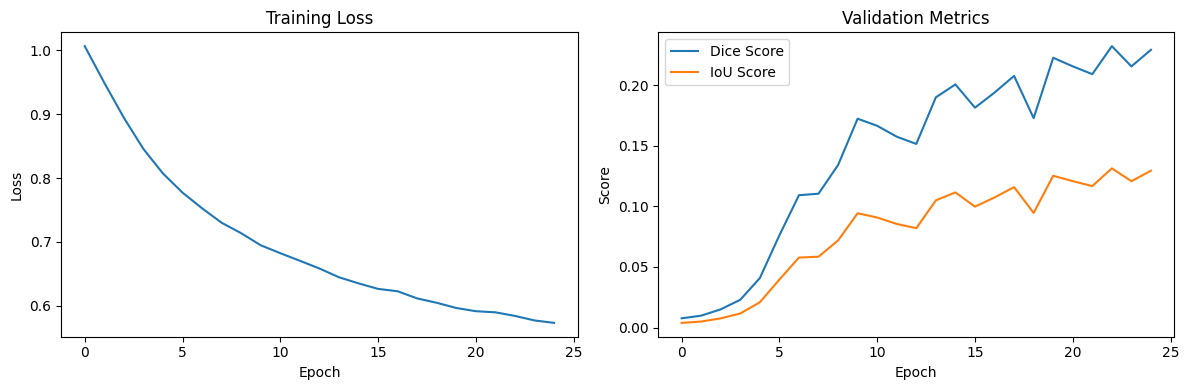

Training history plot saved!


In [ ]:
import os
import torch
import rasterio
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import segmentation_models_pytorch as smp
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

# --- 1. Enhanced Configuration & Hyperparameters ---
# Paths updated to match your Google Drive structure
IMAGE_DIR = '/content/drive/MyDrive/P2 - Amazon ITU - PESU/GEE_Exports_all'
MASK_DIR = '/content/drive/MyDrive/P2 - Amazon ITU - PESU/All_Masks_TIF'
MODEL_SAVE_PATH = '/content/drive/MyDrive/runway_detection_best.pth'

# Enhanced Model Settings - Better encoders for satellite imagery
ENCODER = 'efficientnet-b3'  # Smaller encoder to prevent memory issues
ENCODER_WEIGHTS = 'imagenet'
IN_CHANNELS = 3  # RGB channels only
CLASSES = 1
LEARNING_RATE = 1e-4  # Lower learning rate for stability
EPOCHS = 25
BATCH_SIZE = 4  # Reduced batch size for stability
IMG_SIZE = 256
ACCUMULATION_STEPS = 4  # Higher accumulation for effective batch size of 16

# Advanced training settings
WARMUP_EPOCHS = 5
LABEL_SMOOTHING = 0.1
EARLY_STOPPING_PATIENCE = 10

# Set seed for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)

# --- 2. Enhanced Dataset Class with Better Error Handling ---
class EnhancedAirstripDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, in_channels=3, validate_files=True):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.transform = transform
        self.in_channels = in_channels

        if validate_files:
            # Validate all files exist and are readable
            self.valid_indices = []
            print(f"Validating {len(image_paths)} image-mask pairs...")

            for i, (img_path, mask_path) in enumerate(zip(image_paths, mask_paths)):
                try:
                    # Quick validation - just check if files can be opened
                    with rasterio.open(img_path) as src:
                        if src.count == 0:
                            continue

                    with rasterio.open(mask_path) as src:
                        mask_sample = src.read(1)
                        # Accept masks even if they're mostly empty - we need some training data
                        if mask_sample is not None and mask_sample.size > 0:
                            self.valid_indices.append(i)

                except Exception as e:
                    print(f"Skipping invalid pair {i}: {e}")
                    continue

            print(f"Valid samples: {len(self.valid_indices)} out of {len(image_paths)}")
        else:
            # Don't validate, use all indices
            self.valid_indices = list(range(len(image_paths)))
            print(f"Using all {len(self.valid_indices)} samples without validation")

    def __len__(self):
        return len(self.valid_indices)

    def normalize_bands(self, image):
        """Enhanced normalization with robust handling of problematic values"""
        # Ensure we have 3 channels
        if image.shape[2] > 3:
            image = image[:, :, :3]
        elif image.shape[2] < 3:
            # Pad with zeros if fewer than 3 channels
            padding = np.zeros((image.shape[0], image.shape[1], 3 - image.shape[2]), dtype=np.float32)
            image = np.concatenate([image, padding], axis=2)

        # First, handle any non-finite values
        if not np.isfinite(image).all():
            print("Warning: Non-finite values in image, replacing with zeros")
            image = np.nan_to_num(image, nan=0.0, posinf=0.0, neginf=0.0)

        # More aggressive clipping for satellite data
        # Many satellite images have extreme values
        image = np.clip(image, 0, None)  # Remove negative values

        # Handle each channel independently with very robust normalization
        for i in range(image.shape[2]):
            channel = image[:, :, i].copy()

            # Skip empty channels
            if channel.max() == 0:
                image[:, :, i] = 0
                continue

            # Remove extreme outliers using IQR method
            q25, q75 = np.percentile(channel[channel > 0], [25, 75])
            iqr = q75 - q25

            if iqr > 0:
                # Cap extreme values
                upper_bound = q75 + 3 * iqr
                lower_bound = max(0, q25 - 1.5 * iqr)
                channel = np.clip(channel, lower_bound, upper_bound)

            # Simple min-max normalization after clipping
            ch_min = channel.min()
            ch_max = channel.max()

            if ch_max > ch_min:
                image[:, :, i] = (channel - ch_min) / (ch_max - ch_min)
            else:
                image[:, :, i] = 0

        # Final safety check
        image = np.clip(image, 0, 1)
        image = np.nan_to_num(image, nan=0.0, posinf=0.0, neginf=0.0)

        return image.astype(np.float32)

    def __getitem__(self, idx):
        actual_idx = self.valid_indices[idx]
        image_path = self.image_paths[actual_idx]
        mask_path = self.mask_paths[actual_idx]

        try:
            # Read image
            with rasterio.open(image_path) as src:
                # Read first 3 bands
                bands_to_read = min(3, src.count)
                image = src.read(list(range(1, bands_to_read + 1))).astype(np.float32)
                image = np.transpose(image, (1, 2, 0))

            # Read mask
            with rasterio.open(mask_path) as mask_src:
                mask = mask_src.read(1).astype(np.float32)
                # Ensure binary mask
                mask = np.where(mask > 0, 1.0, 0.0)

            # Check dimensions match
            if image.shape[:2] != mask.shape[:2]:
                # Resize mask to match image
                mask = cv2.resize(mask, (image.shape[1], image.shape[0]), interpolation=cv2.INTER_NEAREST)

            # Normalize the image
            image = self.normalize_bands(image)

            # Validate data integrity
            if not np.isfinite(image).all() or not np.isfinite(mask).all():
                raise ValueError("Non-finite values detected")

            # Apply transforms
            if self.transform:
                augmented = self.transform(image=image, mask=mask)
                image = augmented['image']
                mask = augmented['mask']

            # Final validation
            if torch.isnan(image).any() or torch.isnan(mask).any():
                raise ValueError("NaN values after transformation")

            return image, mask.unsqueeze(0)

        except Exception as e:
            print(f"Error loading sample {idx} ({image_path}): {str(e)}")
            # Return a valid dummy sample
            dummy_image = torch.zeros((3, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
            dummy_mask = torch.zeros((1, IMG_SIZE, IMG_SIZE), dtype=torch.float32)
            return dummy_image, dummy_mask

# --- 3. Simplified and Robust Augmentations ---
def get_transforms(phase='train'):
    """Simplified augmentations to avoid numerical instability"""

    if phase == 'train':
        return A.Compose([
            A.Resize(height=IMG_SIZE, width=IMG_SIZE),

            # Basic geometric augmentations
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.RandomRotate90(p=0.5),
            A.Rotate(limit=10, p=0.3, border_mode=cv2.BORDER_CONSTANT, value=0),

            # Mild intensity augmentations
            A.RandomBrightnessContrast(
                brightness_limit=0.1,
                contrast_limit=0.1,
                p=0.5
            ),

            # Light noise
            A.GaussNoise(var_limit=(0, 0.01), p=0.3),

            # Standard normalization
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=1.0
            ),
            ToTensorV2(),
        ], is_check_shapes=False)
    else:  # Validation
        return A.Compose([
            A.Resize(height=IMG_SIZE, width=IMG_SIZE),
            A.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225],
                max_pixel_value=1.0
            ),
            ToTensorV2(),
        ], is_check_shapes=False)

# --- 4. Robust Loss Function with NaN Protection ---
class RobustRunwayLoss(nn.Module):
    """Robust loss function with NaN protection"""

    def __init__(self, pos_weight=None):
        super(RobustRunwayLoss, self).__init__()
        # Use pos_weight to handle class imbalance
        self.pos_weight = pos_weight
        self.bce = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
        self.smooth = 1e-6

    def dice_loss(self, inputs, targets):
        """Dice loss with numerical stability"""
        inputs = torch.sigmoid(inputs)

        # Flatten tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)

        intersection = (inputs * targets).sum()
        union = inputs.sum() + targets.sum()

        dice = (2. * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice

    def forward(self, inputs, targets):
        # Check for NaN inputs
        if torch.isnan(inputs).any() or torch.isnan(targets).any():
            print("Warning: NaN detected in loss inputs!")
            return torch.tensor(0.0, requires_grad=True, device=inputs.device)

        bce_loss = self.bce(inputs, targets)
        dice_loss = self.dice_loss(inputs, targets)

        total_loss = 0.5 * bce_loss + 0.5 * dice_loss

        # Check for NaN output
        if torch.isnan(total_loss):
            print("Warning: NaN loss detected!")
            return torch.tensor(0.0, requires_grad=True, device=inputs.device)

        return total_loss

# --- 5. Enhanced Training Functions with Gradient Monitoring ---
def train_one_epoch(loader, model, optimizer, loss_fn, device, accumulation_steps=1):
    """Enhanced training loop with gradient monitoring"""
    model.train()
    running_loss = 0.0
    valid_batches = 0
    loop = tqdm(loader, leave=True, desc="Training")

    optimizer.zero_grad()

    for batch_idx, (data, targets) in enumerate(loop):
        data, targets = data.to(device), targets.to(device)

        # Check for NaN inputs
        if torch.isnan(data).any() or torch.isnan(targets).any():
            print(f"Skipping batch {batch_idx} due to NaN inputs")
            continue

        try:
            predictions = model(data)

            # Check predictions
            if torch.isnan(predictions).any():
                print(f"NaN predictions in batch {batch_idx}")
                continue

            loss = loss_fn(predictions, targets)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Invalid loss in batch {batch_idx}: {loss}")
                continue

            loss = loss / accumulation_steps
            loss.backward()

            # Check gradients
            total_norm = 0
            for p in model.parameters():
                if p.grad is not None:
                    param_norm = p.grad.data.norm(2)
                    total_norm += param_norm.item() ** 2
            total_norm = total_norm ** (1. / 2)

            if total_norm > 1000 or torch.isnan(torch.tensor(total_norm)):
                print(f"Large gradient norm: {total_norm}, clipping...")
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

            if (batch_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

            running_loss += loss.item() * accumulation_steps
            valid_batches += 1

        except Exception as e:
            print(f"Error in batch {batch_idx}: {e}")
            continue

        if valid_batches > 0:
            loop.set_postfix(loss=running_loss / valid_batches)

    return running_loss / max(valid_batches, 1)

def evaluate(loader, model, loss_fn, device):
    """Enhanced evaluation with better metric calculation"""
    model.eval()
    running_loss = 0.0
    total_intersection = 0
    total_union = 0
    total_target = 0
    total_pred = 0
    valid_batches = 0

    loop = tqdm(loader, leave=True, desc="Validation")

    with torch.no_grad():
        for data, targets in loop:
            data, targets = data.to(device), targets.to(device)

            # Skip invalid batches
            if torch.isnan(data).any() or torch.isnan(targets).any():
                continue

            try:
                predictions = model(data)

                if torch.isnan(predictions).any():
                    continue

                loss = loss_fn(predictions, targets)

                if torch.isnan(loss) or torch.isinf(loss):
                    continue

                running_loss += loss.item()
                valid_batches += 1

                # Convert to binary predictions
                preds_sigmoid = torch.sigmoid(predictions)
                preds_binary = (preds_sigmoid > 0.5).float()

                # Calculate metrics
                intersection = (preds_binary * targets).sum().item()
                pred_sum = preds_binary.sum().item()
                target_sum = targets.sum().item()
                union = pred_sum + target_sum - intersection

                total_intersection += intersection
                total_union += union
                total_target += target_sum
                total_pred += pred_sum

            except Exception as e:
                print(f"Error in validation batch: {e}")
                continue

    if valid_batches == 0:
        print("No valid validation batches!")
        return 0.0, 0.0, 0.0, 0.0

    avg_loss = running_loss / valid_batches

    # Calculate overall metrics
    dice = (2 * total_intersection) / (total_pred + total_target + 1e-8)
    iou = total_intersection / (total_union + 1e-8)
    precision = total_intersection / (total_pred + 1e-8)
    recall = total_intersection / (total_target + 1e-8)

    print(f"Val Loss: {avg_loss:.4f}, Dice: {dice:.4f}, IoU: {iou:.4f}")
    print(f"Precision: {precision:.4f}, Recall: {recall:.4f}")

    return dice, iou, precision, recall

# --- 6. Same image-mask pairing function ---
def find_image_mask_pairs(image_dir, mask_dir):
    """Enhanced pairing logic for image-mask matching"""
    print("Scanning folders and pairing images with masks...")

    # Get all image files
    image_files = [f for f in os.listdir(image_dir) if f.endswith('.tif')]
    print(f"Found {len(image_files)} image files")

    paired_image_paths = []
    paired_mask_paths = []
    unmatched_images = []

    for img_fname in image_files:
        base_name = os.path.splitext(img_fname)[0]

        # Try different mask naming patterns
        possible_mask_names = [
            f"0_{base_name}.tif",
            f"1_{base_name}.tif",
            f"{base_name}_mask.tif",
            f"mask_{base_name}.tif"
        ]

        found_mask = None
        for mask_name in possible_mask_names:
            mask_path = os.path.join(mask_dir, mask_name)
            if os.path.exists(mask_path):
                found_mask = mask_path
                break

        if found_mask:
            # Verify mask has runway pixels
            try:
                with rasterio.open(found_mask) as src:
                    mask_data = src.read(1)
                    if np.any(mask_data > 0):  # Mask has positive pixels
                        paired_image_paths.append(os.path.join(image_dir, img_fname))
                        paired_mask_paths.append(found_mask)
                    else:
                        print(f"Skipping {img_fname} - empty mask")
            except Exception as e:
                print(f"Error reading mask for {img_fname}: {e}")
        else:
            unmatched_images.append(img_fname)

    print(f"Successfully paired: {len(paired_image_paths)} images")
    print(f"Unmatched images: {len(unmatched_images)}")

    if len(unmatched_images) > 0 and len(unmatched_images) <= 10:
        print("Unmatched files:", unmatched_images[:10])

    return paired_image_paths, paired_mask_paths

# --- 7. Main Execution with Better Error Handling ---
if __name__ == '__main__':
    device = "cuda" if torch.cuda.is_available() else "cpu"
    print(f"Using {device} device")
    print(f"Encoder: {ENCODER}")
    print(f"Input channels: {IN_CHANNELS}")
    print(f"Image size: {IMG_SIZE}")

    # Find and pair images with masks
    paired_image_paths, paired_mask_paths = find_image_mask_pairs(IMAGE_DIR, MASK_DIR)

    if len(paired_image_paths) == 0:
        print("CRITICAL ERROR: No valid image-mask pairs found!")
        print("Please check your directory paths and file naming conventions.")
        exit(1)

    # Split data
    train_imgs, val_imgs, train_masks, val_masks = train_test_split(
        paired_image_paths, paired_mask_paths, test_size=0.2, random_state=SEED, stratify=None
    )

    print(f"Training samples: {len(train_imgs)}")
    print(f"Validation samples: {len(val_imgs)}")

    # Create datasets - first try without strict validation
    print("Creating datasets with relaxed validation...")
    train_dataset = EnhancedAirstripDataset(
        train_imgs, train_masks,
        transform=get_transforms('train'),
        in_channels=IN_CHANNELS,
        validate_files=False  # Skip strict validation first
    )

    val_dataset = EnhancedAirstripDataset(
        val_imgs, val_masks,
        transform=get_transforms('val'),
        in_channels=IN_CHANNELS,
        validate_files=False
    )

    # Check if we have valid datasets
    if len(train_dataset) == 0:
        print("ERROR: No valid training samples found!")
        print("This usually means:")
        print("1. All masks are empty (no runway pixels)")
        print("2. File corruption issues")
        print("3. Incorrect file paths or naming")

        # Let's debug by checking a few files directly
        print("\nDebugging first few image-mask pairs...")
        for i in range(min(5, len(train_imgs))):
            img_path = train_imgs[i]
            mask_path = train_masks[i]
            print(f"\nPair {i+1}:")
            print(f"Image: {img_path}")
            print(f"Mask: {mask_path}")

            try:
                with rasterio.open(mask_path) as src:
                    mask_data = src.read(1)
                    unique_vals = np.unique(mask_data)
                    pos_pixels = np.sum(mask_data > 0)
                    print(f"Mask unique values: {unique_vals}")
                    print(f"Positive pixels: {pos_pixels}")
                    print(f"Mask shape: {mask_data.shape}")
            except Exception as e:
                print(f"Error reading mask: {e}")

        exit(1)

    # Calculate class weights for imbalanced data
    print("Calculating class weights...")
    total_pixels = 0
    positive_pixels = 0

    # Use a simple approach - check raw mask files instead of dataset
    sample_masks = train_masks[:min(10, len(train_masks))]
    for mask_path in sample_masks:
        try:
            with rasterio.open(mask_path) as src:
                mask_data = src.read(1)
                total_pixels += mask_data.size
                positive_pixels += np.sum(mask_data > 0)
        except Exception as e:
            print(f"Error reading {mask_path}: {e}")
            continue

    if positive_pixels > 0:
        pos_weight = (total_pixels - positive_pixels) / positive_pixels
        pos_weight = max(1.0, min(pos_weight, 100))  # Ensure at least 1.0
        print(f"Positive class weight: {pos_weight:.2f}")
    else:
        pos_weight = 1.0
        print("Warning: No positive pixels found, using weight 1.0")

    # Create data loaders
    train_loader = DataLoader(
        train_dataset, batch_size=BATCH_SIZE, shuffle=True,
        num_workers=0, pin_memory=True, drop_last=True  # num_workers=0 for debugging
    )

    val_loader = DataLoader(
        val_dataset, batch_size=BATCH_SIZE, shuffle=False,
        num_workers=0, pin_memory=True
    )

    # Test data loading
    print("Testing data loading...")
    try:
        sample_batch = next(iter(train_loader))
        print(f"Sample batch shapes: {sample_batch[0].shape}, {sample_batch[1].shape}")
        print(f"Sample image range: {sample_batch[0].min():.3f} to {sample_batch[0].max():.3f}")
        print(f"Sample mask range: {sample_batch[1].min():.3f} to {sample_batch[1].max():.3f}")
        print(f"Positive pixels in sample: {sample_batch[1].sum().item()}")
    except Exception as e:
        print(f"Error loading sample batch: {e}")
        exit(1)

    # Initialize model
    model = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights=ENCODER_WEIGHTS,
        in_channels=IN_CHANNELS,
        classes=CLASSES,
        activation=None
    ).to(device)

    # Initialize loss and optimizer
    loss_fn = RobustRunwayLoss(pos_weight=torch.tensor(pos_weight).to(device))

    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=LEARNING_RATE,
        weight_decay=1e-5,
        eps=1e-8
    )

    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=5, verbose=True
    )

    # Training loop
    best_dice_score = 0.0
    patience_counter = 0
    train_losses = []
    val_metrics = []

    print("\nStarting training...")
    for epoch in range(EPOCHS):
        print(f"\n=== Epoch {epoch+1}/{EPOCHS} ===")

        # Training
        train_loss = train_one_epoch(
            train_loader, model, optimizer, loss_fn, device, ACCUMULATION_STEPS
        )
        train_losses.append(train_loss)
        print(f"Train Loss: {train_loss:.4f}")

        # Validation
        val_dice, val_iou, val_precision, val_recall = evaluate(
            val_loader, model, loss_fn, device
        )
        val_metrics.append({
            'dice': val_dice, 'iou': val_iou,
            'precision': val_precision, 'recall': val_recall
        })

        # Learning rate scheduling
        scheduler.step(val_dice)
        current_lr = optimizer.param_groups[0]['lr']
        print(f"Current LR: {current_lr:.2e}")

        # Save best model
        if val_dice > best_dice_score:
            best_dice_score = val_dice
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_dice': best_dice_score,
                'train_loss': train_loss,
                'val_metrics': val_metrics[-1]
            }, MODEL_SAVE_PATH)
            print(f"New best model saved! Dice: {best_dice_score:.4f}")
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= EARLY_STOPPING_PATIENCE:
            print(f"Early stopping triggered after {epoch+1} epochs")
            break

    print("\nTraining completed!")
    print(f"Best Dice Score: {best_dice_score:.4f}")
    print(f"Model saved to: {MODEL_SAVE_PATH}")

    # Plot training history
    if len(train_losses) > 0 and len(val_metrics) > 0:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(train_losses)
        plt.title('Training Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')

        plt.subplot(1, 2, 2)
        dice_scores = [m['dice'] for m in val_metrics]
        iou_scores = [m['iou'] for m in val_metrics]
        plt.plot(dice_scores, label='Dice Score')
        plt.plot(iou_scores, label='IoU Score')
        plt.title('Validation Metrics')
        plt.xlabel('Epoch')
        plt.ylabel('Score')
        plt.legend()

        plt.tight_layout()
        plt.savefig('/content/drive/MyDrive/training_history.png', dpi=300, bbox_inches='tight')
        plt.show()

        print("Training history plot saved!")